# Проект: Карта ДТП

- Автор: Алексей Кознов
- Дата: 27.08.25

### Цели и задачи проекта
Провести глубокий анализ данных, сформулировать и проверить гипотезы, опираясь на доступные признаки.

**Задачи:**
1. Загрузить данные и познакомиться с их содержимым.
2. Провести предобработку данных.
3. Провести исследовательский анализ данных:
4. Проверить гипотезы.
5. Выводы и рекомендации

## Описание данных

Структура файлов с данными:
- `id` -  идентификатор
- `tags` - показатели с официального сайта ГИБДД
- `light` - время суток
- `point` - координаты
- `nearby` - координаты
- `region` - город/район
- `address` - адрес
- `weather` - погода
- `category` - тип ДТП
- `datetime` - дата и время
- `severity` - тяжесть ДТП/вред здоровью
- `vehicles` - участники – транспортные средства
  - `year` - год производства транспортного средства
  - `brand` - марка транспортного средства
  - `color` - цвет транспортного средства
  - `model` - модель транспортного средства
  - `category` - категория транспортного средства
  - `participants` - участники внутри транспортных средств
    - `role` - роль участника
    - `gender` - пол участника
    - `violations` - нарушения правил участником
    - `health_status` - состояние здоровья участника
    - `years_of_driving_experience` - стаж вождения участника (только у водителей)
- `dead_count` - кол-во погибших в ДТП
- `participants` - участники без транспортных средств (описание, как у участников внутри транспортных средств)
- `injured_count` - кол-во раненых в ДТП
- `parent_region` - регион
- `road_conditions` - состояние дорожного покрытия
- `participants_count` - кол-во участников ДТП
- `participant_categories` - категории участников


# 1. Загрузка данных и знакомство с ними

In [7]:
# 1. ОСНОВНЫЕ ДАННЫЕ И РАБОТА С ФАЙЛАМИ
import pandas as pd
import numpy as np
import os
import json
import zipfile
import re
import time
import math
import calendar
from urllib.parse import urljoin, urlparse
import datetime as dt

# 2. ВЕБ-СКРАПИНГ И РАБОТА С СЕТЬЮ
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm  # прогресс-бар для скрапинга

# 3. ГЕОДАННЫ И ГЕОПРОСТРАНСТВЕННЫЙ АНАЛИЗ
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import HeatMap

# 4. ВИЗУАЛИЗАЦИЯ ДАННЫХ
import matplotlib.pyplot as plt
import seaborn as sns

# 5. СТАТИСТИЧЕСКИЙ АНАЛИЗ
from scipy import stats
from scipy.stats import mannwhitneyu, chi2_contingency, fisher_exact, levene, kendalltau
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

In [8]:
# ПОПРОБУЕМ УСТАНОВИТЬ PHIK
try:
    import phik
    from phik import report
except ImportError:
# ЕСЛИ МОДУЛЯ НЕТ, ТО УСТАНАВЛИВАЕМ
    !pip install phik --quiet
    import phik
    from phik import report

Добавим дополнительные настройки для удобства

In [10]:
tqdm.pandas()

In [11]:
%matplotlib inline

In [12]:
pd.set_option('display.max_columns', 40)

In [13]:
pd.set_option('future.no_silent_downcasting', True)

Можете удалить строчку ниже если используете светлую тему. У меня темная, поэтому основной цвет графиков черный смотрится органично и не нагружает глаза

In [15]:
plt.style.use('dark_background')

Данные находятся на сайте в формате geojson https://dtp-stat.ru/opendata

Парсим сайт на предмет ссылок на файлы, чтобы в дальнейшем загрузить необходимые датасеты

In [17]:
def parse_dtp_stat_links_csv(file_csv="dtp_links.csv"):
    url = "https://dtp-stat.ru/opendata"
    resp = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    resp.raise_for_status()
    soup = BeautifulSoup(resp.content, "html.parser")

    pattern = re.compile(r"\.geojson(?:\.zip)?$", re.IGNORECASE)

    rows = []
    for a in soup.find_all("a", href=True):
        href = a["href"]
        if not pattern.search(href):
            continue
        full_url = urljoin(url, href)
        path = urlparse(full_url).path
        filename = os.path.basename(path)

        region_slug = re.sub(r"\.geojson(?:\.zip)?$", "", filename, flags=re.IGNORECASE)
        region_name = region_slug.replace("-", " ").title()

        filetype = "zip" if filename.lower().endswith(".zip") else "geojson"

        rows.append({
            "region": region_name,
            "filename": filename,
            "filetype": filetype,
            "url": full_url
        })

    df = pd.DataFrame(rows).drop_duplicates("url").sort_values("region").reset_index(drop=True)
    df.to_csv(file_csv, index=False, encoding="utf-8-sig")
    print(f"Сохранено {len(df)} ссылок в {file_csv}")
    return df

In [18]:
df_links = parse_dtp_stat_links_csv()

Сохранено 82 ссылок в dtp_links.csv


In [19]:
df_links.head()

region                           filename filetype  \
0       Amurskaia Oblast       amurskaia-oblast.geojson.zip      zip   
1  Arkhangelskaia Oblast  arkhangelskaia-oblast.geojson.zip      zip   
2  Astrakhanskaia Oblast  astrakhanskaia-oblast.geojson.zip      zip   
3   Belgorodskaia Oblast   belgorodskaia-oblast.geojson.zip      zip   
4      Brianskaia Oblast      brianskaia-oblast.geojson.zip      zip   

                                                 url  
0  https://cms.dtp-stat.ru/media/opendata/amurska...  
1  https://cms.dtp-stat.ru/media/opendata/arkhang...  
2  https://cms.dtp-stat.ru/media/opendata/astrakh...  
3  https://cms.dtp-stat.ru/media/opendata/belgoro...  
4  https://cms.dtp-stat.ru/media/opendata/briansk...

Напишем функцию для загрузки и обработки данных ДТП по региону

In [21]:
def load_region(row, data_dir="dtp_data"):
    os.makedirs(data_dir, exist_ok=True)
    url = row["url"]
    filename = os.path.join(data_dir, row["filename"])

    # скачиваем
    if not os.path.exists(filename):
        r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        r.raise_for_status()
        with open(filename, "wb") as f:
            f.write(r.content)
        print(f"Файл скачан: {filename}")
    else:
        print(f"Уже есть: {filename}")

    # если zip → распаковываем
    if filename.endswith(".zip"):
        with zipfile.ZipFile(filename, "r") as z:
            extracted_files = z.namelist()
            geojson_file = [f for f in extracted_files if f.endswith(".geojson")][0]
            extracted_path = os.path.join(data_dir, geojson_file)
            if not os.path.exists(extracted_path):
                z.extract(geojson_file, data_dir)
                print(f"Распакован: {extracted_path}")
            filename_geojson = extracted_path
    else:
        filename_geojson = filename

    # читаем как json, чтобы достать все properties
    with open(filename_geojson, "r", encoding="utf-8") as f:
        data = json.load(f)

    all_properties = [feat["properties"] for feat in data["features"]]
    properties_df = pd.DataFrame(all_properties)

    # геометрия (geometry из geojson)
    gdf_region = gpd.GeoDataFrame.from_features(data["features"])

    # заменяем/добавляем нужные колонки
    for col in ["tags", "weather", "road_conditions", "participant_categories"]:
        if col in properties_df.columns:
            gdf_region[col] = properties_df[col]

    return gdf_region

Применим функцию и соберем датафрейм со всеми регионами

In [23]:
all_gdfs = []
for _, row in df_links.iterrows():
    try:
        gdf_region = load_region(row)
        all_gdfs.append(gdf_region)
    except Exception as e:
        print(f"Ошибка при {row['region']}: {e}")

gdf_all = pd.concat(all_gdfs, ignore_index=True)

Уже есть: dtp_data\amurskaia-oblast.geojson.zip
Уже есть: dtp_data\arkhangelskaia-oblast.geojson.zip
Уже есть: dtp_data\astrakhanskaia-oblast.geojson.zip
Уже есть: dtp_data\belgorodskaia-oblast.geojson.zip
Уже есть: dtp_data\brianskaia-oblast.geojson.zip
Уже есть: dtp_data\chechenskaia-respublika.geojson.zip
Уже есть: dtp_data\cheliabinskaia-oblast.geojson.zip
Уже есть: dtp_data\chukotskii-avtonomnyi-okrug.geojson.zip
Уже есть: dtp_data\chuvashskaia-respublika-chuvashiia.geojson.zip
Уже есть: dtp_data\evreiskaia-avtonomnaia-oblast.geojson.zip
Уже есть: dtp_data\iamalo-nenetskii-avtonomnyi-okrug.geojson.zip
Уже есть: dtp_data\iaroslavskaia-oblast.geojson.zip
Уже есть: dtp_data\irkutskaia-oblast.geojson.zip
Уже есть: dtp_data\ivanovskaia-oblast.geojson.zip
Уже есть: dtp_data\kabardino-balkarskaia-respublika.geojson.zip
Уже есть: dtp_data\kaliningradskaia-oblast.geojson.zip
Уже есть: dtp_data\kaluzhskaia-oblast.geojson.zip
Уже есть: dtp_data\kamchatskii-krai.geojson.zip
Уже есть: dtp_data

Посмотрим на результат

In [25]:
gdf_all.sample(2)

geometry       id  \
231606   POINT (86.0278 55.2442)   937522   
1284548              POINT EMPTY  1044896   

                                        tags                light  \
231606   [Дорожно-транспортные происшествия]  Светлое время суток   
1284548  [Дорожно-транспортные происшествия]              Сумерки   

                                     point  \
231606   {'lat': 55.2442, 'long': 86.0278}   
1284548        {'lat': None, 'long': None}   

                                                    nearby             region  \
231606   [Нерегулируемый пешеходный переход, Остановка ...  Кемеровский район   
1284548               [Регулируемый перекресток, Кладбище]           Тобольск   

        scheme                              address weather      category  \
231606     070         Кемерово-Промышленная, 14 км  [Ясно]  Столкновение   
1284548    070  г Тобольск, пр-кт Комсомольский, 66  [Ясно]  Столкновение   

                    datetime severity  \
231606   2016-06-02 18:20:00   Легкий   
1284548  2016-12-28 07:50:00   Легкий   

                                                  vehicles  dead_count  \
231606   [{'year': 2011, 'brand': 'CHEVROLET', 'color':...           0   
1284548  [{'year': 2010, 'brand': 'ВАЗ', 'color': 'Белы...           0   

        participants  injured_count                  parent_region  \
231606            []              1  Кемеровская область - Кузбасс   
1284548           []              1              Тюменская область   

                                           road_conditions  \
231606                                             [Сухое]   
1284548  [Сухое, Отсутствие дорожных знаков в необходим...   

         participants_count participant_categories  
231606                    2        [Все участники]  
1284548                   3        [Все участники]

Выведем общую информацию о датафрейме

In [27]:
gdf_all.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1465882 entries, 0 to 1465881
Data columns (total 21 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   geometry                1465882 non-null  geometry
 1   id                      1465882 non-null  int64   
 2   tags                    1465882 non-null  object  
 3   light                   1465882 non-null  object  
 4   point                   1465882 non-null  object  
 5   nearby                  1465882 non-null  object  
 6   region                  1465882 non-null  object  
 7   scheme                  1386812 non-null  object  
 8   address                 1389322 non-null  object  
 9   weather                 1465882 non-null  object  
 10  category                1465882 non-null  object  
 11  datetime                1465882 non-null  object  
 12  severity                1465882 non-null  object  
 13  vehicles                1465882 no

Датасет содержит 21 столбцец и 1465882 строки, в которых представлена различная информация об дтп.

После первичного анализа данных можно сделать следующие выводы:
- Столбцы названы корректно
- Столбцы `vehicles` и `participants` содержат списки и словари с информацией о транспортных средствах и пешеходах, выделим эти данные в отдельные датафреймы
- Числовые столбцы `dead_count`, `injured_count`, `participants_count` можно уменьшить размерность
- Тип данных столбца `datetime` стоит изменить на datetime , остальные типы данных на первый взгляд соответствуют содержимому
- Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию
- В некоторых столбцах есть пропуски

#  2 Предобработка

Оптимизируем размерность в числовых столбцах

In [31]:
for column in ['dead_count', 'injured_count', 'participants_count']:
    gdf_all[column] = pd.to_numeric(gdf_all[column], downcast='integer')

Посморим результат

In [33]:
gdf_all[['dead_count', 'injured_count', 'participants_count']].dtypes

dead_count             int8
injured_count          int8
participants_count    int16
dtype: object

Создадим 3 отдельных датафрейма, основной с информацией о происшествиях, второй про транспортные средства и третий про участников

Создадим датафреймы с транспортными средствами и участниками

In [36]:
vehicles_rows = []
participants_rows = []

for _, row in gdf_all.iterrows():
    accident_id = row['id']

    # Парсим vehicles
    vehicles_data = row['vehicles']
    if isinstance(vehicles_data, str):
        try:
            vehicles_data = json.loads(vehicles_data)
        except:
            vehicles_data = []
    
    if isinstance(vehicles_data, list):
        for v_idx, v in enumerate(vehicles_data):
            vehicle_id = f"{accident_id}_{v_idx}"
            
            vehicles_rows.append({
                "id": accident_id,                # ДТП id
                "vehicle_id": vehicle_id,         # уникальный ID ТС
                "year": v.get("year"),
                "brand": v.get("brand"),
                "color": v.get("color"),
                "model": v.get("model"),
                "category": v.get("category"),
            })
            
            # Участники внутри vehicles 
            participants_data = v.get("participants", [])
            if isinstance(participants_data, str):
                try:
                    participants_data = json.loads(participants_data)
                except:
                    participants_data = []
            
            if isinstance(participants_data, list):
                for p in participants_data:
                    participants_rows.append({
                        "id": accident_id,
                        "vehicle_id": vehicle_id,       # совпадёт с vehicles_df
                        "vehicle_category": v.get("category"),
                        "role": p.get("role"),
                        "gender": p.get("gender"),
                        "violations": p.get("violations", []),
                        "health_status": p.get("health_status"),
                        "years_of_driving_experience": p.get("years_of_driving_experience")
                    })


In [37]:
for _, row in gdf_all.iterrows():
    accident_id = row['id']

    participants_data = row['participants']
    if isinstance(participants_data, str):
        try:
            participants_data = json.loads(participants_data)
        except:
            participants_data = []
    
    if isinstance(participants_data, list):
        for p in participants_data:
            participants_rows.append({
                "id": accident_id,
                "vehicle_id": None,
                "vehicle_category": None,
                "role": p.get("role"),
                "gender": p.get("gender"),
                "violations": p.get("violations", []),
                "health_status": p.get("health_status"),
                "years_of_driving_experience": p.get("years_of_driving_experience")
            })


Посмотрим на результат

In [39]:
vehicles_df = pd.DataFrame(vehicles_rows)
participants_df = pd.DataFrame(participants_rows)

In [40]:
vehicles_df.sample(2)

id vehicle_id    year     brand         color    model  \
2107725  720176   720176_0  2016.0  MERCEDES  Многоцветный  C-класс   
260157   968396   968396_1  2012.0   HYUNDAI         Серый     ix35   

                                             category  
2107725                      В-класс (малый) до 3,9 м  
260157   С-класс (малый средний, компактный) до 4,3 м

In [41]:
participants_df.sample(2)

id vehicle_id            vehicle_category      role   gender  \
1109228  1314132  1314132_0    В-класс (малый) до 3,9 м  Водитель  Мужской   
600551    333129   333129_0  Прочие легковые автомобили  Пассажир  Женский   

                                                violations  \
1109228                                                 []   
600551   [Создание помех для водителя в управлении тран...   

                                             health_status  \
1109228  Раненый, находящийся (находившийся)  на амбула...   
600551   Получил телесные повреждения с показанием к ле...   

         years_of_driving_experience  
1109228                          NaN  
600551                           NaN

Удалим столбцы с транспортом и участниками из основного датафрейма

In [43]:
gdf = gdf_all.drop(columns=['participants', 'vehicles'])

Приведем столбец `datetime` к типу datetime64

In [45]:
gdf['datetime'] = pd.to_datetime(gdf['datetime'])

Итого у нас 3 датафрейма:
- `gdf` с основной информацией об авариях
- `vehicles_df` с информацией об транспортных средвствах
- `participants_df` с информацией об участниках

Посмотрим на датафреймы подробнее на предмет пропусков, дубликатов и аномалий

In [48]:
gdf.isna().sum().sort_values(ascending=False)

scheme                    79070
address                   76560
geometry                      0
datetime                      0
participants_count            0
road_conditions               0
parent_region                 0
injured_count                 0
dead_count                    0
severity                      0
weather                       0
category                      0
id                            0
region                        0
nearby                        0
point                         0
light                         0
tags                          0
participant_categories        0
dtype: int64

In [49]:
gdf.isna().mean().sort_values(ascending=False)

scheme                    0.053940
address                   0.052228
geometry                  0.000000
datetime                  0.000000
participants_count        0.000000
road_conditions           0.000000
parent_region             0.000000
injured_count             0.000000
dead_count                0.000000
severity                  0.000000
weather                   0.000000
category                  0.000000
id                        0.000000
region                    0.000000
nearby                    0.000000
point                     0.000000
light                     0.000000
tags                      0.000000
participant_categories    0.000000
dtype: float64

В столбце `scheme` числовое обозначений для схемы конкретной аварии. Оставим пропуски как есть, если он понадобится для исследования, то исправим.

Пропуски в столбце `address` можно заполнить данными из столбца `geometry`

Для получения адресов по географическим координатам  можно воспользоваться сервисом геокодирования Яндекса (Яндекс Геокодер), его можно использовать на небольшом регионе бесплатно (примерно 1000-1500 запросов), либо платно на всем датафрейме, т.к. бесплатно количество запросов ограничено

Для работы с Яндекс Геокодером нужен API-ключ.
Его можно получить в личном кабинете Яндекс.Облака (https://cloud.yandex.ru/).
Ключ должен быть сохранён в переменной окружения YANDEX_API_KEY.
- Например, в Linux/macOS: `export YANDEX_API_KEY="ваш_ключ"`
- В Windows (PowerShell): `setx YANDEX_API_KEY "ваш_ключ"`

Ниже несколько блоков кода, последний закомментирован, его можно использовать для заполнения пустых ячеек с помощью яндекс геокодер

In [53]:
API_KEY = os.getenv("YANDEX_API_KEY")
if API_KEY is None:
    print("Ключ не найден!")
else:
    print(API_KEY[:4] + "...") 

575d...


Функции для заполнения адреса из столбца геометрии и наоборот.

In [55]:
def get_address_yandex(point):
    try:
        url = f"https://geocode-maps.yandex.ru/1.x/?apikey={API_KEY}&geocode={point.x},{point.y}&format=json&lang=ru_RU"
        resp = requests.get(url).json()
        return resp["response"]["GeoObjectCollection"]["featureMember"][0]["GeoObject"]["metaDataProperty"]["GeocoderMetaData"]["text"]
    except:
        return None

def get_point_yandex(address):
    """Получает координаты (Point) по адресу через Яндекс Геокодер"""
    if not address or pd.isna(address):
        return None
    try:
        url = (
            f"https://geocode-maps.yandex.ru/1.x/"
            f"?apikey={API_KEY}&geocode={address}&format=json&lang=ru_RU"
        )
        resp = requests.get(url).json()
        pos = resp["response"]["GeoObjectCollection"]["featureMember"][0]["GeoObject"][
            "Point"
        ]["pos"]  # строка вида '30.123 59.456'
        lon, lat = map(float, pos.split())
        return Point(lon, lat)  # shapely.geometry.Point
    except Exception as e:
        print(f"⚠️ Ошибка при обработке адреса {address}: {e}")
        return None

Код для заполнения пропусков

In [57]:
# mask = gdf['address'].isna() & gdf['geometry'].notna() & ~gdf['geometry'].is_empty

# for idx, row in gdf.loc[mask].iterrows():
#     address = get_address_yandex(row['geometry'])
#     gdf.at[idx, 'address'] = address
#     time.sleep(0.05)  # пауза между запросами, чтобы не превышать лимит

# print("Пропуски в address заполнены")

# # Маска: нет geometry, но есть адрес
# mask = gdf['geometry'].isna() & gdf['address'].notna()

# for idx, row in gdf.loc[mask].iterrows():
#     point = get_point_yandex(row['address'])
#     gdf.at[idx, 'geometry'] = point
#     time.sleep(0.05)

# print("Пропуски в geometry заполнены")

Без сторонних сервисов пропуски в столбце адрес можно заполнить названими региона, но пока оставим пропуски как есть и исправим их в дальнейшем если нам это понадобится 

Оценим данные и пропуски в столбце с транспортными средствами

In [60]:
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325731 entries, 0 to 2325730
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          int64  
 1   vehicle_id  object 
 2   year        float64
 3   brand       object 
 4   color       object 
 5   model       object 
 6   category    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 124.2+ MB


Оптимизируем тип данных столбца `id`

In [62]:
vehicles_df['id'] = pd.to_numeric(vehicles_df['id'], downcast='integer')

In [63]:
vehicles_df.isna().sum().sort_values(ascending=False)

year          89837
model         80519
brand         80499
color         51672
id                0
vehicle_id        0
category          0
dtype: int64

In [64]:
vehicles_df.isna().mean().sort_values(ascending=False)

year          0.038627
model         0.034621
brand         0.034612
color         0.022218
id            0.000000
vehicle_id    0.000000
category      0.000000
dtype: float64

Скорее всего большинство пропусков в столбцах связаны с тем, что не обязательно заполнять все данные, поэтому заполним пропуски на заглушку `нд` - нет информации

In [66]:
vehicles_df['color'] = vehicles_df['color'].fillna('нд').replace('Не заполнено', 'нд')

In [67]:
vehicles_df['color'].unique()

array(['Серый', 'Белый', 'Синий', 'Зеленый', 'Красный', 'Черный',
       'Иные цвета', 'Желтый', 'Многоцветный', 'нд', 'Фиолетовый',
       'Коричневый', 'Оранжевый'], dtype=object)

Приведем столбец `year` к типу Int64

In [69]:
vehicles_df['year'] = vehicles_df['year'].astype('Int64')

In [70]:
vehicles_df['year'].unique()

<IntegerArray>
[2005, 1993, 1988, 2008, 1989, 2003, 2009, 2017, 1994, 1987, 2000, 1999, 2013,
 2001, 2024, 2004, 1998, 2002, 1984, 2011, 2021, 2010, 2014, 1986, 1992, 1983,
 2023, 2016, 1991, 2007, 1995, 2019, 1996, 2018, 1997, 2022, 2012, 1985, <NA>,
 2006, 1982, 1980, 2015, 2020, 1990, 1974, 1975, 1981, 1979, 1978, 1977, 1969,
 1972, 1967, 1968,    1, 2025, 1959, 1976, 1963, 1970, 1973, 1962, 1900, 1971,
 1964, 1960, 1958, 1965, 1961, 1955, 1910, 1966, 1952, 1950, 1949, 1956, 1911,
 1953, 1909, 1919, 1954, 1957, 1948, 1928, 1920, 1941, 1937, 1918, 1936, 1907,
 1942, 1946, 1934, 1901, 1923]
Length: 96, dtype: Int64

В столбце есть аномальное значение 1, разберемся с ним сразу

In [72]:
vehicles_df.loc[vehicles_df['year'].eq(1), 'year'] = pd.NA

Т.к. мы изменили тип данных в стобце `year` на целочисленный, то мы не можем оставить вместо остальных пропусков заглушку в виде текста, поэтому остальные пропуски оставим без изменений, учтем их в будущем когда будем строить гистограммы и другие графики

Заполним пропуски в столбцах `brand`, `model` и `color` заглушкой `Нет информации`

In [75]:
vehicles_df['color'] = vehicles_df['color'].fillna('нд')
vehicles_df['brand'] = vehicles_df['brand'].fillna('нд')
vehicles_df['model'] = vehicles_df['model'].fillna('нд')

Оптимизируем тип данных столбца `year`

In [77]:
vehicles_df['year'] = pd.to_numeric(vehicles_df['year'], downcast='integer')

In [78]:
vehicles_df.isna().mean().sort_values(ascending=False)

year          0.038754
id            0.000000
vehicle_id    0.000000
brand         0.000000
color         0.000000
model         0.000000
category      0.000000
dtype: float64

Займемся данными и пропусками в датафрейме с участниками дтп

In [80]:
participants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3626985 entries, 0 to 3626984
Data columns (total 8 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   id                           int64  
 1   vehicle_id                   object 
 2   vehicle_category             object 
 3   role                         object 
 4   gender                       object 
 5   violations                   object 
 6   health_status                object 
 7   years_of_driving_experience  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 221.4+ MB


Приведем столбец `years_of_driving_experience` к типу Int64

In [82]:
participants_df['years_of_driving_experience'] = participants_df['years_of_driving_experience'].astype('Int64')

In [83]:
participants_df['years_of_driving_experience'].unique()

<IntegerArray>
[  18,   10, <NA>,   21,    7,    6,   27,   14,   23,    5,   25,    8,    4,
   28,   20,    9,   15,   17,   16,   34,   40,    3,   11,   12,   39,   37,
   32,   19,   33,   26,   29,   30,   22,   31,   13,    1,    2,   42,   43,
   44,   36,   45,   24,   35,   41,   47,   50,   46,   51,   48,   38,   62,
   49,   52,   56,   57,   54,   58,   61,   60,   55,   53,   59,   63,   67,
   65,   66,   64,   68,   69,   73,   74,   70,   71]
Length: 74, dtype: Int64

Оптимизируем тип данных столбца `years_of_driving_experience` и `id`

In [85]:
participants_df['years_of_driving_experience'] = pd.to_numeric(participants_df['years_of_driving_experience'], downcast='integer')
participants_df['id'] = pd.to_numeric(participants_df['id'], downcast='integer')

Посмотрим на пропуски

In [87]:
participants_df.isna().sum().sort_values(ascending=False)

years_of_driving_experience    1611237
vehicle_id                      455224
vehicle_category                455224
gender                           85782
health_status                     5976
id                                   0
role                                 0
violations                           0
dtype: int64

In [88]:
participants_df.isna().mean().sort_values(ascending=False)

years_of_driving_experience    0.444236
vehicle_id                     0.125510
vehicle_category               0.125510
gender                         0.023651
health_status                  0.001648
id                             0.000000
role                           0.000000
violations                     0.000000
dtype: float64

Есть множество пропусков в столбце `years_of_driving_experience`, но это нормально. Мы совместили ранее две группы участников, водители и не водители. Оставим пропуски в столбце без изменений, при необходимости в дальнейшем заменим их на 0 лет 

In [90]:
participants_df['gender'].unique()

array(['Женский', 'Мужской', None], dtype=object)

Заполним пропуски в столбцах `gender`, `vehicle_category` и `health_status` заглушкой `Нет информации`

In [92]:
participants_df['gender'] = participants_df['gender'].fillna('Нет информации')
participants_df['health_status'] = participants_df['health_status'].fillna('Нет информации')
participants_df['vehicle_category'] = participants_df['vehicle_category'].fillna('Нет информации')

In [93]:
participants_df.isna().mean().sort_values(ascending=False)

years_of_driving_experience    0.444236
vehicle_id                     0.125510
id                             0.000000
vehicle_category               0.000000
role                           0.000000
gender                         0.000000
violations                     0.000000
health_status                  0.000000
dtype: float64

Немного изменим основной датафрейм `gdf` перед проверкой на дубликаты чтобы избежать ошибок.

У нас есть столбцы со списками, развернем списки, а также создадим два столбца `lat` и `long` из столбца `point`, в котором координаты лежат в виде словаря, а сам столбец удалим

In [95]:
list_columns = ['nearby', 'tags', 'weather', 'road_conditions', 'participant_categories']

for col in list_columns:
    gdf[col] = gdf[col].apply(
        lambda x: ", ".join(x) if isinstance(x, list) else x
    )

In [96]:
gdf['lat'] = gdf['point'].apply(lambda x: x.get('lat') if isinstance(x, dict) else None)
gdf['long'] = gdf['point'].apply(lambda x: x.get('long') if isinstance(x, dict) else None)

Удалим столбец `point`

In [98]:
gdf = gdf.drop(columns=['point'])

In [99]:
gdf['tags'].nunique()

1

В столбце `tags` только одно значение - Дорожно-транспортные происшествия. Удалим столбец

In [101]:
gdf.drop(columns=['tags'], inplace=True)

In [102]:
gdf.sample()

geometry       id                light nearby  \
826084  POINT (55.01747 53.5827)  1219020  Светлое время суток          

            region scheme                               address   weather  \
826084  Миякинский    610  К.Мияки-Гулюмово-Стерлибашево, 16 км  Снегопад   

             category            datetime severity  dead_count  injured_count  \
826084  Опрокидывание 2021-11-07 14:10:00   Легкий           0              2   

                  parent_region                              road_conditions  \
826084  Республика Башкортостан  Обработанное противогололедными материалами   

        participants_count participant_categories        lat       long  
826084                   3          Все участники  53.582697  55.017471

Проверим данные на дубликаты

In [104]:
gdf.duplicated().sum()

0

Явных дубликатов не найдено, посмотрим неявные. Возьмем столбцы с геометрией и временем аварии

In [106]:
gdf.duplicated(subset=['geometry', 'datetime'], keep=False).sum()

6147

Посмотрим на эти дубликаты

In [108]:
gdf[gdf.duplicated(subset=['geometry', 'datetime'], keep=False)].sort_values(by=['geometry', 'datetime'], ascending=False).head(6)

geometry      id  \
787259    POINT (132.0567 43.1494)  235978   
787266    POINT (132.0567 43.1494)  235995   
794100  POINT (133.85322 44.17236)  243079   
794108  POINT (133.85322 44.17236)  243096   
782322              POINT (133 45)  209031   
782331              POINT (133 45)  209069   

                                              light       nearby  \
787259  В темное время суток, освещение отсутствует                
787266  В темное время суток, освещение отсутствует                
794100     В темное время суток, освещение включено                
794108     В темное время суток, освещение включено                
782322     В темное время суток, освещение включено  Зоны отдыха   
782331     В темное время суток, освещение включено  Зоны отдыха   

                  region scheme  \
787259       Владивосток    950   
787266       Владивосток    600   
794100  Чугуевский район    610   
794108  Чугуевский район    930   
782322     Лесозаводской    620   
782331     Лесозаводской    630   

                                                  address   weather  \
787259  г Владивосток, Владивосток - Артем (через б. Л...  Пасмурно   
787266  г Владивосток, Владивосток - Артем (через б. Л...  Пасмурно   
794100                 с Чугуевка, ул 50 лет Октября, 108      Ясно   
794108                 с Чугуевка, ул 50 лет Октября, 108      Ясно   
782322  г Лесозаводск, А-370 Уссури Хабаровск - Владив...  Пасмурно   
782331  г Лесозаводск, А-370 Уссури Хабаровск - Владив...  Пасмурно   

                    category            datetime     severity  dead_count  \
787259         Опрокидывание 2020-08-01 23:45:00      Тяжёлый           0   
787266        Съезд с дороги 2020-08-01 23:45:00       Легкий           0   
794100         Опрокидывание 2022-09-24 23:40:00       Легкий           0   
794108  Наезд на препятствие 2022-09-24 23:40:00       Легкий           0   
782322        Съезд с дороги 2017-08-03 03:00:00       Легкий           0   
782331     Наезд на пешехода 2017-08-03 03:00:00  С погибшими           1   

        injured_count    parent_region  \
787259              4  Приморский край   
787266              1  Приморский край   
794100              1  Приморский край   
794108              1  Приморский край   
782322              1  Приморский край   
782331              0  Приморский край   

                                          road_conditions  participants_count  \
787259  Отсутствие освещения, Отсутствие тротуаров (пе...                   4   
787266  Отсутствие временных ТСОД в местах проведения ...                   1   
794100                                              Сухое                   1   
794108                                              Сухое                   1   
782322                                              Сухое                   2   
782331                                              Сухое                   3   

             participant_categories        lat        long  
787259                Все участники  43.149400  132.056700  
787266                Все участники  43.149400  132.056700  
794100  Все участники, Мотоциклисты  44.172355  133.853216  
794108  Все участники, Мотоциклисты  44.172355  133.853216  
782322                Все участники  45.000000  133.000000  
782331      Все участники, Пешеходы  45.000000  133.000000

Есть дубликаты, но возможно они связаны с разными участниками, т.к. схема отличается, степень увечий. Оставим пока их без изменений

Посмотрим дубликаты в датафрейме с транспортными средствами

In [111]:
vehicles_df.duplicated().sum()

0

Проверим дубликаты в датафрейме с участниками, но перед этим изменим столбцы со списками

In [113]:
list_columns = ['violations']

for col in list_columns:
    participants_df[col] = participants_df[col].apply(
        lambda x: ", ".join(x) if isinstance(x, list) else x
    )

In [114]:
participants_df.duplicated().sum()

118621

In [115]:
participants_df = participants_df.drop_duplicates()

In [116]:
participants_df.duplicated().sum()

0

Проверим данные на аномалии

In [118]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [119]:
gdf.describe()

id                       datetime  dead_count  injured_count  \
count 1465882.00                        1465882  1465882.00     1465882.00   
mean   755977.45  2019-11-18 08:52:53.716683776        0.11           1.27   
min         1.00            2015-01-01 00:01:00        0.00           0.00   
25%    382772.25            2017-04-20 16:00:00        0.00           1.00   
50%    750485.50            2019-08-26 16:30:00        0.00           1.00   
75%   1127643.75            2022-06-21 19:23:45        0.00           1.00   
max   1523161.00            2025-06-30 23:10:00       20.00         106.00   
std    436508.85                            NaN        0.39           0.90   

       participants_count        lat       long  
count          1465882.00 1456071.00 1456071.00  
mean                 2.47      53.84      55.28  
min                  1.00       0.00    -179.47  
25%                  2.00      51.75      37.75  
50%                  2.00      54.98      45.02  
75%                  3.00      56.51      60.91  
max                168.00      90.00     179.64  
std                  1.20       5.19      27.16

Посмотрим на строчку, где 168 участников дтп

In [121]:
gdf[gdf['participants_count'] == 168]

geometry      id                light  \
247294  POINT (86.08055 55.37325)  953267  Светлое время суток   

                                    nearby    region scheme address weather  \
247294  Остановка общественного транспорта  Кемерово    070    None   Дождь   

            category            datetime severity  dead_count  injured_count  \
247294  Столкновение 2024-06-06 07:34:00  Тяжёлый           0            106   

                        parent_region road_conditions  participants_count  \
247294  Кемеровская область - Кузбасс          Мокрое                 168   

               participant_categories   lat  long  
247294  Все участники, Общ. транспорт 55.37 86.08

По поиску в интернете найдено происшествие в Кемерово, где столкнулись 2 трамвая, пишут о более 90 человек пострадавшими, скорее всего цифра 168 не выдумана

https://www.amic.ru/news/est-pogibshiy-chto-izvestno-o-dtp-v-kemerovo-v-kotorom-stolknulis-dva-tramvaya-543718

Каких-то явных аномалий нет, посмотрим другой датафрейм

In [124]:
vehicles_df.describe()

id       year
count 2325731.00 2235600.00
mean   758632.58    2008.44
std    438005.39       8.10
min         1.00    1900.00
25%    386191.00    2004.00
50%    752064.00    2010.00
75%   1132084.00    2014.00
max   1523161.00    2025.00

Год машины 1900 возможно ошибка, посмотрим на эту строчку

In [126]:
vehicles_df[vehicles_df['year'] == 1900]

id vehicle_id  year            brand       color  \
16131     223564   223564_1  1900           TOYOTA      Черный   
161785   1023788  1023788_3  1900  Прочие марки ТС      Черный   
212781    680422   680422_0  1900              ABM     Красный   
232341    279201   279201_0  1900             УРАЛ       Синий   
246345    297570   297570_1  1900  Прочие марки ТС      Черный   
...          ...        ...   ...              ...         ...   
2309405   983717   983717_1  1900              KIA       Белый   
2316198   988548   988548_0  1900  Прочие марки ТС      Черный   
2316503   988995   988995_0  1900  Прочие марки ТС       Синий   
2317601   989376   989376_0  1900           ВОСХОД     Красный   
2318899   990271   990271_0  1900               ИЖ  Фиолетовый   

                            model  \
16131        Прочие модели Toyota   
161785   Прочие марки и модели ТС   
212781          Прочие модели ABM   
232341         Прочие модели Урал   
246345   Прочие марки и модели ТС   
...                           ...   
2309405                  Carnival   
2316198  Прочие марки и модели ТС   
2316503  Прочие марки и модели ТС   
2317601      Прочие модели Восход   
2318899                   Планета   

                                                  category  
16131                             В-класс (малый) до 3,9 м  
161785   Иные дорожно-строительные и дорожно-эксплуатац...  
212781                                Самоходные мотоблоки  
232341                                           Мотоциклы  
246345                                           Мотоциклы  
...                                                    ...  
2309405                           В-класс (малый) до 3,9 м  
2316198  Мопеды с двигателем внутреннего сгорания менее...  
2316503                                          Мотоциклы  
2317601                                          Мотоциклы  
2318899                                          Мотоциклы  

[72 rows x 7 columns]

Транспорт 1900 года это действительно старые автомобили, исторические. Здесь же представлены более современные марки, скорее всего это ошибка. Заменим год на пропуск и будем учитывать это в дальнейшем

In [128]:
vehicles_df.loc[vehicles_df['year'].eq(1900), 'year'] = pd.NA

Посмотрим какие минимальные года еще есть

In [130]:
vehicles_df['year'].sort_values().unique()[:20]

<IntegerArray>
[1901, 1907, 1909, 1910, 1911, 1918, 1919, 1920, 1923, 1928, 1934, 1936, 1937,
 1941, 1942, 1946, 1948, 1949, 1950, 1952]
Length: 20, dtype: Int16

In [131]:
vehicles_df[vehicles_df['year'] == 1928]

id vehicle_id  year  brand    color                model category
522171  104524   104524_0  1928  TATRA  Красный  Прочие модели Tatra  Трамваи

1960 год — год проекта трамвайных вагонов Tatra. 1928 ошибка

In [133]:
vehicles_df[vehicles_df['year'] == 1934]

id vehicle_id  year brand  color  \
1969786  1081242  1081242_0  1934   ВАЗ  Белый   

                                           model                  category  
1969786   Жигули  ВАЗ-2101, 02, 03 и модификации  В-класс (малый) до 3,9 м

In [134]:
vehicles_df[vehicles_df['year'] == 1937]

id vehicle_id  year brand   color              model  \
932791  1382471  1382471_1  1937   ГАЗ  Черный  Прочие модели ГАЗ   

                          category  
932791  Прочие легковые автомобили

In [135]:
vehicles_df[vehicles_df['year'] == 1941]

id vehicle_id  year            brand   color  \
910268  1369019  1369019_0  1941  HARLEY-DAVIDSON  Черный   

                                model   category  
910268  Прочие модели Harley-Davidson  Мотоциклы

Столбец с годом выпуска имеет много ошибок, все года с 1901 по 1936 (первый автомобиль ГАЗ появился в 1932, в нашем датафрейме встречается в 1937) заменим на пустое значение и будем учитывать это в будущем

In [137]:
for year in [1901, 1907, 1909, 1910, 1911, 1918, 1919, 1920, 1923, 1928, 1934, 1936]:
    vehicles_df.loc[vehicles_df['year'].eq(year), 'year'] = pd.NA

Посмотрим на датафрейм с участниками дтп

In [139]:
participants_df.describe()

id  years_of_driving_experience
count 3508364.00                   2015743.00
mean   753214.69                        15.05
std    436551.77                        11.00
min         1.00                         1.00
25%    380473.75                         6.00
50%    746608.50                        13.00
75%   1123997.00                        21.00
max   1523161.00                        74.00

нет явных аномалий, стаж вождения 74 года может быть реальной цифрой

Создадим столбец с годом, месяцем и днем недели, он понадобится нам и позднее

In [142]:
gdf['year'] = gdf['datetime'].dt.year
gdf['month'] = gdf['datetime'].dt.month
gdf['day_of_week'] = gdf['datetime'].dt.day_name()

Всего у нас 82 региона, это очень длинный список для вывода, объединим наши субъекты до федеральных округов, создадим новый столбец с федеральным округом

In [144]:
region_to_fed = {
    # Центральный ФО
    "Белгородская область": "Центральный",
    "Брянская область": "Центральный",
    "Владимирская область": "Центральный",
    "Воронежская область": "Центральный",
    "Ивановская область": "Центральный",
    "Калужская область": "Центральный",
    "Костромская область": "Центральный",
    "Курская область": "Центральный",
    "Липецкая область": "Центральный",
    "Московская область": "Центральный",
    "Москва": "Центральный",
    "Орловская область": "Центральный",
    "Рязанская область": "Центральный",
    "Смоленская область": "Центральный",
    "Тамбовская область": "Центральный",
    "Тверская область": "Центральный",
    "Тульская область": "Центральный",
    "Ярославская область": "Центральный",

    # Северо-Западный ФО
    "Архангельская область": "Северо-Западный",
    "Вологодская область": "Северо-Западный",
    "Калининградская область": "Северо-Западный",
    "Ленинградская область": "Северо-Западный",
    "Мурманская область": "Северо-Западный",
    "Новгородская область": "Северо-Западный",
    "Псковская область": "Северо-Западный",
    "Санкт-Петербург": "Северо-Западный",
    "Республика Карелия": "Северо-Западный",
    "Республика Коми": "Северо-Западный",
    "Ненецкий автономный округ": "Северо-Западный",

    # Южный ФО
    "Краснодарский край": "Южный",
    "Астраханская область": "Южный",
    "Волгоградская область": "Южный",
    "Республика Адыгея (Адыгея)": "Южный",
    "Республика Калмыкия": "Южный",
    "Республика Крым": "Южный",
    "Севастополь": "Южный",
    "Ростовская область": "Южный",  # на данный момент отсутствет

    # Северо-Кавказский ФО
    "Республика Дагестан": "Северо-Кавказский",
    "Республика Ингушетия": "Северо-Кавказский",
    "Кабардино-Балкарская Республика": "Северо-Кавказский",
    "Карачаево-Черкесская Республика": "Северо-Кавказский",
    "Республика Северная Осетия-Алания": "Северо-Кавказский",
    "Чеченская Республика": "Северо-Кавказский",
    "Ставропольский край": "Северо-Кавказский",

    # Приволжский ФО
    "Кировская область": "Приволжский",
    "Нижегородская область": "Приволжский",  # на данный момент отсутствет
    "Оренбургская область": "Приволжский",
    "Пензенская область": "Приволжский",
    "Пермский край": "Приволжский",
    "Самарская область": "Приволжский",
    "Саратовская область": "Приволжский",
    "Ульяновская область": "Приволжский",
    "Удмуртская Республика": "Приволжский",
    "Республика Башкортостан": "Приволжский",
    "Республика Марий Эл": "Приволжский",
    "Республика Мордовия": "Приволжский",
    "Республика Татарстан (Татарстан)": "Приволжский",
    "Чувашская Республика - Чувашия": "Приволжский",

    # Уральский ФО
    "Курганская область": "Уральский",
    "Свердловская область": "Уральский",
    "Тюменская область": "Уральский",
    "Ханты-Мансийский автономный округ - Югра": "Уральский",
    "Ямало-Ненецкий автономный округ": "Уральский",
    "Челябинская область": "Уральский",

    # Сибирский ФО
    "Алтайский край": "Сибирский",  # на данный момент отсутствет
    "Забайкальский край": "Сибирский",
    "Красноярский край": "Сибирский",
    "Иркутская область": "Сибирский",
    "Кемеровская область - Кузбасс": "Сибирский",
    "Новосибирская область": "Сибирский",
    "Омская область": "Сибирский",
    "Томская область": "Сибирский",
    "Республика Алтай": "Сибирский",
    "Республика Бурятия": "Сибирский",
    "Республика Тыва": "Сибирский",
    "Республика Хакасия": "Сибирский",

    # Дальневосточный ФО
    "Амурская область": "Дальневосточный",
    "Камчатский край": "Дальневосточный",
    "Магаданская область": "Дальневосточный",
    "Приморский край": "Дальневосточный",
    "Хабаровский край": "Дальневосточный",
    "Сахалинская область": "Дальневосточный",
    "Еврейская автономная область": "Дальневосточный",
    "Чукотский автономный округ": "Дальневосточный",
    "Республика Саха (Якутия)": "Дальневосточный"
}

gdf['federal_district'] = gdf['parent_region'].map(region_to_fed)

Подгрузим в отдельный датафрейм данные по населению в каждом федеральном округе

In [146]:
population = pd.read_html('https://ruxpert.ru/%D0%A1%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D0%BA%D0%B0:%D0%9D%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81%D1%83%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BE%D0%B2_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8')

population[-5] = population[-5].drop(columns=['Прирост (%)', 'Флаг', 'Федеральный округ'])

population[-6] = population[-6].drop(columns=['Прирост (%)', 'Флаг'])

population_df = population[-6].merge(population[-5], on='Регион России')

In [147]:
population_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Регион России      83 non-null     object
 1   Федеральный округ  83 non-null     object
 2   2015               83 non-null     object
 3   2016               83 non-null     object
 4   2017               83 non-null     object
 5   2018               83 non-null     object
 6   2019               83 non-null     object
 7   2020               83 non-null     object
 8   2021               83 non-null     object
 9   2022               83 non-null     int64 
 10  2023               83 non-null     object
 11  2024               83 non-null     object
dtypes: int64(1), object(11)
memory usage: 7.9+ KB


In [148]:
population_df.head()

Регион России Федеральный округ  2015  2016  2017  2018  2019  2020  \
0  Белгородская область       Центральный  1548  1550  1553  1550  1547  1549   
1      Брянская область       Центральный  1233  1226  1221  1211  1200  1192   
2  Владимирская область       Центральный  1406  1397  1390  1378  1366  1358   
3   Воронежская область       Центральный  2331  2333  2335  2334  2328  2324   
4    Ивановская область       Центральный  1037  1030  1023  1015  1004   997   

   2021  2022  2023  2024  
0  1540  1532  1515  1502  
1  1169  1169  1153  1143  
2  1348  1324  1326  1311  
3  2309  2288  2285  2274  
4   928   977   915   907

In [149]:
population_df['Регион России'].unique()

array(['Белгородская область', 'Брянская область', 'Владимирская область',
       'Воронежская область', 'Ивановская область', 'Калужская область',
       'Костромская область', 'Курская область', 'Липецкая область',
       'Московская область', 'Орловская область', 'Рязанская область',
       'Смоленская область', 'Тамбовская область', 'Тверская область',
       'Тульская область', 'Ярославская область', 'г. Москва', 'Карелия',
       'Коми', 'Архангельская область', 'Ненецкий автономный округ',
       'Вологодская область', 'Калининградская область',
       'Ленинградская область', 'Мурманская область',
       'Новгородская область', 'Псковская область', 'г. Санкт-Петербург',
       'Адыгея', 'Калмыкия', 'Краснодарский край', 'Крым',
       'Астраханская область', 'Волгоградская область',
       'Ростовская область', 'г. Севастополь', 'Дагестан', 'Ингушетия',
       'Кабардино-Балкария', 'Карачаево-Черкесия', 'Северная Осетия',
       'Чечня', 'Ставропольский край', 'Башкортостан', '

В датафрейме не хватает Забайкальский край и Республика Бурятия, они не подгрузились, т.к. дублируются на сайте из-за перемещения из Сибирского округа в Дальневосточный, добавим их сразу в Дальневосточный.

In [151]:
zabaykalsky_data = {
    'Регион России': 'Забайкальский край',
    'Федеральный округ': 'Дальневосточный',  
    '2015': 1087,
    '2016': 1083, 
    '2017': 1079,
    '2018': 1073,
    '2019': 1066,
    '2020': 1060,
    '2021': 1004,
    '2022': 1043,
    '2023': 992,
    '2024': 984
}

buryatya_data = {
    'Регион России': 'Республика Бурятия',
    'Федеральный округ': 'Дальневосточный',  
    '2015': 978,
    '2016': 982, 
    '2017': 984,
    '2018': 985,
    '2019': 983,
    '2020': 986,
    '2021': 979,
    '2022': 983,
    '2023': 975,
    '2024': 972
}

zabaykalsky_row = pd.DataFrame([zabaykalsky_data])
buryatya_row = pd.DataFrame([buryatya_data])


population_df = pd.concat([population_df, zabaykalsky_row], ignore_index=True)
population_df = pd.concat([population_df, buryatya_row], ignore_index=True)

In [152]:
population_df[(population_df['Регион России'] == 'Республика Бурятия') | (population_df['Регион России'] == 'Забайкальский край')]

Регион России Федеральный округ  2015  2016  2017  2018  2019  2020  \
83  Забайкальский край   Дальневосточный  1087  1083  1079  1073  1066  1060   
84  Республика Бурятия   Дальневосточный   978   982   984   985   983   986   

    2021  2022 2023 2024  
83  1004  1043  992  984  
84   979   983  975  972

Названия регионов отличаются от названий в основном датафрейме `gdf`, исправим это

In [154]:
region_mapping = {
    # Правый столбец -> Левый столбец (как есть -> как должно быть)
    'Адыгея': 'Республика Адыгея (Адыгея)',
    'Алтай': 'Республика Алтай',
    'Амурская область': 'Амурская область',
    'Архангельская область': 'Архангельская область',
    'Астраханская область': 'Астраханская область',
    'Башкортостан': 'Республика Башкортостан',
    'Белгородская область': 'Белгородская область',
    'Брянская область': 'Брянская область',
    'Владимирская область': 'Владимирская область',
    'Волгоградская область': 'Волгоградская область',
    'Вологодская область': 'Вологодская область',
    'Воронежская область': 'Воронежская область',
    'Дагестан': 'Республика Дагестан',
    'Еврейская автономная область': 'Еврейская автономная область',
    'Ивановская область': 'Ивановская область',
    'Ингушетия': 'Республика Ингушетия',
    'Иркутская область': 'Иркутская область',
    'Кабардино-Балкария': 'Кабардино-Балкарская Республика',
    'Калининградская область': 'Калининградская область',
    'Калмыкия': 'Республика Калмыкия',
    'Калужская область': 'Калужская область',
    'Камчатский край': 'Камчатский край',
    'Карачаево-Черкесия': 'Карачаево-Черкесская Республика',
    'Карелия': 'Республика Карелия',
    'Кемеровская область': 'Кемеровская область - Кузбасс',
    'Кировская область': 'Кировская область',
    'Коми': 'Республика Коми',
    'Костромская область': 'Костромская область',
    'Краснодарский край': 'Краснодарский край',
    'Красноярский край': 'Красноярский край',
    'Крым': 'Республика Крым',
    'Курганская область': 'Курганская область',
    'Курская область': 'Курская область',
    'Ленинградская область': 'Ленинградская область',
    'Липецкая область': 'Липецкая область',
    'Магаданская область': 'Магаданская область',
    'Марий Эл': 'Республика Марий Эл',
    'Мордовия': 'Республика Мордовия',
    'Московская область': 'Московская область',
    'Мурманская область': 'Мурманская область',
    'Ненецкий автономный округ': 'Ненецкий автономный округ',
    'Новгородская область': 'Новгородская область',
    'Новосибирская область': 'Новосибирская область',
    'Омская область': 'Омская область',
    'Оренбургская область': 'Оренбургская область',
    'Орловская область': 'Орловская область',
    'Пензенская область': 'Пензенская область',
    'Пермский край': 'Пермский край',
    'Приморский край': 'Приморский край',
    'Псковская область': 'Псковская область',
    'Рязанская область': 'Рязанская область',
    'Самарская область': 'Самарская область',
    'Саратовская область': 'Саратовская область',
    'Сахалинская область': 'Сахалинская область',
    'Свердловская область': 'Свердловская область',
    'Смоленская область': 'Смоленская область',
    'Ставропольский край': 'Ставропольский край',
    'Тамбовская область': 'Тамбовская область',
    'Татарстан': 'Республика Татарстан (Татарстан)',
    'Тверская область': 'Тверская область',
    'Томская область': 'Томская область',
    'Тульская область': 'Тульская область',
    'Тыва': 'Республика Тыва',
    'Тюменская область': 'Тюменская область',
    'Удмуртия': 'Удмуртская Республика',
    'Ульяновская область': 'Ульяновская область',
    'Хабаровский край': 'Хабаровский край',
    'Хакасия': 'Республика Хакасия',
    'Ханты-Мансийский автономный округ': 'Ханты-Мансийский автономный округ - Югра',
    'Челябинская область': 'Челябинская область',
    'Чечня': 'Чеченская Республика',
    'Чувашия': 'Чувашская Республика - Чувашия',
    'Чукотский автономный округ': 'Чукотский автономный округ',
    'Якутия': 'Республика Саха (Якутия)',
    'Ямало-Ненецкий автономный округ': 'Ямало-Ненецкий автономный округ',
    'Ярославская область': 'Ярославская область',
    'г. Москва': 'Москва',
    'г. Санкт-Петербург': 'Санкт-Петербург',
    'г. Севастополь': 'Севастополь',
    'Северная Осетия' :'Республика Северная Осетия-Алания',
    'Забайкальский край': 'Забайкальский край',
    'Республика Бурятия' : 'Республика Бурятия'
}

population_df['Регион России'] = population_df['Регион России'].map(region_mapping)

Проверим на пропуски

In [156]:
population_df.isna().sum()

Регион России        3
Федеральный округ    0
2015                 0
2016                 0
2017                 0
2018                 0
2019                 0
2020                 0
2021                 0
2022                 0
2023                 0
2024                 0
dtype: int64

Пропуски связаны с регионом, которого у нас нет в основном датафрейме (Ростовская область, Нижегородская, Алтайский Край), удалим пропуски

In [158]:
population_df = population_df.dropna()

Приведем столбцы с годом к числовому типу

In [160]:
years = ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']

for year in years:
    population_df[year] = (
        population_df[year]
        .astype(str)                                  
        .str.replace(r'\D', '', regex=True)            
        .replace('', np.nan)                           
        .astype(float)                                 
    )

In [161]:
population_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82 entries, 0 to 84
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Регион России      82 non-null     object 
 1   Федеральный округ  82 non-null     object 
 2   2015               82 non-null     float64
 3   2016               82 non-null     float64
 4   2017               82 non-null     float64
 5   2018               82 non-null     float64
 6   2019               82 non-null     float64
 7   2020               82 non-null     float64
 8   2021               82 non-null     float64
 9   2022               82 non-null     float64
 10  2023               82 non-null     float64
 11  2024               82 non-null     float64
dtypes: float64(10), object(2)
memory usage: 8.3+ KB


In [162]:
population_df.isna().mean()

Регион России       0.00
Федеральный округ   0.00
2015                0.00
2016                0.00
2017                0.00
2018                0.00
2019                0.00
2020                0.00
2021                0.00
2022                0.00
2023                0.00
2024                0.00
dtype: float64

Для дальнейшего анализа мы провели работу по предобработке данных:
- Оптимизировали тип данных некоторых столбцов
- Разбили основной датафрейм на 3: `gdf`, `vehicles_df`, `participants_df`
- Проверили все 3 датафрейма на предмет пропусков
  - Пропуски обнаружились в столбцах `scheme`, `address` в `gdf`, чуть больше 5 процентов, оставили как есть
  - Написали функцию для заполнения пропусков если есть возможность подключиться к сервису яндекс геокодер
  - Пропуски обнаружились в столбцах `color`, `brand`, `model` и `year` в `vehicles_df`, примерно по 3 процента в каждом
  - Пропуски в `year` оставили как есть, а в `color`, `brand`, `model` заполнили на заглушку "Нет информации" 
  - Пропуски обнаружились в столбцах `years_of_driving_experience`, `gender` и `health_status` в `participants_df`
  - Пропуски в `years_of_driving_experience` оставили как есть, т.к. есть участники дтп, у которых просто нет прав и нет времени вождения
  - Пропуски в `gender`, `health_status` заполнили на заглушку "Нет информации"
- Изменили тип данных в столбце `datetime` в `gdf` с object на тип datetime64
- Изменили тип данных в столбце `year` в `vehicles_df` с float64 на тип Int64
- Заменили ошибки в столбце `year` в `vehicles_df`, где год 1 и год 1900 на пропуски
- Развернули столбцы, в которых данные были в списках
- Проверили и удалили явные и неявные дубликаты
- Создалм новые столбцы `lat` и `long` из столбца `point` и последний удалили
- Удалили столбец `tags`
- Проверили на аномалии
- Подгрузили и обработали дополнительный датасет с населнием по регионам

# 3  Исследовательский анализ данных

## Cколько всего было дтп

Посмотрим сколько было дтп в 2025 году

In [167]:
gdf[gdf['year'] == 2025]['id'].nunique()

51734

Посмотрим распределение дтп по федеральным округам в 2025 году

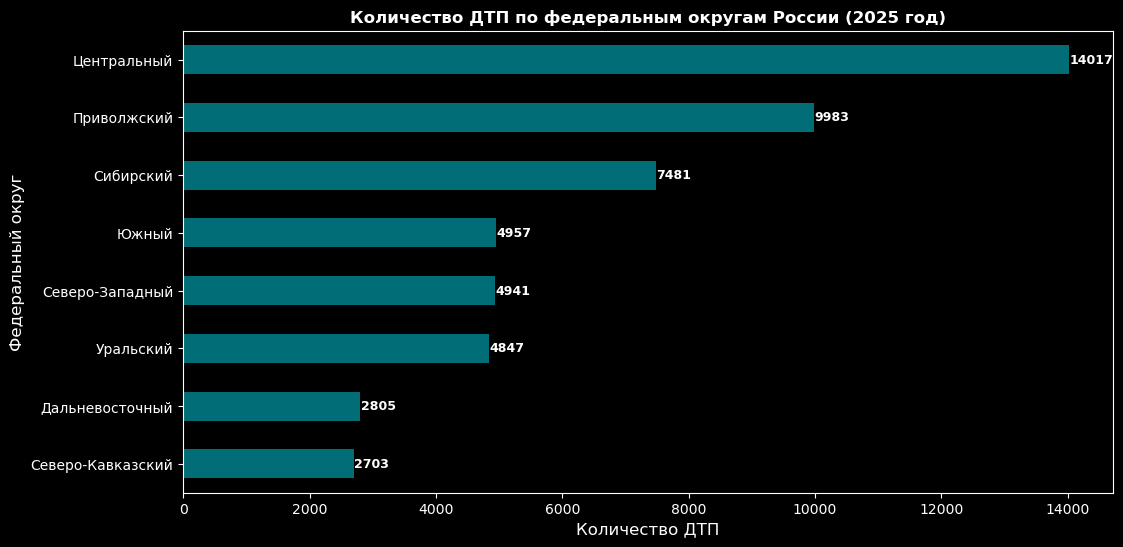

In [169]:
district_accidents = gdf[gdf['year'] == 2025].groupby('federal_district')['id'].nunique().sort_values(ascending=True)

plt.figure(figsize=(12, 6))
district_accidents.plot(kind='barh', color='#006d77')

for i, value in enumerate(district_accidents.values):
    plt.text(value+5, i, f'{value}', va='center', fontweight='bold', fontsize=9)

plt.title('Количество ДТП по федеральным округам России (2025 год)', fontweight='bold')
plt.xlabel('Количество ДТП', fontsize=12)
plt.ylabel('Федеральный округ', fontsize=12)

plt.show()

Посмотрим распределение дтп за период 2015 - 2025

In [171]:
gdf['id'].nunique()

1465882

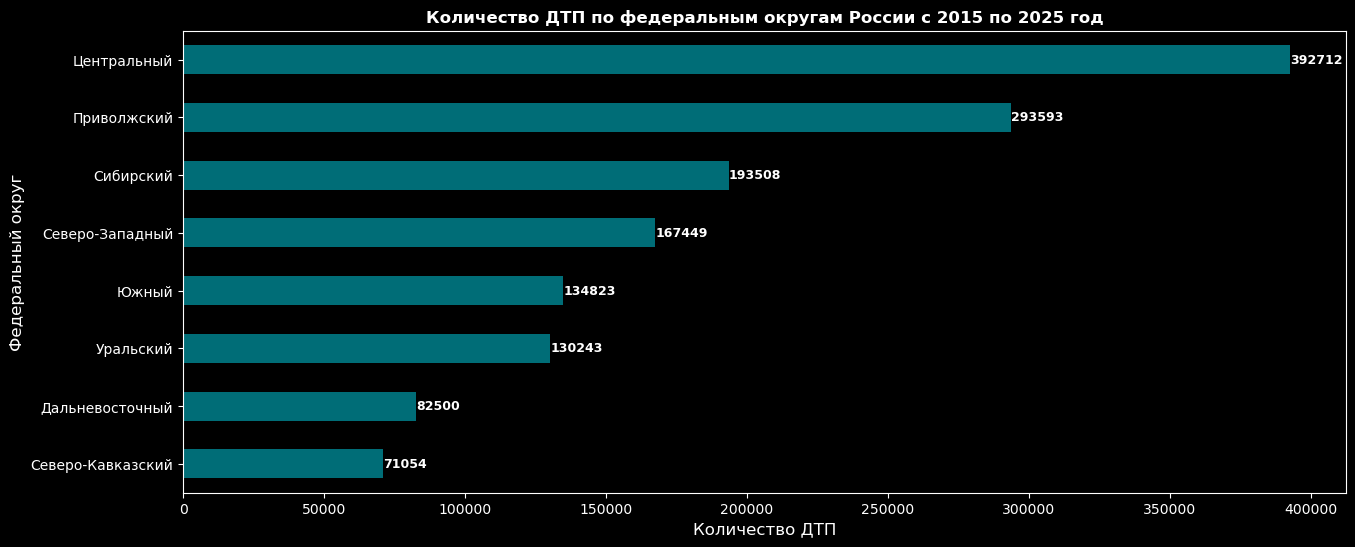

In [172]:
district_accidents = gdf.groupby('federal_district')['id'].nunique().sort_values(ascending=True)

plt.figure(figsize=(15, 6))
district_accidents.plot(kind='barh', color='#006d77')

for i, value in enumerate(district_accidents.values):
    plt.text(value+5, i, f'{value}', va='center', fontweight='bold', fontsize=9)

plt.title('Количество ДТП по федеральным округам России с 2015 по 2025 год', fontweight='bold')
plt.xlabel('Количество ДТП', fontsize=12)
plt.ylabel('Федеральный округ', fontsize=12)

plt.show()

По количеству распределение практически не изменилось за все время и конкретно за 2025 год, все также лидирует Центральный округ, а меньше всего в Северо-Кавказском

Посмотрим распределение дтп на 100 тысяч населения. перед этим преобразуем наш датафрейм с населением для дальнейшей работы из "широкого" в "длинный" формат

In [175]:
population_long = population_df.melt(
    id_vars=['Регион России', 'Федеральный округ'],
    value_vars=[str(year) for year in range(2015, 2025)], 
    var_name='year',
    value_name='population'
)

population_long['year'] = population_long['year'].astype(int)

population_fd = population_long.groupby(['Федеральный округ', 'year'])['population'].sum().reset_index()

In [176]:
# Считаем количество дтп по годам и федеральным округам
accidents_fd = gdf.groupby(['federal_district', 'year'])['id'].nunique().reset_index(name='accidents')

In [177]:
# Объединяем население и количество дтп по округам
df_rate = accidents_fd.merge(
    population_fd, 
    left_on=['federal_district', 'year'], 
    right_on=['Федеральный округ', 'year'],
    how='inner'  
)

df_rate = df_rate.drop('Федеральный округ', axis=1, errors='ignore')

df_rate['accidents_per_100k'] = df_rate['accidents'] / df_rate['population'] * 100

In [178]:
df_sort = df_rate.groupby('federal_district')['accidents_per_100k'].agg('mean').astype('int').reset_index().sort_values(by='accidents_per_100k', ascending=True)

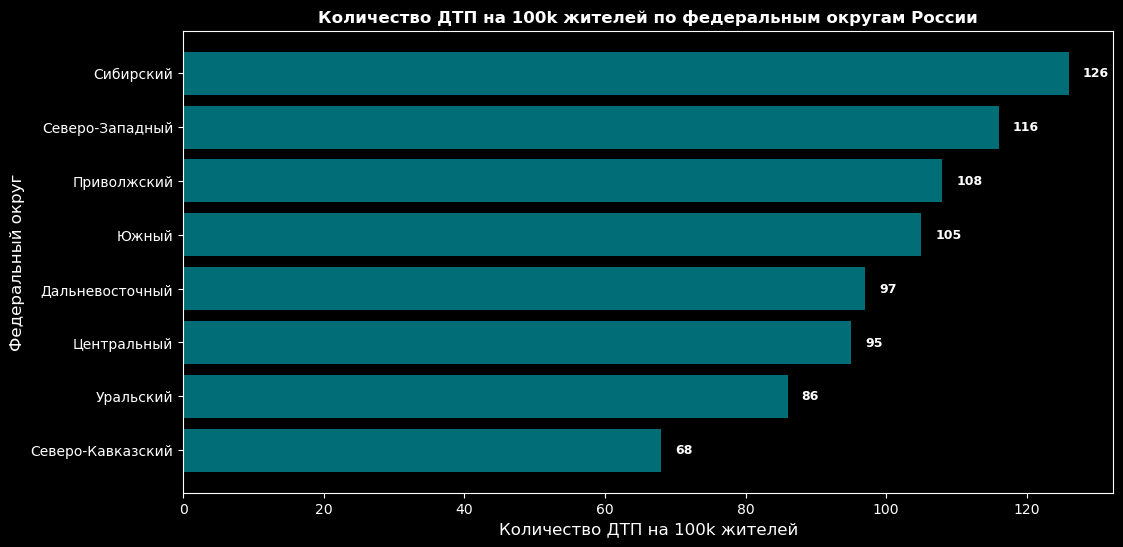

In [179]:
plt.figure(figsize=(12, 6))
plt.barh(df_sort['federal_district'], df_sort['accidents_per_100k'], color='#006d77')

for i, value in enumerate(df_sort['accidents_per_100k']):
    plt.text(value + 2, i, f'{value}', va='center', fontweight='bold', fontsize=9)

plt.title('Количество ДТП на 100k жителей по федеральным округам России', fontweight='bold')
plt.xlabel('Количество ДТП на 100k жителей', fontsize=12)
plt.ylabel('Федеральный округ', fontsize=12)

plt.show()

Лидирует по числу дтп в среднем за период на 100к населения Сибирский и Северо-Западный округ (126 и 116 соотвественно), меньше всего дтп все также в Северо-Кавказском 68.

Посмотрим количество дтп на 100к жителей в 2025 году. Но данные по жителям возьмем за 2024 год.

In [182]:
accidents_fd = gdf[gdf['year'] == 2025].groupby('federal_district')['id'].nunique().reset_index(name='accidents')

population_fd = population_df.groupby('Федеральный округ')['2024'].sum().reset_index(name='population')

df_rate = accidents_fd.merge(population_fd, left_on = 'federal_district', right_on='Федеральный округ')

df_rate['accidents_per_100k'] = df_rate['accidents'] / df_rate['population'] * 100

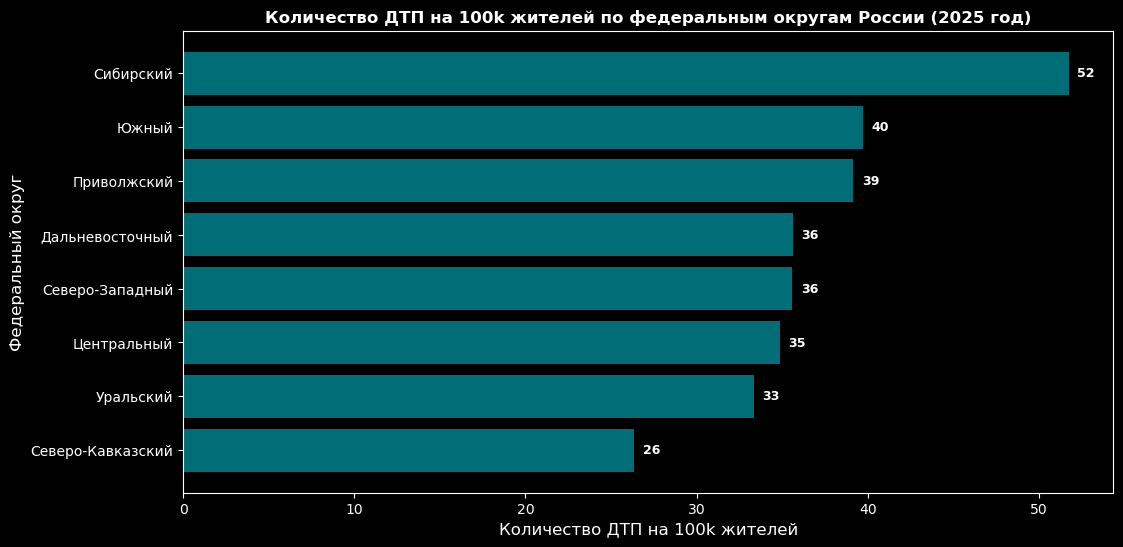

In [183]:
df_sort = df_rate.sort_values(by='accidents_per_100k', ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(df_sort['federal_district'], df_sort['accidents_per_100k'], color='#006d77')

for i, value in enumerate(df_sort['accidents_per_100k']):
    plt.text(value + 0.5, i, f'{value:.0f}', va='center', fontweight='bold', fontsize=9)

plt.title('Количество ДТП на 100k жителей по федеральным округам России (2025 год)', fontweight='bold')
plt.xlabel('Количество ДТП на 100k жителей', fontsize=12)
plt.ylabel('Федеральный округ', fontsize=12)

plt.show()

В перерасчете на 100 тысяч населения лидируют Сибирский 52 дтп на 100к населения, а меньше всего все также в Северо-Кавказском 26.

Посмотрим топ-10 регионов по количеству аварий в 2025 г

In [186]:
gdf[gdf['year'] == 2025].groupby('parent_region')['id'].nunique().sort_values(ascending=False).head(10)

parent_region
Москва                              3679
Краснодарский край                  2467
Челябинская область                 1653
Московская область                  1591
Самарская область                   1489
Санкт-Петербург                     1475
Республика Татарстан (Татарстан)    1411
Новосибирская область               1397
Красноярский край                   1315
Республика Башкортостан             1262
Name: id, dtype: int64

Посмотрим топ-10 регионов по количеству аварий на 100 тысяч населения в 2025 г

In [188]:
accidents_rf = gdf[gdf['year'] == 2025].groupby('parent_region')['id'].nunique().reset_index(name='accidents')

population_rd = population_df.groupby('Регион России')['2024'].sum().reset_index(name='population')

df_rate = accidents_rf.merge(population_rd, left_on = 'parent_region', right_on='Регион России')

df_rate['accidents_per_100k'] = df_rate['accidents'] / df_rate['population'] * 100

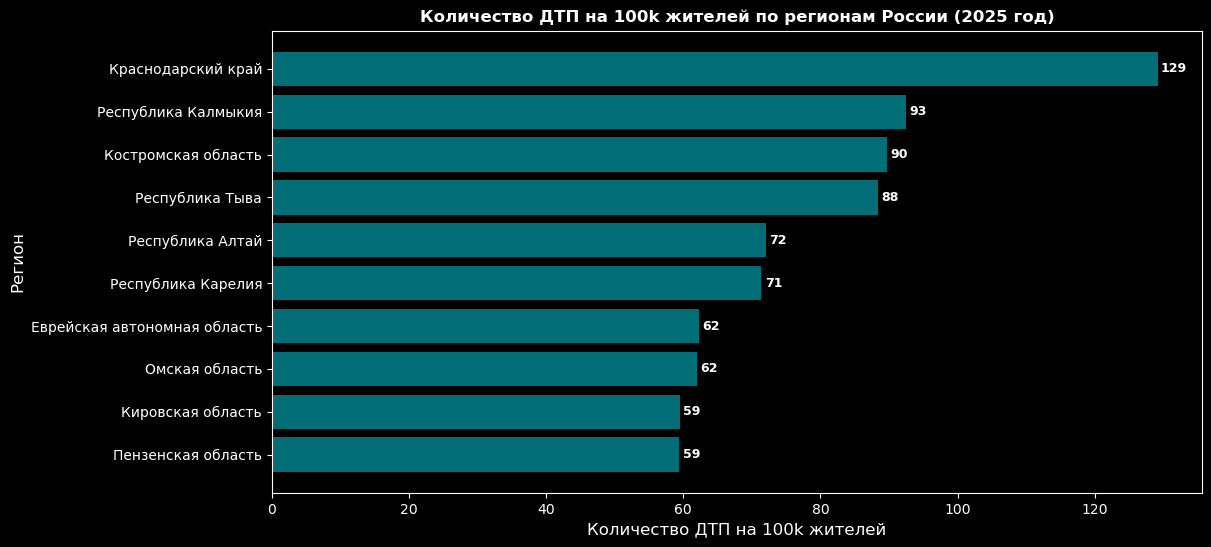

In [189]:
df_sort = df_rate.sort_values(by='accidents_per_100k', ascending=False).head(10)
df_sort = df_sort.sort_values(by='accidents_per_100k', ascending=True)
plt.figure(figsize=(12, 6))
plt.barh(df_sort['parent_region'], df_sort['accidents_per_100k'], color='#006d77')

for i, value in enumerate(df_sort['accidents_per_100k']):
    plt.text(value + 0.5, i, f'{value:.0f}', va='center', fontweight='bold', fontsize=9)

plt.title('Количество ДТП на 100k жителей по регионам России (2025 год)', fontweight='bold')
plt.xlabel('Количество ДТП на 100k жителей', fontsize=12)
plt.ylabel('Регион', fontsize=12)

plt.show()

В 2025 году по количеству лидирует Москва - 3679 дтп, Краснодарский край - 2467 дтп. По количеству аварий на 100 тысяч населения лидирует Краснодарский край - 129 дтп. Краснодарский край, Алтай, Карелия популярные туристические направления, есть вероятность, что высокие значения по дтп в том числе обусловлены этим.

## Тепловая карта аварий в 2025 году

В правом верхнем углу карты есть переключатель слоев, он переключает между всеми участниками, пострадавшими и погибшими. Сейчас включены все три слоя. Если он не отобразился, скройте/откройте карту или выполните снова ячейку с кодом

In [193]:
gdf_hm = gdf[gdf['year'] == 2025].copy()
gdf_hm['lon'] = gdf_hm.geometry.x
gdf_hm['lat'] = gdf_hm.geometry.y

# Базовая карта 
center = [gdf_hm['lat'].mean(), gdf_hm['lon'].mean()]
m = folium.Map(location=center, zoom_start=3, tiles='CartoDB positron')

# Функция для генерации heatmap слоя 
def add_heatmap(data, value_col, name, map_obj):
    points = data[['lat', 'lon', value_col]].dropna().values.tolist()
    HeatMap(
        points,
        radius=15,
        blur=12,
        min_opacity=0.4,
        max_zoom=15,
        gradient={0.2: 'blue', 0.4: 'green', 0.6: 'yellow', 0.8: 'orange', 1.0: 'red'}
    ).add_to(folium.FeatureGroup(name=name).add_to(map_obj))

# Добавляем разные слои 
add_heatmap(gdf_hm, 'dead_count', 'Погибшие', m)
add_heatmap(gdf_hm, 'injured_count', 'Раненые', m)
add_heatmap(gdf_hm, 'participants_count', 'Все участники', m)

# Переключатель слоёв 
folium.LayerControl().add_to(m)

m

## Распределение аварий по годам

Исключим 2025 год, т.к. он не полный и будет резкое падение

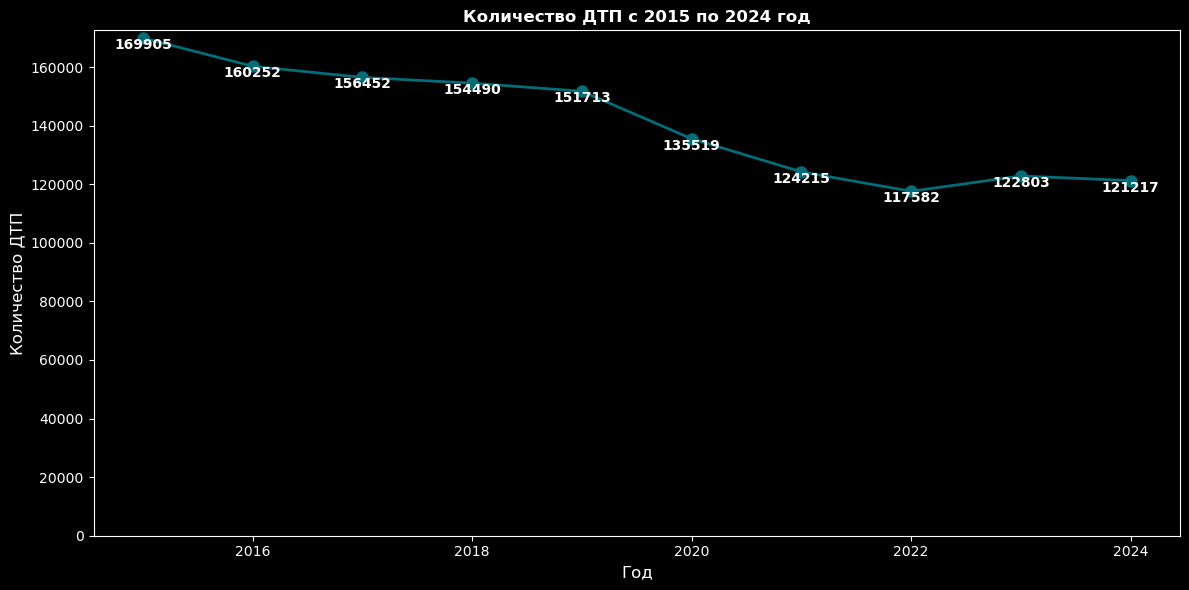

In [196]:
year_accidents = gdf[gdf['year'] != 2025]['year'].value_counts()
year_accidents = year_accidents.sort_index()

plt.figure(figsize=(12, 6))
plt.plot(year_accidents.index, year_accidents.values,
         marker='o',
         linewidth=2,
         markersize=8,
         markerfacecolor='#006d77',
         color='#006d77')

for year, count in year_accidents.items():
    plt.text(year, count + 5, f'{count}',
             ha='center', va='top', fontweight='bold')


plt.title('Количество ДТП с 2015 по 2024 год', fontweight='bold')
plt.xlabel('Год', fontsize=12)
plt.ylabel('Количество ДТП', fontsize=12)
plt.ylim(0, None)
plt.tight_layout()
plt.show()

В целом виден тренд уменьшения дтп в течение 10 лет.
В декабре 2018 года был запущен Национальный проект «Безопасные и качественные автомобильные дороги», на графике хорошо виден резкий спад в 2019 году

## Распределение аварий по месяцам

Посмотрим как аварии распределены по месяцам в 2025 году

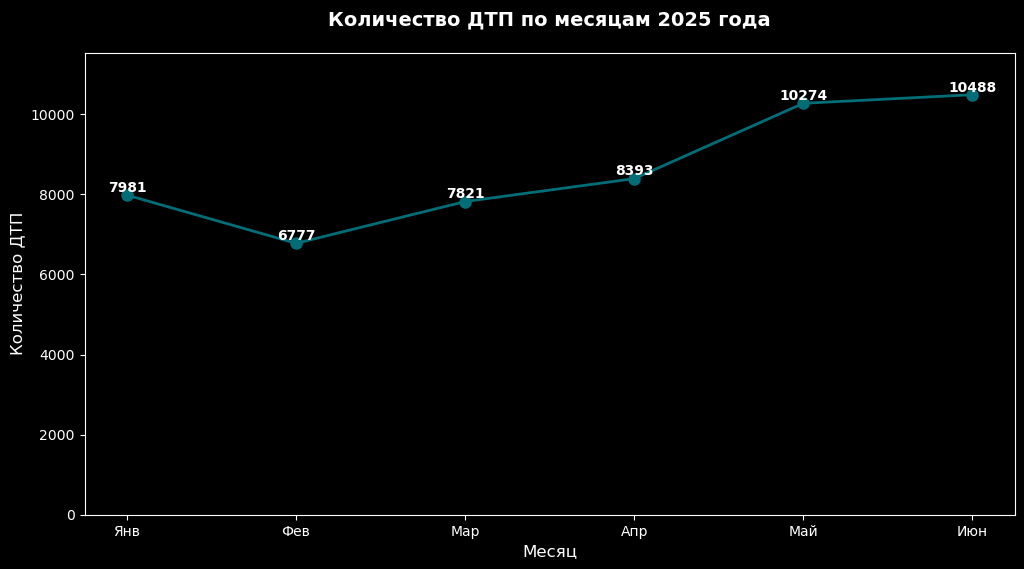

In [200]:
month_accidents = gdf[gdf['year'] == 2025]['month'].value_counts()

month_accidents = month_accidents.sort_index()

plt.figure(figsize=(12, 6))
plt.plot(month_accidents.index, month_accidents.values,
         marker='o',
         linewidth=2,
         markersize=8,
         markerfacecolor='#006d77',
         color='#006d77')

for month, count in month_accidents.items():
    plt.text(month, count + 5, f'{count}',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# Настраиваем подписи оси X (названия месяцев на русском)
month_names = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн']
plt.xticks(range(1, 7), month_names)

plt.title('Количество ДТП по месяцам 2025 года', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Количество ДТП', fontsize=12)
plt.ylim(0, month_accidents.max() * 1.1)
plt.show()

Количество аварий растет в течение 2025 года, больше всего аварий приходится на данный момент на летние месяцы

Посмотрим распределение дтп по месяцам за все время

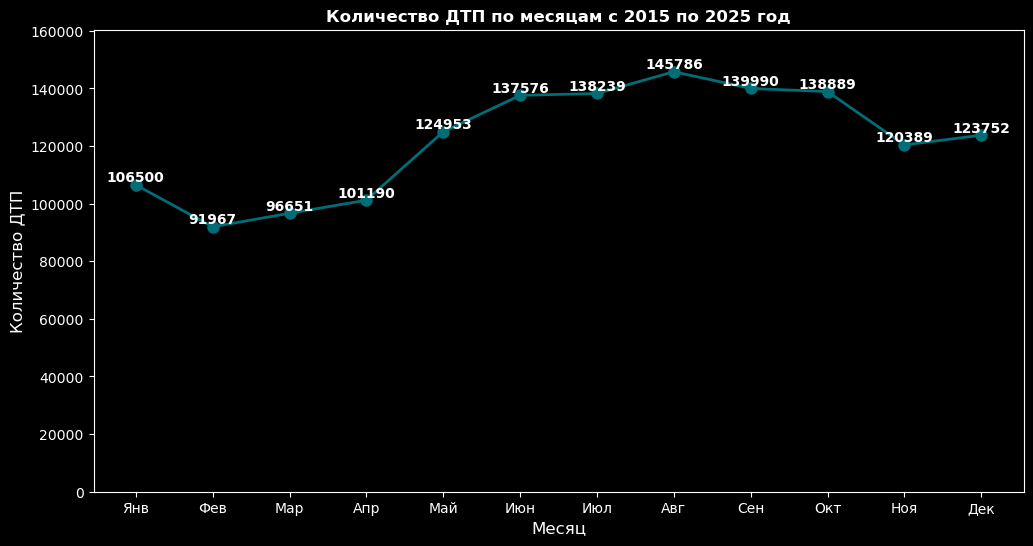

In [203]:
month_accidents = gdf['month'].value_counts()

month_accidents = month_accidents.sort_index()

plt.figure(figsize=(12, 6))
plt.plot(month_accidents.index, month_accidents.values,
         marker='o',
         linewidth=2,
         markersize=8,
         markerfacecolor='#006d77',
         color='#006d77')

for month, count in month_accidents.items():
    plt.text(month, count + 5, f'{count}',
             ha='center', va='bottom', fontweight='bold')

# Настраиваем подписи оси X (названия месяцев на русском)
month_names = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']
plt.xticks(range(1, 13), month_names)

plt.title('Количество ДТП по месяцам с 2015 по 2025 год', fontweight='bold')
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Количество ДТП', fontsize=12)
plt.ylim(0, month_accidents.max() * 1.1)

plt.show()

За период с 2015 по 2025 год количество дтп возрастает с середины апреля по середину октября, имея пик в летние месяцы.

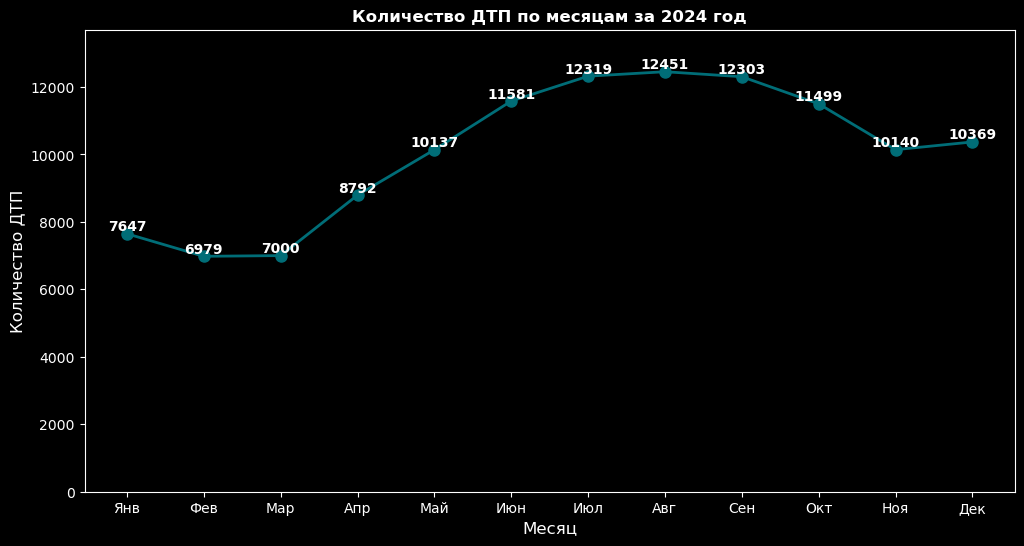

In [205]:
month_accidents = gdf[gdf['year'] == 2024]['month'].value_counts()

month_accidents = month_accidents.sort_index()

plt.figure(figsize=(12, 6))
plt.plot(month_accidents.index, month_accidents.values,
         marker='o',
         linewidth=2,
         markersize=8,
         markerfacecolor='#006d77',
         color='#006d77')

for month, count in month_accidents.items():
    plt.text(month, count + 5, f'{count}',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# Настраиваем подписи оси X (названия месяцев на русском)
month_names = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']
plt.xticks(range(1, 13), month_names)

plt.title('Количество ДТП по месяцам за 2024 год', fontweight='bold')
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Количество ДТП', fontsize=12)
plt.ylim(0, month_accidents.max() * 1.1)

plt.show()

Количество дтп возрастает с марта и держится высоко до самого сентября. Такая же ситуация если смотреть по всем годам. Это не удивительно, погода становиться лучше, больше транспорта появляется на дорогах. 

## Сравнение количества дтп за период с января по июнь по годам

Т.к. 2025 год не полный, мы сравним период с таким же периодом в других годах

In [209]:
max_date_2025 = gdf[gdf['year'] == 2025]['datetime'].max()
max_date_2025

Timestamp('2025-06-30 23:10:00')

Создадим датафрейм, где будет 2 столбца: год и количество дтп за период с января по июнь

In [211]:
results = []
years = list(gdf['year'].unique())

for year in years:
    start_date = f'{year}-01-01'
    end_date = f'{year}-06-30'  
    
    accident_count = gdf[(gdf['datetime'] >= start_date) & (gdf['datetime'] <= end_date)]['id'].nunique()
    
    results.append({'Год': year, 'Количество ДТП': accident_count})

results_df = pd.DataFrame(results)
results_df['Год'] = results_df['Год'].astype(int)

results_df = results_df.sort_values(by='Год')

Построим линейный график

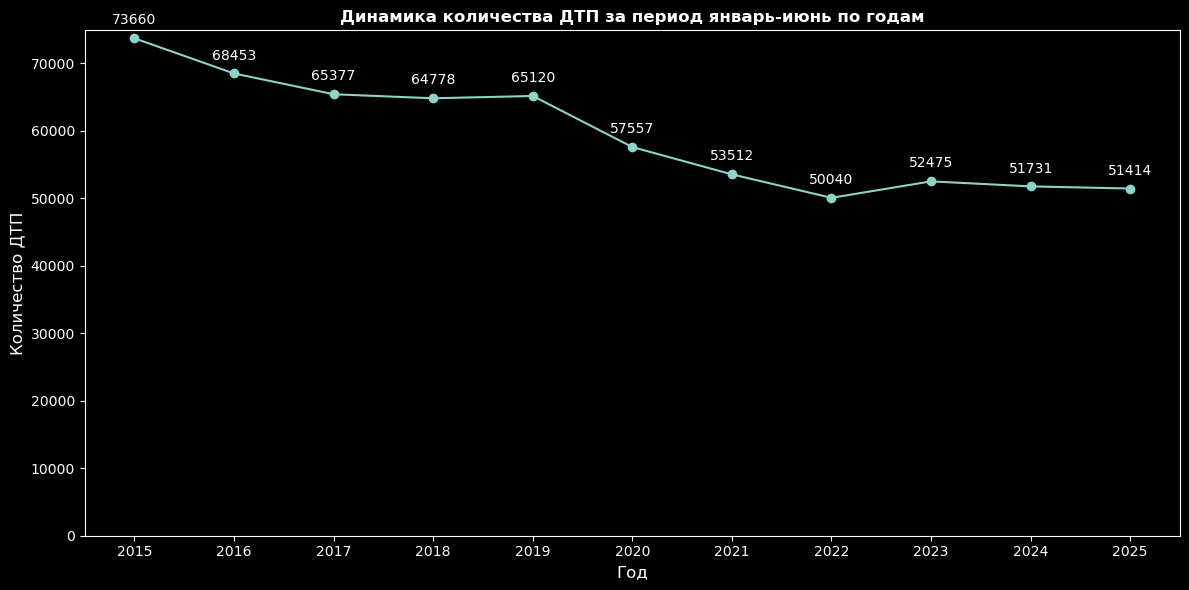

In [213]:
plt.figure(figsize=(12, 6))
plt.plot(results_df['Год'], results_df['Количество ДТП'], marker='o')

for i, row in results_df.iterrows():
    plt.annotate(row['Количество ДТП'], 
                 (row['Год'], row['Количество ДТП']),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')

plt.title('Динамика количества ДТП за период январь-июнь по годам', fontweight='bold')
plt.xlabel('Год', fontsize=12)
plt.ylabel('Количество ДТП', fontsize=12)
plt.xticks(years) 

plt.ylim(0, None)
plt.tight_layout()
plt.show()

Количество дтп за период с января по июнь снижается с 2015 по 2025 год

## Сравнение количества участников, пострадавших и погибших за период с января по июнь по годам

Создадим как и раньше датафрейм с данными по участникам, пострадавшим и погибшим

In [217]:
results = []
years = list(gdf['year'].unique())

for year in years:
    start_date = f'{year}-01-01'
    end_date = f'{year}-06-30'  
    
    participants, injured, dead = gdf[(gdf['datetime'] >= start_date) & (gdf['datetime'] <= end_date)][['participants_count', 'injured_count', 'dead_count']].sum()
    
    results.append({'Год': year, 'Участники ДТП': participants, 'Пострадавшие': injured, 'Погибшие': dead})

results_df = pd.DataFrame(results)
results_df['Год'] = results_df['Год'].astype(int)

results_df = results_df.sort_values(by='Год')

Построим график

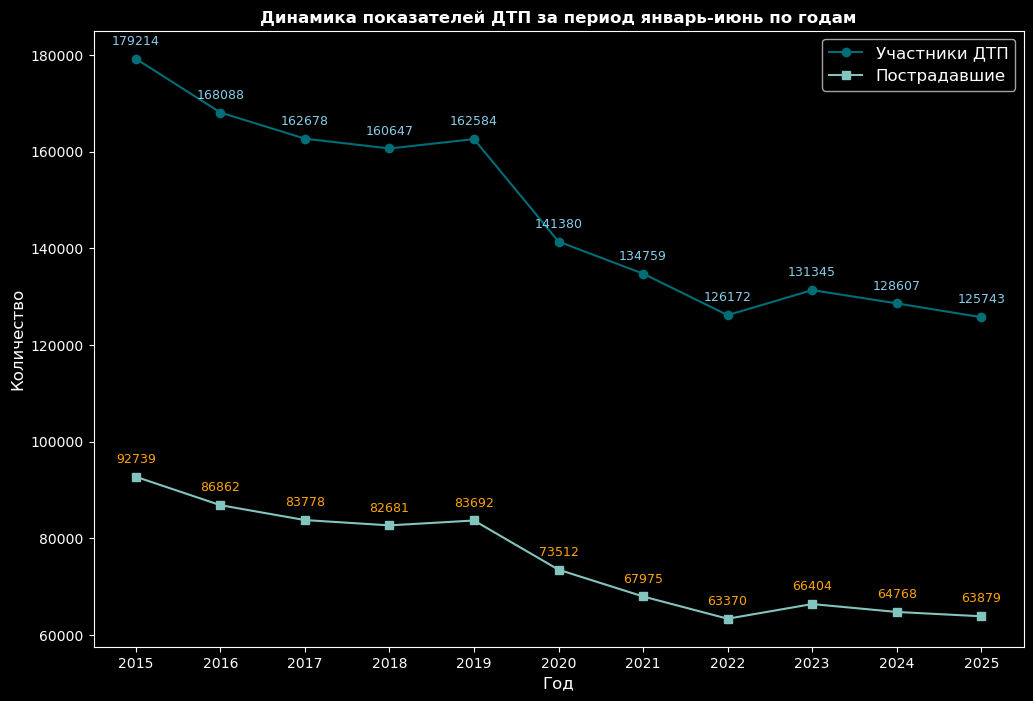

In [219]:
plt.figure(figsize=(12, 8))

plt.plot(results_df['Год'], results_df['Участники ДТП'], 
         marker='o', label='Участники ДТП', color='#006d77')

plt.plot(results_df['Год'], results_df['Пострадавшие'], 
         marker='s', label='Пострадавшие', color='#83c5be')

plt.title('Динамика показателей ДТП за период январь-июнь по годам', fontweight='bold')
plt.xlabel('Год', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.legend(fontsize=12)
plt.xticks(results_df['Год'])

for _, row in results_df.iterrows():
    plt.annotate(row['Участники ДТП'], (row['Год'], row['Участники ДТП']), 
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, color='skyblue')
    plt.annotate(row['Пострадавшие'], (row['Год'], row['Пострадавшие']), 
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, color='orange')

plt.show()

Хорошо виден спад, который начался в 2019 году, в это же время как раз начали реализовывать Национальный проект «Безопасные и качественные автомобильные дороги».

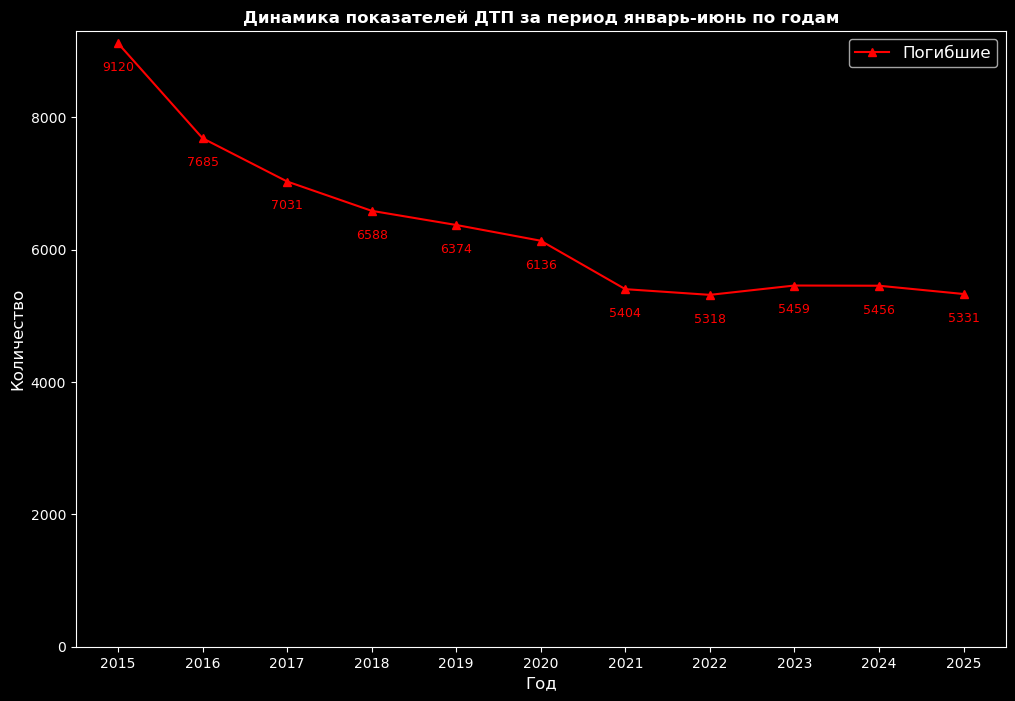

In [221]:
plt.figure(figsize=(12, 8))
plt.plot(results_df['Год'], results_df['Погибшие'], 
         marker='^', label='Погибшие', color='red')

plt.title('Динамика показателей ДТП за период январь-июнь по годам', fontweight='bold')
plt.xlabel('Год', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.legend(fontsize=12)
plt.xticks(results_df['Год'])

for _, row in results_df.iterrows():
    plt.annotate(row['Погибшие'], (row['Год'], row['Погибшие']), 
                 textcoords="offset points", xytext=(0,-20), ha='center', fontsize=9, color='red')
plt.ylim(0, None)
plt.show()

Количество участников, пострадавших и погибших также снижается

## Распределение степени тяжести аварии за 2025 год

In [224]:
gdf[gdf['year'] == 2025]['severity'].value_counts()

severity
Легкий         31107
Тяжёлый        16035
С погибшими     4592
Name: count, dtype: int64

In [225]:
gdf[gdf['year'] == 2025]['severity'].value_counts(normalize=True)

severity
Легкий        0.60
Тяжёлый       0.31
С погибшими   0.09
Name: proportion, dtype: float64

60% составляют легкие случаи, 31% тяжелые и 9% случаи с погибшими

Посмотрим за все время с 2015 по 2025 год

In [228]:
gdf['severity'].value_counts()

severity
Легкий         829755
Тяжёлый        495775
С погибшими    140352
Name: count, dtype: int64

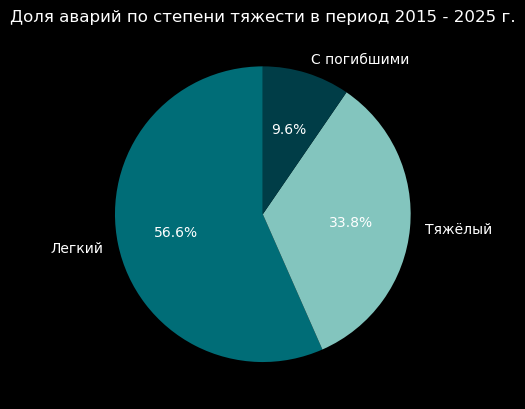

In [229]:
gdf['severity'].value_counts(normalize=True).plot(kind='pie',
                   autopct='%1.1f%%',
                   startangle=90,
                   colors=['#006d77', '#83c5be', '#003d47'],
                   title='Доля аварий по степени тяжести в период 2015 - 2025 г.')

plt.ylabel('')
plt.show()

Распределение дтп по степени тяжести практически остается тем же, 57% легкие случаи, 34%  тяжелые и 10% случаи с погибшими

## Распределение ДТП по дню недели

Зададим правильный порядок дней недели

In [233]:
correct_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

gdf['day_of_week'] = pd.Categorical(gdf['day_of_week'], categories=correct_order, ordered=True)

Построим график за 2025 год для пострадавших и участников и отдельный график для погибших, там меньше значения и будет легче увидеть разницу по дням

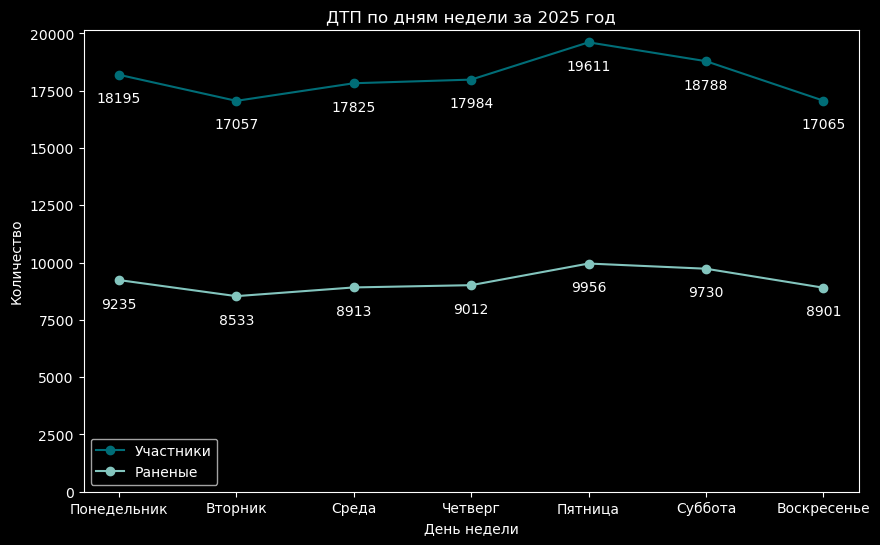

In [235]:
summary = gdf[gdf['year'] == 2025].groupby('day_of_week', observed=False)[['participants_count', 'injured_count', 'dead_count']].sum()

plt.figure(figsize=(10,6))

plt.plot(summary.index, summary['participants_count'], marker='o', label='Участники', color='#006d77')
plt.plot(summary.index, summary['injured_count'], marker='o', label='Раненые', color='#83c5be')

for i, row in summary.iterrows():
    plt.annotate(row['participants_count'], (i, row['participants_count']),
                 textcoords="offset points", xytext=(0,-20), ha='center')
    plt.annotate(row['injured_count'], (i, row['injured_count']),
                 textcoords="offset points", xytext=(0,-20), ha='center')
    
day_names = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
plt.xticks(range(0, 7), day_names)

plt.title("ДТП по дням недели за 2025 год")
plt.xlabel("День недели")
plt.ylabel("Количество")
plt.legend()
plt.ylim(0, None)
plt.show()

Больше всего ДТП в пятницу, посмотрим глубже и посмотрим распределение ДТП по часам по пятницам за период 2015-2025

Создадим столбец с информацией в каком часу произошло дтп

In [238]:
gdf['hour'] = gdf['datetime'].dt.hour

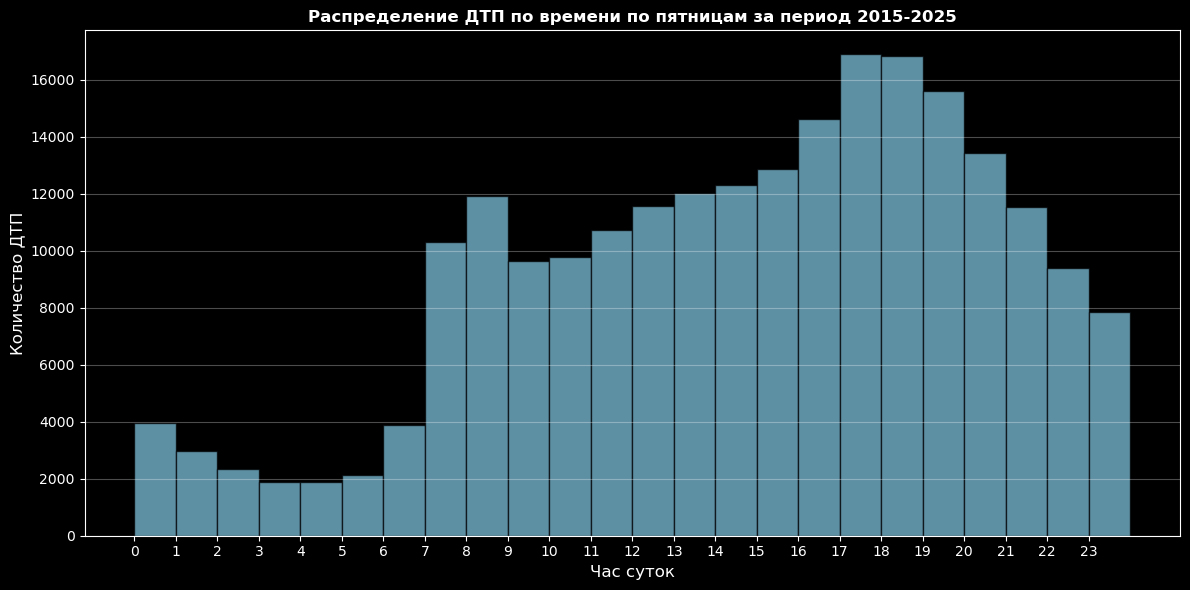

In [239]:
plt.figure(figsize=(12, 6))
plt.hist(gdf[gdf['day_of_week'] == 'Friday']['hour'].dropna(), bins=24, range=(0, 24), 
         edgecolor='black', alpha=0.7, color='skyblue')

plt.title('Распределение ДТП по времени по пятницам за период 2015-2025', fontweight='bold')
plt.xlabel('Час суток', fontsize=12)
plt.ylabel('Количество ДТП', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Есть пики количества ДТП в утренние часы, когда все едут на работу и в вечерние часы, когда все едут с работы

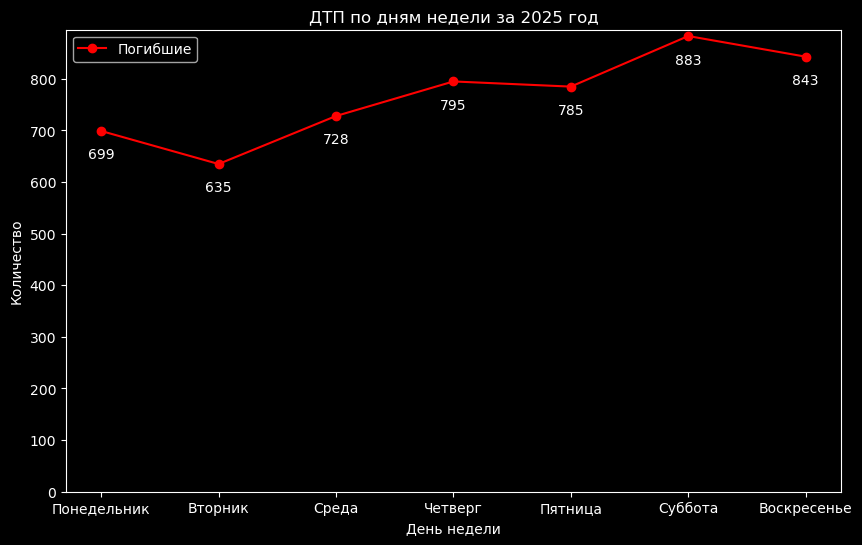

In [241]:
plt.figure(figsize=(10,6))

plt.plot(summary.index, summary['dead_count'], marker='o', label='Погибшие', color='red')


for i, row in summary.iterrows():
    plt.annotate(row['dead_count'], (i, row['dead_count']),
                 textcoords="offset points", xytext=(0,-20), ha='center')

day_names = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
plt.xticks(range(0, 7), day_names)

plt.title("ДТП по дням недели за 2025 год")
plt.xlabel("День недели")
plt.ylabel("Количество")
plt.legend()
plt.ylim(0, None)
plt.show()

Количество участников и постродавших пик приходится на пятницу, погибших же пи приходистя на субботу и в целом растет в течение недели

Посмотрим как распределяются погибшие по всем годам

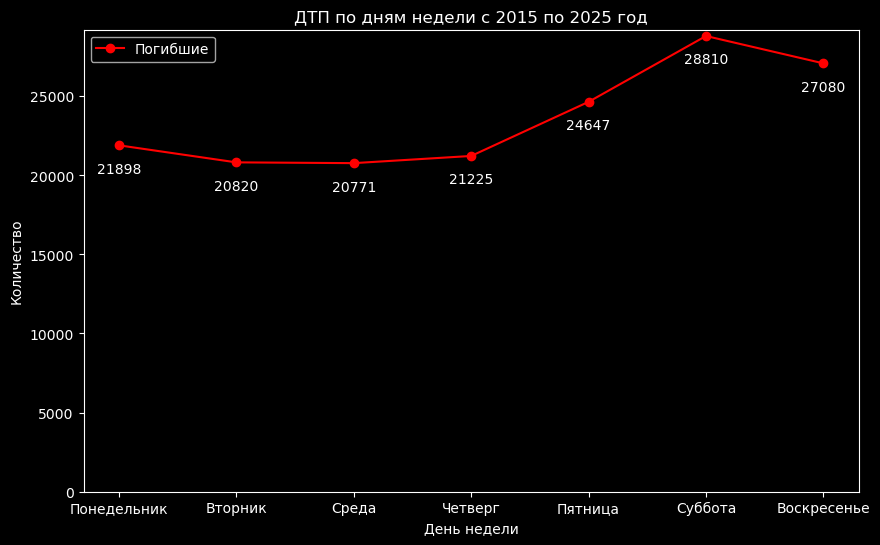

In [244]:
summary = gdf.groupby('day_of_week', observed=False)[['participants_count', 'injured_count', 'dead_count']].sum()

plt.figure(figsize=(10,6))

plt.plot(summary.index, summary['dead_count'], marker='o', label='Погибшие', color='red')


for i, row in summary.iterrows():
    plt.annotate(row['dead_count'], (i, row['dead_count']),
                 textcoords="offset points", xytext=(0,-20), ha='center')

day_names = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
plt.xticks(range(0, 7), day_names)

plt.title("ДТП по дням недели с 2015 по 2025 год")
plt.xlabel("День недели")
plt.ylabel("Количество")
plt.legend()
plt.ylim(0, None)
plt.show()

За период с 2015 по 2025 год количество смертельных дтп растет с четверга по субботу, с пиков в субботу. 

Добавим еще один столбец выходный или будни этот день и посмотрим как распределяются данные там

In [247]:
gdf['day_type'] = gdf['day_of_week'].map(lambda d: 'Выходной' if d in ['Saturday', 'Sunday'] else 'Будни')

In [248]:
gdf[gdf['year'] == 2025]['day_type'].value_counts()

day_type
Будни       37402
Выходной    14332
Name: count, dtype: int64

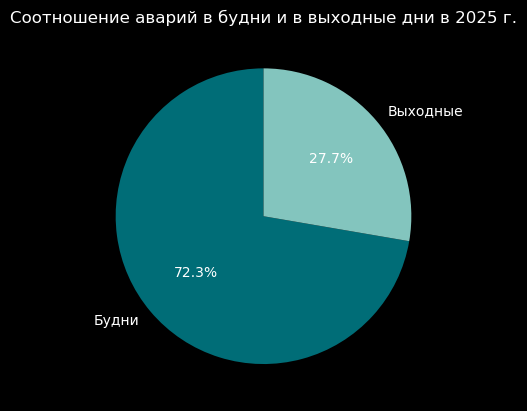

In [249]:
day_type_gr = gdf[gdf['year'] == 2025]['day_type'].value_counts(normalize=True)
day_type_gr.plot(kind='pie',
               autopct='%1.1f%%',
               startangle=90,   
               colors=['#006d77', '#83c5be'],
               title='Соотношение аварий в будни и в выходные дни в 2025 г.',
               labels=['Будни', 'Выходные']
)

plt.ylabel('') 

plt.show()

Посмотрим как распределяются за все года

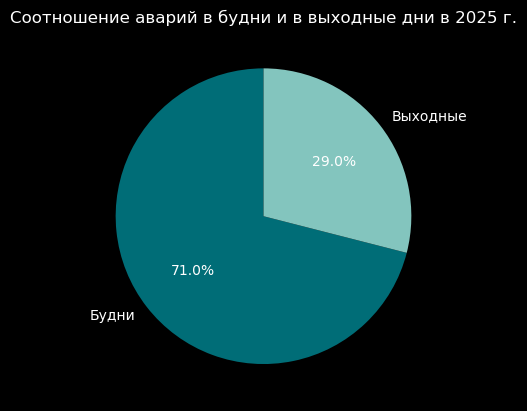

In [251]:
day_type_gr = gdf['day_type'].value_counts(normalize=True)
day_type_gr.plot(kind='pie',
               autopct='%1.1f%%',
               startangle=90,   
               colors=['#006d77', '#83c5be'],
               title='Соотношение аварий в будни и в выходные дни в 2025 г.',
               labels=['Будни', 'Выходные']
)

plt.ylabel('') 

plt.show()

In [252]:
gdf[gdf['year'] == 2025].groupby('day_type')[['participants_count', 'injured_count', 'dead_count']].sum()

participants_count  injured_count  dead_count
day_type                                               
Будни                  90672          45649        3642
Выходной               35853          18631        1726

В 2025 в будни происходит 72.3%  дтп, в выходные 27.7%. За период 2015-2025 распределение похоже, в будни происходит 71%  дтп, в выходные 29%, почти треть всех дтп происходит в выходные.

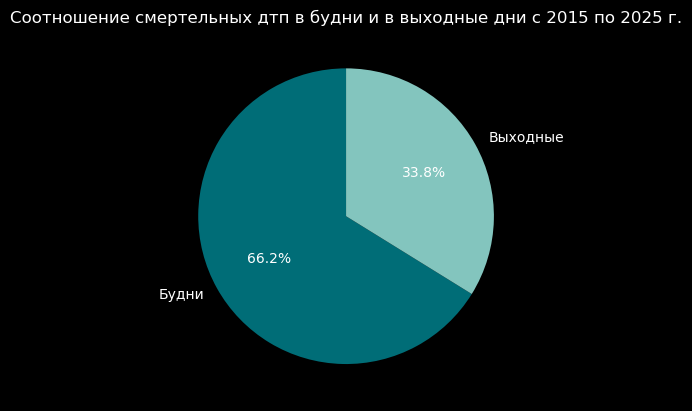

In [254]:
day_type_gr = gdf.groupby('day_type')['dead_count'].sum()
day_type_gr.plot(kind='pie',
               autopct='%1.1f%%',
               startangle=90,   
               colors=['#006d77', '#83c5be'],
               title='Соотношение смертельных дтп в будни и в выходные дни с 2015 по 2025 г.',
               labels=['Будни', 'Выходные']
)

plt.ylabel('') 

plt.show()

Каждая третья смертельная авария была в выходные

## Распределение аварий по времени суток

Посмотрим как распределено количество дтп в 2025 году

In [258]:
gdf[gdf['year'] == 2025]['light'].value_counts()

light
Светлое время суток                            35326
В темное время суток, освещение включено       10656
В темное время суток, освещение отсутствует     4102
Сумерки                                         1275
В темное время суток, освещение не включено      372
Не установлено                                     3
Name: count, dtype: int64

In [259]:
gdf[gdf['year'] == 2025]['light'].value_counts(normalize=True)

light
Светлое время суток                           0.68
В темное время суток, освещение включено      0.21
В темное время суток, освещение отсутствует   0.08
Сумерки                                       0.02
В темное время суток, освещение не включено   0.01
Не установлено                                0.00
Name: proportion, dtype: float64

Больше всего дтп происходит в светлое время суток 68 процентов, на втором месте темное время суток когда освещение включено 21 процент, меньше всего количество дтп в темное время когда освещение не включено

Посмотрим как распределены дтп по всем годам

In [262]:
gdf['light'].value_counts(normalize=True)

light
Светлое время суток                           0.63
В темное время суток, освещение включено      0.22
В темное время суток, освещение отсутствует   0.11
Сумерки                                       0.03
В темное время суток, освещение не включено   0.01
Не установлено                                0.00
Name: proportion, dtype: float64

В целом очень похоже с 2025 годом, светлое время лидирует

Посмотрим как распределены количество участников дтп, пострадавших и погивших по времени суток, отсортируем по столбцу с погибшими

In [265]:
gdf[gdf['year'] == 2025].groupby('light')[['participants_count', 'injured_count', 'dead_count']].sum().sort_values(by='dead_count', ascending=False)

participants_count  \
light                                                             
Светлое время суток                                       86531   
В темное время суток, освещение отсутствует                9961   
В темное время суток, освещение включено                  26137   
Сумерки                                                    3024   
В темное время суток, освещение не включено                 865   
Не установлено                                                7   

                                             injured_count  dead_count  
light                                                                   
Светлое время суток                                  43713        3028  
В темное время суток, освещение отсутствует           5213        1130  
В темное время суток, освещение включено             13333         976  
Сумерки                                               1605         130  
В темное время суток, освещение не включено            412         104  
Не установлено                                           4           0

Достаточно большое количество погибших в темное время суток когда освещение отсутствует, особенно если сравнить с общим количеством участников по этой категории, рассмотрим подробнее этот момент

In [267]:
dead_people_df = (
    gdf[gdf['year'] == 2025]
    .groupby('light')
    .agg({
        'participants_count': 'sum',  # всего участников
        'dead_count': 'sum',          # всего погибших
        'injured_count': 'sum'        # всего пострадавших
    })
)

dead_people_df['fatal_share'] = dead_people_df['dead_count'] / dead_people_df['participants_count']
dead_people_df.sort_values(by='fatal_share', ascending=False)

participants_count  dead_count  \
light                                                                         
В темное время суток, освещение не включено                 865         104   
В темное время суток, освещение отсутствует                9961        1130   
Сумерки                                                    3024         130   
В темное время суток, освещение включено                  26137         976   
Светлое время суток                                       86531        3028   
Не установлено                                                7           0   

                                             injured_count  fatal_share  
light                                                                    
В темное время суток, освещение не включено            412         0.12  
В темное время суток, освещение отсутствует           5213         0.11  
Сумерки                                               1605         0.04  
В темное время суток, освещение включено             13333         0.04  
Светлое время суток                                  43713         0.03  
Не установлено                                           4         0.00

Доля погибших среди участников 12% в темное время суток, учитывая вторую строчку в темное время освещение отсутствует, то почти 23%, в светлое время суток доля погибших составляет 3% 

Создадим столбец с булевым признаком, если были смерти в аварии, то будет True, если не было то False

In [270]:
gdf['has_dead'] = gdf['dead_count'] > 0

Добавим столбец с долей погибших

In [272]:
dead_df = gdf[gdf['year'] == 2025].groupby('light')['has_dead'].agg(['count','sum'])
dead_df['fatal_share'] = dead_df['sum'] / dead_df['count']
dead_df.sort_values(by='fatal_share', ascending=False)

count   sum  fatal_share
light                                                                
В темное время суток, освещение не включено    372    92         0.25
В темное время суток, освещение отсутствует   4102   960         0.23
Сумерки                                       1275   116         0.09
В темное время суток, освещение включено     10656   859         0.08
Светлое время суток                          35326  2565         0.07
Не установлено                                   3     0         0.00

Вероятность смертельной аварии где освещение не включено или отсутствует достигает почти 25 процентов, вероятность смертельной аварии в светлое время суток около 7 процентов

Посмотрим на эти данные за все время

In [275]:
dead_df = gdf.groupby('light')['has_dead'].agg(['count','sum'])
dead_df['fatal_share'] = dead_df['sum'] / dead_df['count']
dead_df.sort_values(by='fatal_share', ascending=False)

count    sum  fatal_share
light                                                                  
Не установлено                                   69     19         0.28
В темное время суток, освещение отсутствует  163125  40180         0.25
В темное время суток, освещение не включено   13414   2385         0.18
Сумерки                                       40803   4427         0.11
В темное время суток, освещение включено     323940  25499         0.08
Светлое время суток                          924531  67842         0.07

Если отбросить категорию "не установлено", то вероятность, что авария смертельная если освещение отсутствует составляет те же 25 процентов, такая же ситуация для светлого времени суток, вероятность 7 процентов

## Распределение дтп по времени

Построим гистограмму распределения времени аварии

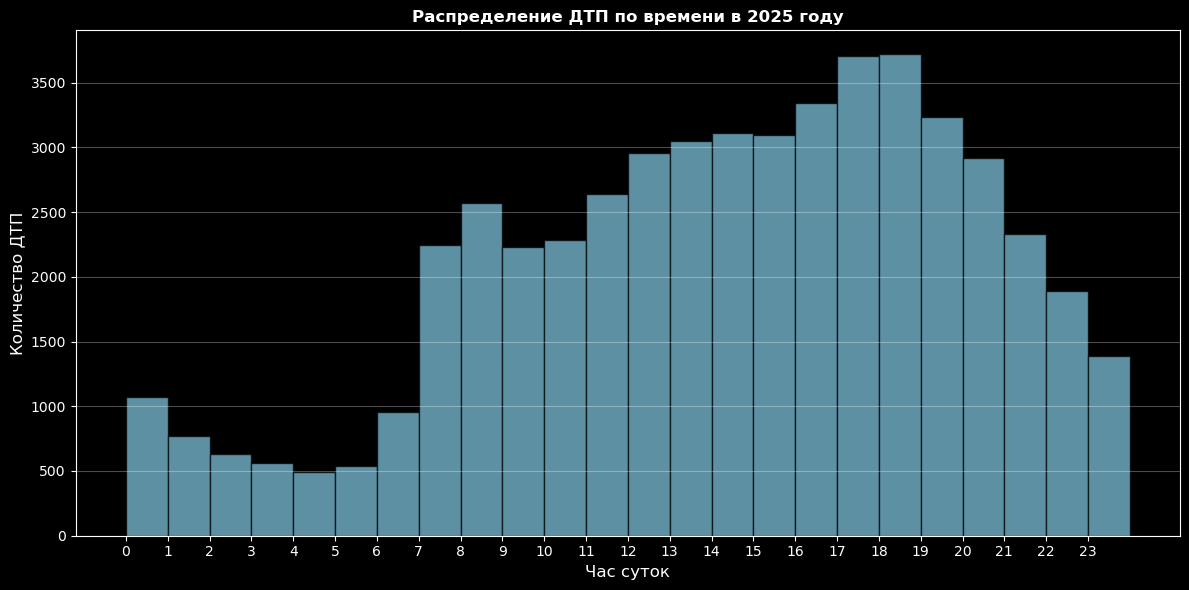

In [279]:
plt.figure(figsize=(12, 6))
plt.hist(gdf[gdf['year'] == 2025]['hour'].dropna(), bins=24, range=(0, 24), 
         edgecolor='black', alpha=0.7, color='skyblue')

plt.title('Распределение ДТП по времени в 2025 году', fontweight='bold')
plt.xlabel('Час суток', fontsize=12)
plt.ylabel('Количество ДТП', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

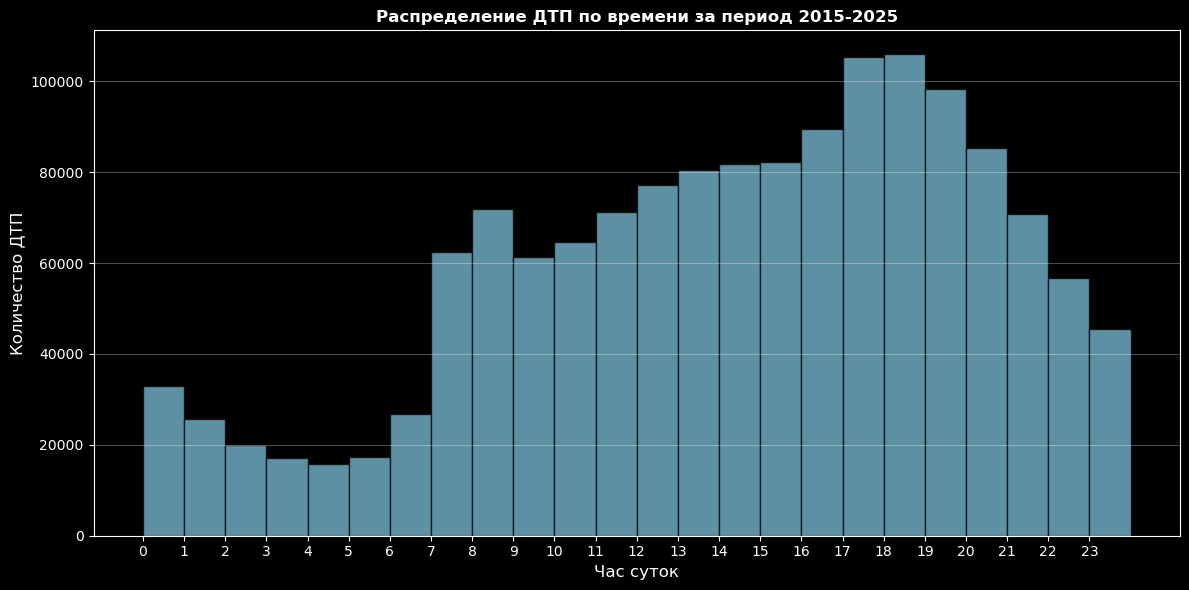

In [280]:
plt.figure(figsize=(12, 6))
plt.hist(gdf['hour'].dropna(), bins=24, range=(0, 24), 
         edgecolor='black', alpha=0.7, color='skyblue')

plt.title('Распределение ДТП по времени за период 2015-2025', fontweight='bold')
plt.xlabel('Час суток', fontsize=12)
plt.ylabel('Количество ДТП', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Два  пика дтп, первый в утренние часы, когда все едут на работу с 8 до 9 и второй пик с 17 до 19 когда все едут с работы. 

Создадим новый столбец, где разделим время дтп на 4 категории: утро, день, вечер, ночь

In [283]:
def get_time_period(hour):
    """
    Разделяет сутки на 4 равных промежутка по 6 часов
    """
    if 0 <= hour < 6:
        return 'Ночь (0-6)'
    elif 6 <= hour < 12:
        return 'Утро (6-12)'
    elif 12 <= hour < 18:
        return 'День (12-18)'
    else:
        return 'Вечер (18-24)'

# Создаем столбец
gdf['time_period'] = gdf['datetime'].dt.hour.apply(get_time_period)

In [284]:
gdf['time_period'].value_counts()

time_period
День (12-18)     516345
Вечер (18-24)    462410
Утро (6-12)      358390
Ночь (0-6)       128737
Name: count, dtype: int64

In [285]:
gdf['time_period'].value_counts(normalize=True)

time_period
День (12-18)    0.35
Вечер (18-24)   0.32
Утро (6-12)     0.24
Ночь (0-6)      0.09
Name: proportion, dtype: float64

Большинство аварий происходит днем 35%, вечером 32%, утром 24%, ночью 9%

## Распределение ролей участников дтп

Добавим столбец с годом из `gdf` в `participants_df` для того, чтобы отфильтровать по году и посмотрим как распределялись роли в 2025 году

In [289]:
participants_df = participants_df.merge(gdf[['id', 'year']],on='id', how='left')

In [290]:
display(
    participants_df[participants_df['year'] == 2025]['role'].value_counts().reset_index().style
    .background_gradient(cmap='Reds')
    .format({'count': "{:.0f}"})
    .set_caption("Количество участников дтп по ролям")
)

Посмотрим топ-5 в относительных величинах

In [292]:
display(
    participants_df[participants_df['year'] == 2025]['role'].value_counts(normalize=True).reset_index().head(5).style
    .background_gradient(cmap='Reds')
    .format({'proportion': "{:.3f}"})
    .set_caption("Топ-5")
)

Больше всего водителей в дтп, почти 66%, далее идут пассажир 21% и пешеход 11%, велосепедисты 1.5%, 0.2% пешеход, находившийся в тс до дтп

Посмотрим на распределение по всем годам топ-5

In [877]:
participants_df[participants_df['violations'].str.contains('полис')]

Empty DataFrame
Columns: [id, vehicle_id, vehicle_category, role, gender, violations, health_status, years_of_driving_experience, year, dead, injured, unharmed, exp_group, is_alcohol, is_driver, drunk_driver, has_viol_speed]
Index: []

In [295]:
display(
    participants_df['role'].value_counts(normalize=True).reset_index().head(5).style
    .background_gradient(cmap='Reds')
    .format({'proportion': "{:.3f}"})
    .set_caption("Топ-5")
)

Практически не изменилось

## Распределение статуса здоровья участников дтп в 2025 году

In [298]:
display(
    participants_df[participants_df['year'] == 2025]['health_status'].value_counts(normalize=True).reset_index().head(10).style
    .background_gradient(cmap='Reds')
    .format({'proportion': "{:.3f}"})
    .set_caption("Топ-10 статусов здоровья участников дтп в 2025 году")
)

Посмотрим за все время

In [300]:
display(
    participants_df['health_status'].value_counts(normalize=True).reset_index().head(10).style
    .background_gradient(cmap='Reds')
    .format({'proportion': "{:.3f}"})
    .set_caption("Топ-10 статусов здоровья участников дтп за период с 2015 - 2025")
)

42% статус не пострадал, раненый различных категорий 48.1%, скончался на месте дтп почти 3%

Добавим три столбца `Скончался`, `Раненый`, `Не пострадал` и напишем функцию, которая в зависимости от статуса в столбце `health_status` будет ставить 1 в нужный столбец

In [303]:
def categorize_health(x):
    if pd.isna(x):
        return pd.Series({"dead": 0, "injured": 0, "unharmed": 0})
    
    # смерти
    if "Скончался" in x:
        return pd.Series({"dead": 1, "injured": 0, "unharmed": 0})
    
    # раненые / травмы
    if ("Раненый" in x) or ("Получил" in x):
        return pd.Series({"dead": 0, "injured": 1, "unharmed": 0})
    
    # не пострадал
    if "Не пострадал" in x:
        return pd.Series({"dead": 0, "injured": 0, "unharmed": 1})
    
    # по умолчанию считаем непострадавшим (если появятся новые статусы)
    return pd.Series({"dead": 0, "injured": 0, "unharmed": 1})

In [304]:
participants_df[["dead", "injured", "unharmed"]] = (
    participants_df["health_status"].progress_apply(categorize_health)
)

100%|█████████████████████████████████████████████████████████████████████| 3508364/3508364 [05:43<00:00, 10221.33it/s]


Посмотрим распределение ролей в зависимости от степени пострадавшего

In [306]:
participants_df_2025 = participants_df[participants_df['year'] == 2025].copy()

In [307]:
participants_df_2025.groupby('role')[['dead', 'injured', 'unharmed']].sum().sort_values(by='dead', ascending=False)

dead  injured  unharmed
role                                                                       
Водитель                                            2652    28277     49912
Пассажир                                            1302    22576      2004
Пешеход                                             1147    12376        75
Велосипедист                                          93     1767        23
Пешеход, перед ДТП находившийся в (на) ТС в кач...    45      196        10
Иной участник                                          7       98        32
Работник дорожной организации, осуществляющий р...     7       24         0
Сотрудник ДПС (ГИБДД), выполняющий служебные об...     2       24         1
Работник иных организаций (коммунальных служб, ...     1        6         1
Сотрудник полиции (кроме ГИБДД), сотрудник (вое...     1        6         0
Всадник                                                0        3         0
Лицо, осуществляющее торговлю (иную деятельност...     0        4         0
Погонщик скота                                         0        0         6

По количеству Больше всего смертельных исходов у водителей 2652, далее идут пассажир 1302 и пешеход 1147 дтп, на четсвертом месте велосепедист 93 смертельны случая, меньше всего у сотрудников полиции.

Посмотрим на рапределение в относительных величинах

In [310]:
participants_df_2025.groupby('role')[['dead', 'injured', 'unharmed']].mean().sort_values(by='dead', ascending=False)

dead  injured  unharmed
role                                                                       
Работник дорожной организации, осуществляющий р...  0.23     0.77      0.00
Пешеход, перед ДТП находившийся в (на) ТС в кач...  0.18     0.78      0.04
Сотрудник полиции (кроме ГИБДД), сотрудник (вое...  0.14     0.86      0.00
Работник иных организаций (коммунальных служб, ...  0.12     0.75      0.12
Пешеход                                             0.08     0.91      0.01
Сотрудник ДПС (ГИБДД), выполняющий служебные об...  0.07     0.89      0.04
Иной участник                                       0.05     0.72      0.23
Пассажир                                            0.05     0.87      0.08
Велосипедист                                        0.05     0.94      0.01
Водитель                                            0.03     0.35      0.62
Всадник                                             0.00     1.00      0.00
Лицо, осуществляющее торговлю (иную деятельност...  0.00     1.00      0.00
Погонщик скота                                      0.00     0.00      1.00

Дорожные работники имеют высокую вероятность летального исхода 23 процента. Также большую вероятность погибнуть имеют люди, которые находились в транспортном средстве, а перед дтп вышли из него. Пешеход имеет вероятность погибнуть 8%, пассажир и велосепедист 5%, водитель 3%

Посмотрим распределение по всем годам

In [313]:
participants_df.groupby('role')[['dead', 'injured', 'unharmed']].sum().sort_values(by='dead', ascending=False)

dead  injured  unharmed
role                                                                        
Водитель                                            70828   734503   1467043
Пешеход                                             44323   388086      1878
Пассажир                                            41557   654619     41584
Велосипедист                                         3349    46656       360
Пешеход, перед ДТП находившийся в (на) ТС в кач...   1163     5690       444
Иной участник                                         284     2040      1143
Работник дорожной организации, осуществляющий р...    260      911        21
Работник иных организаций (коммунальных служб, ...     51      258         9
Сотрудник ДПС (ГИБДД), выполняющий служебные об...     28      551        22
Всадник                                                10      124         6
Лицо, осуществляющее торговлю (иную деятельност...      6       74         4
Погонщик скота                                          3       33       212
Сотрудник полиции (кроме ГИБДД), сотрудник (вое...      3      205         4
Лицо, осуществляющее умышленное перекрытие прое...      1       17         1

In [314]:
participants_df.groupby('role')[['dead', 'injured', 'unharmed']].mean().sort_values(by='dead', ascending=False)

dead  injured  unharmed
role                                                                       
Работник дорожной организации, осуществляющий р...  0.22     0.76      0.02
Работник иных организаций (коммунальных служб, ...  0.16     0.81      0.03
Пешеход, перед ДТП находившийся в (на) ТС в кач...  0.16     0.78      0.06
Пешеход                                             0.10     0.89      0.00
Иной участник                                       0.08     0.59      0.33
Всадник                                             0.07     0.89      0.04
Лицо, осуществляющее торговлю (иную деятельност...  0.07     0.88      0.05
Велосипедист                                        0.07     0.93      0.01
Пассажир                                            0.06     0.89      0.06
Лицо, осуществляющее умышленное перекрытие прое...  0.05     0.89      0.05
Сотрудник ДПС (ГИБДД), выполняющий служебные об...  0.05     0.92      0.04
Водитель                                            0.03     0.32      0.65
Сотрудник полиции (кроме ГИБДД), сотрудник (вое...  0.01     0.97      0.02
Погонщик скота                                      0.01     0.13      0.85

Посмотрим подробнее на категорию `Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира`. Какие чаще всего нарушения приводили к гибели

In [316]:
target_roles = 'Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира'
filtered_df = participants_df[participants_df['role'] == target_roles]

In [317]:
violations_stats = (
    filtered_df.groupby('violations')
    .agg(total_cases=('id', 'count'),dead_count=('dead', 'sum'),dead_rate=('dead', 'mean'),injured_count=('injured', 'sum'))
    .sort_values('dead_count', ascending=False))
violations_stats['dead_rate'] *= 100

violations_stats.head(10)

total_cases  dead_count  \
violations                                                                    
                                                           5090         601   
Нахождение на проезжей части без цели её перехода           799         195   
Иные нарушения                                              915         189   
Нахождение на проезжей части без цели её перехо...          108          42   
Нахождение на проезжей части без цели её перехо...          121          35   
Отсутствие световозвращающих элементов                      125          30   
Иные нарушения, Пешеход в состоянии алкогольног...           41          21   
Нахождение на проезжей части без цели её перехо...           30          17   
Иные нарушения, Отсутствие световозвращающих эл...           31          15   
Нахождение на проезжей части без цели её перехо...            8           5   

                                                    dead_rate  injured_count  
violations                                                                    
                                                        11.81           4111  
Нахождение на проезжей части без цели её перехода       24.41            591  
Иные нарушения                                          20.66            686  
Нахождение на проезжей части без цели её перехо...      38.89             64  
Нахождение на проезжей части без цели её перехо...      28.93             83  
Отсутствие световозвращающих элементов                  24.00             91  
Иные нарушения, Пешеход в состоянии алкогольног...      51.22             19  
Нахождение на проезжей части без цели её перехо...      56.67             13  
Иные нарушения, Отсутствие световозвращающих эл...      48.39             14  
Нахождение на проезжей части без цели её перехо...      62.50              2

Рассмотрим категорию `Работник иных организаций (коммунальных служб, электросетей, водоканала и т.д.), осуществляющий работы на проезжей части (обочине и т.д.)`

In [319]:
target_roles = 'Работник иных организаций (коммунальных служб, электросетей, водоканала и т.д.), осуществляющий работы на проезжей части (обочине и т.д.)'
filtered_df = participants_df[participants_df['role'] == target_roles]

In [320]:
violations_stats = (
    filtered_df.groupby('violations')
    .agg(total_cases=('id', 'count'),dead_count=('dead', 'sum'),dead_rate=('dead', 'mean'),injured_count=('injured', 'sum'))
    .sort_values('dead_count', ascending=False))
violations_stats['dead_rate'] *= 100

violations_stats.head(10)

total_cases  dead_count  dead_rate  injured_count
violations                                                       
                        264          44      16.67            216
Иные нарушения           54           7      12.96             42

Большинство ДТП по этим категориям связаны с нарушением водителей, а не самих пешехода или работника коммунальных служб

Посмотрим по водителю

In [323]:
target_roles = 'Водитель'
filtered_df = participants_df[participants_df['role'] == target_roles]

In [324]:
violations_stats = (
    filtered_df.groupby('violations')
    .agg(total_cases=('id', 'count'),dead_count=('dead', 'sum'),dead_rate=('dead', 'mean'),injured_count=('injured', 'sum'))
    .sort_values('dead_count', ascending=False))
violations_stats['dead_rate'] *= 100

violations_stats.head(10)

total_cases  dead_count  \
violations                                                                    
                                                         774659        9450   
Выезд на полосу встречного движения                       41142        5851   
Несоответствие скорости конкретным условиям дви...        76452        3164   
Нарушение правил расположения ТС на проезжей части        54947        2389   
Другие нарушения ПДД водителем                            82426        2063   
Несоблюдение очередности проезда                         137609        1615   
Управление ТС в состоянии алкогольного опьянени...         6368        1535   
Неправильный выбор дистанции                              88397        1510   
Нарушение правил расположения ТС на проезжей ча...         8685        1499   
Управление ТС в состоянии алкогольного опьянени...         8334        1441   

                                                    dead_rate  injured_count  
violations                                                                    
                                                         1.22         235752  
Выезд на полосу встречного движения                     14.22          19988  
Несоответствие скорости конкретным условиям дви...       4.14          37600  
Нарушение правил расположения ТС на проезжей части       4.35          27952  
Другие нарушения ПДД водителем                           2.50          26676  
Несоблюдение очередности проезда                         1.17          37477  
Управление ТС в состоянии алкогольного опьянени...      24.10           3048  
Неправильный выбор дистанции                             1.71          22470  
Нарушение правил расположения ТС на проезжей ча...      17.26           5349  
Управление ТС в состоянии алкогольного опьянени...      17.29           5240

In [325]:
target_roles = 'Пешеход'
filtered_df = participants_df[participants_df['role'] == target_roles]

In [326]:
violations_stats = (
    filtered_df.groupby('violations')
    .agg(total_cases=('id', 'count'),dead_count=('dead', 'sum'),dead_rate=('dead', 'mean'),injured_count=('injured', 'sum'))
    .sort_values('dead_count', ascending=False))
violations_stats['dead_rate'] *= 100

violations_stats.head(10)

total_cases  dead_count  \
violations                                                                    
                                                         265243       13439   
Переход через проезжую часть вне пешеходного пе...        51444        6160   
Переход через проезжую часть в неустановленном ...        24736        3291   
Нахождение на проезжей части без цели её перехода         10558        3119   
Иные нарушения                                            15835        2860   
Нахождение на проезжей части без цели её перехо...         2860        1232   
Неподчинение сигналам регулирования                       12373        1140   
Нахождение на проезжей части без цели её перехо...         1842         914   
Иные нарушения, Пешеход в состоянии алкогольног...         2811         860   
Переход через проезжую часть вне пешеходного пе...         3430         858   

                                                    dead_rate  injured_count  
violations                                                                    
                                                         5.07         250627  
Переход через проезжую часть вне пешеходного пе...      11.97          45115  
Переход через проезжую часть в неустановленном ...      13.30          21364  
Нахождение на проезжей части без цели её перехода       29.54           7403  
Иные нарушения                                          18.06          12828  
Нахождение на проезжей части без цели её перехо...      43.08           1617  
Неподчинение сигналам регулирования                      9.21          11159  
Нахождение на проезжей части без цели её перехо...      49.62            918  
Иные нарушения, Пешеход в состоянии алкогольног...      30.59           1941  
Переход через проезжую часть вне пешеходного пе...      25.01           2569

За период 2015-2025 дорожные работники имеют вероятность гибели 22%, пешеход, находившийся в тс до дтп - 16%, обычный пешеход 10%, велосепедист 7%, пассажир 6%, водитель 3%

## Распределение стажа водителей

In [329]:
participants_df['years_of_driving_experience'].unique()

<IntegerArray>
[  18,   10, <NA>,   21,    7,    6,   27,   14,   23,    5,   25,    8,    4,
   28,   20,    9,   15,   17,   16,   34,   40,    3,   11,   12,   39,   37,
   32,   19,   33,   26,   29,   30,   22,   31,   13,    1,    2,   42,   43,
   44,   36,   45,   24,   35,   41,   47,   50,   46,   51,   48,   38,   62,
   49,   52,   56,   57,   54,   58,   61,   60,   55,   53,   59,   63,   67,
   65,   66,   64,   68,   69,   73,   74,   70,   71]
Length: 74, dtype: Int8

Сгруппируем стаж водителей

In [331]:
bins = [-1, 1, 3, 10, 20, 40, 100]  
labels = ['0–1 год', '1–3 года', '3–10 лет', '10–20 лет', '20–40 лет', '40+ лет']

participants_df['exp_group'] = pd.cut(participants_df['years_of_driving_experience'],bins=bins, labels=labels, right=True)

In [332]:
participants_df[(participants_df['year'] == 2025) & (participants_df['role'] == 'Водитель')]['exp_group'].value_counts(normalize=True)

exp_group
20–40 лет   0.32
10–20 лет   0.31
3–10 лет    0.21
1–3 года    0.07
40+ лет     0.06
0–1 год     0.04
Name: proportion, dtype: float64

In [333]:
participants_df[(participants_df['year'] == 2025) & (participants_df['role'] == 'Водитель')]['exp_group'].value_counts()

exp_group
20–40 лет    21871
10–20 лет    21460
3–10 лет     14204
1–3 года      4524
40+ лет       4006
0–1 год       2933
Name: count, dtype: int64

Больше всего дтп в 2025 году у достаточно опытных водителей (20–40 лет - 32%, 10–20 лет - 31%) и меньше всего у новичков 0–1 год - 4%

Посмотрим распределение дтп по всем годам

In [336]:
participants_df[participants_df['role'] == 'Водитель']['exp_group'].value_counts()

exp_group
10–20 лет    618456
3–10 лет     604233
20–40 лет    478055
1–3 года     164137
0–1 год       90157
40+ лет       60705
Name: count, dtype: int64

In [337]:
participants_df[participants_df['role'] == 'Водитель']['exp_group'].value_counts(normalize=True)

exp_group
10–20 лет   0.31
3–10 лет    0.30
20–40 лет   0.24
1–3 года    0.08
0–1 год     0.04
40+ лет     0.03
Name: proportion, dtype: float64

За все года распределение отличается. Опытные водители все еще на первом месте, 10-20 лет стажа создают почти 31% дтп, на втором месте водители с 3 - 10 лет стажа - 30%, на третьем месте 20-40 лет стажа - 24%. Меньше всего 40+ лет - 3% и до 1 года стаж - 4%.

Опытные водители содзают больше дтп чем новички

## Распределение дтп по полу

Посмотрим распределение по полу в 2025 году

In [342]:
participants_df[participants_df['year'] == 2025]['gender'].value_counts()

gender
Мужской           84870
Женский           36252
Нет информации     1556
Name: count, dtype: int64

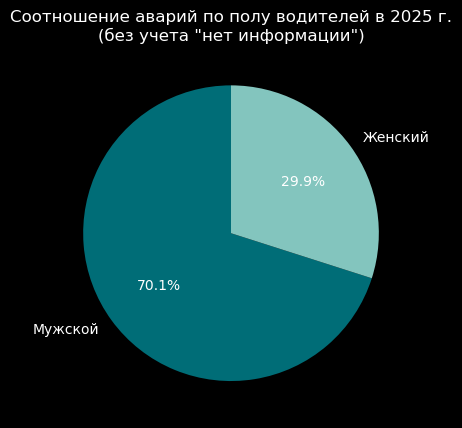

In [343]:
mask = participants_df[participants_df['year'] == 2025]['gender'] != 'Нет информации'

filtered_gender = participants_df[participants_df['year'] == 2025].loc[mask, 'gender'].value_counts(normalize=True)

filtered_gender.plot(kind='pie',
                   autopct='%1.1f%%',
                   startangle=90,
                   colors=['#006d77', '#83c5be'],
                   title='Соотношение аварий по полу водителей в 2025 г.\n(без учета "нет информации")')

plt.ylabel('')
plt.show()

Мужчины совершают 70.1% всех аварий в 2025 году, женщины 29.9%

Посмотрим как распределены раненые, смертельные случаи и те, кто не получил травм 

In [346]:
participants_df[participants_df['year'] == 2025].groupby('gender')[['dead', 'injured', 'unharmed']].mean().sort_values(by='dead', ascending=False)

dead  injured  unharmed
gender                                 
Мужской         0.05     0.45      0.50
Женский         0.03     0.75      0.22
Нет информации  0.00     0.01      0.99

Посмотрим по всем годам

In [348]:
participants_df['gender'].value_counts(normalize=True)

gender
Мужской          0.69
Женский          0.28
Нет информации   0.02
Name: proportion, dtype: float64

In [349]:
participants_df.groupby('gender')[['dead', 'injured', 'unharmed']].mean().sort_values(by='dead', ascending=False)

dead  injured  unharmed
gender                                 
Мужской         0.05     0.43      0.52
Женский         0.04     0.76      0.20
Нет информации  0.03     0.33      0.64

Мужчины реже получают травмы чем женщины (женщины в 1.7 раза чаще мужчин), мужчины чаще остаются невредимыми в дтп (в 2.3 раза чаще женщин). Но не смотря на это смертность у мужчин в дтп выше (в 1.7 раза выше) чем у женщин. 

## Распределение дтп по погодным условиям

In [352]:
gdf[gdf['year'] == 2025]['weather'].value_counts()

weather
Ясно                               32789
Пасмурно                           14454
Дождь                               1798
Снегопад                            1766
Пасмурно, Снегопад                   265
Пасмурно, Дождь                      197
Туман                                131
Метель                               103
Ясно, Температура выше +30С           52
Ясно, Температура ниже -30С           46
Снегопад, Метель                      42
Пасмурно, Туман                       23
Пасмурно, Температура ниже -30С       14
Пасмурно, Метель                      11
Туман, Температура ниже -30С           8
Снегопад, Температура ниже -30С        6
Пасмурно, Ураганный ветер              5
Дождь, Снегопад                        4
Ясно, Туман                            3
Метель, Температура ниже -30С          3
Дождь, Туман                           2
Ясно, Дождь                            2
Метель, Ураганный ветер                2
Туман, Снегопад                        2
Снегопад

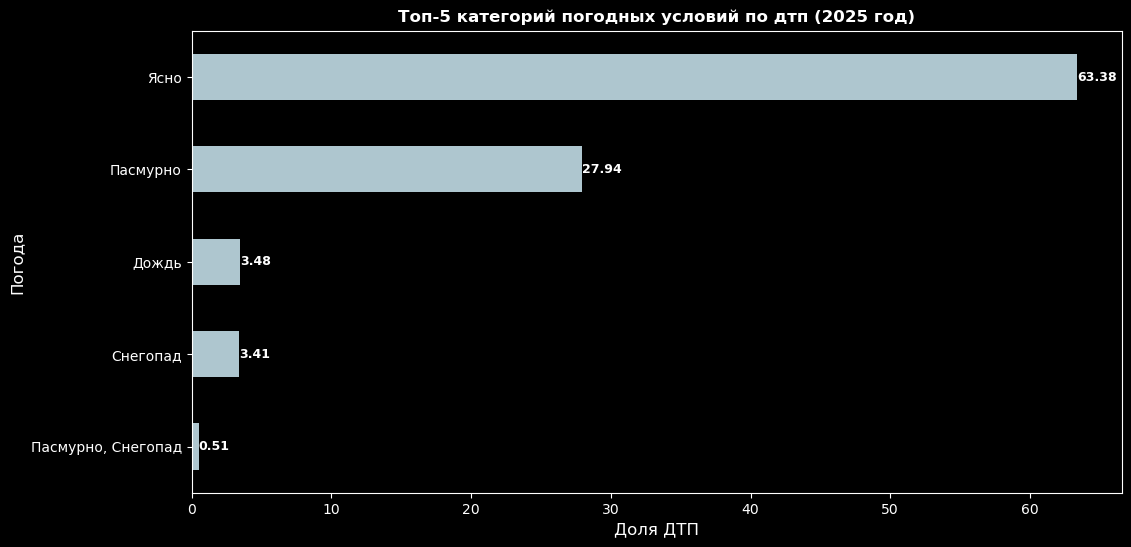

In [353]:
weather_accidents = (gdf[gdf['year'] == 2025]['weather'].value_counts(normalize=True).head(5).sort_values() * 100).round(2)

plt.figure(figsize=(12, 6))
weather_accidents.plot(kind='barh', color='#AEC6CF')

for i, value in enumerate(weather_accidents.values):
    plt.text(value, i, f'{value}', va='center', fontweight='bold', fontsize=9)

plt.title('Топ-5 категорий погодных условий по дтп (2025 год)', fontweight='bold')
plt.xlabel('Доля ДТП', fontsize=12)
plt.ylabel('Погода', fontsize=12)

plt.show()

67% всех дтп в 2025 году в ясную погоду, 28% когда пасмурно, 3.5% когда дождь, 3.4% в снегопад, 0.51% в пасмурно и снегопад.

In [355]:
gdf[gdf['year'] == 2025].groupby('weather')[['participants_count', 'injured_count', 'dead_count']].sum().sort_values(by='dead_count', ascending=False)

participants_count  injured_count  dead_count
weather                                                                       
Ясно                                          79133          40243        3330
Пасмурно                                      35509          17863        1422
Дождь                                          4374           2259         252
Снегопад                                       4944           2593         215
Пасмурно, Снегопад                              727            387          37
Туман                                           344            161          36
Пасмурно, Дождь                                 510            263          24
Метель                                          317            166          21
Пасмурно, Туман                                  72             46           8
Снегопад, Метель                                133             61           8
Ясно, Температура выше +30С                     137             77           6
Ясно, Туман                                      14              2           3
Ясно, Температура ниже -30С                     127             70           2
Ясно, Ураганный ветер                             3              1           2
Пасмурно, Температура ниже -30С                  38             19           1
Пасмурно, Метель                                 31             17           1
Дождь, Метель                                     4              3           0
Пасмурно, Температура выше +30С                   3              1           0
Снегопад, Температура ниже -30С                  15              7           0
Снегопад, Ураганный ветер                         1              1           0
Метель, Ураганный ветер                          14              2           0
Туман, Снегопад                                   3              2           0
Туман, Температура ниже -30С                     27             10           0
Метель, Температура ниже -30С                     6              3           0
Ясно, Дождь                                       8              5           0
Ясно, Метель                                      2              1           0
Дождь, Ураганный ветер                            3              1           0
Дождь, Туман                                      6              3           0
Дождь, Снегопад                                  10              6           0
Пасмурно, Ураганный ветер                        10              7           0

Больше всего участников дтп в ясную погоду, в эту же категорию входит больше всего дтп со смертельным исходом. На втором месте по этим двум показателем находится категория пасмурно

Посмотрим за период 2015-2025

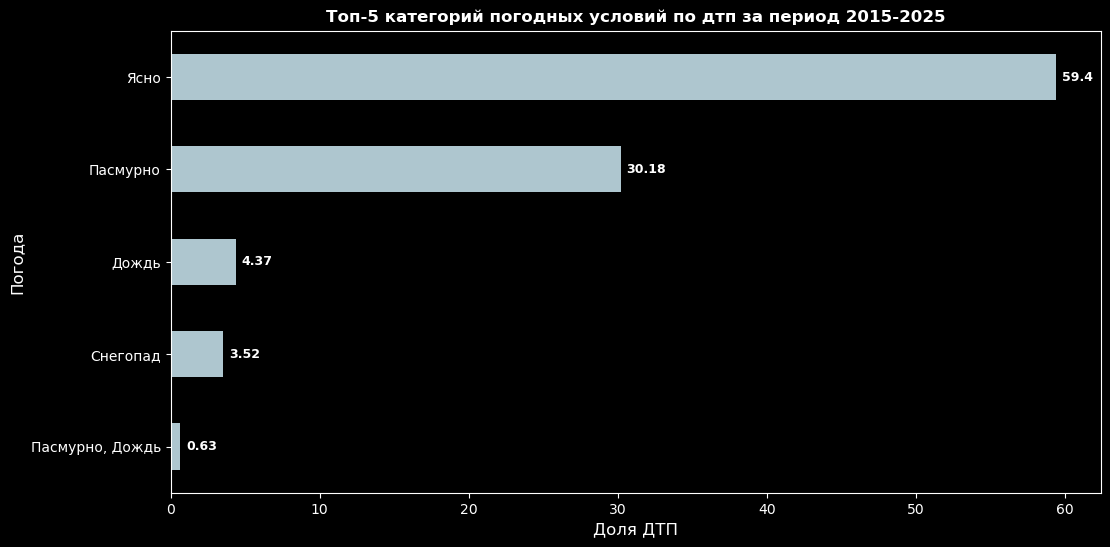

In [358]:
weather_accidents = (gdf['weather'].value_counts(normalize=True).head(5).sort_values() * 100).round(2)

plt.figure(figsize=(12, 6))
weather_accidents.plot(kind='barh', color='#AEC6CF')

for i, value in enumerate(weather_accidents.values):
    plt.text(value + 0.4, i, f'{value}', va='center', fontweight='bold', fontsize=9)

plt.title('Топ-5 категорий погодных условий по дтп за период 2015-2025', fontweight='bold')
plt.xlabel('Доля ДТП', fontsize=12)
plt.ylabel('Погода', fontsize=12)

plt.show()

Посмотрим как распределены количество пострадавших/погибших по категории погода в 2025 году

In [360]:
agg_weather = gdf[gdf['year'] == 2025].groupby('weather')[['participants_count', 'injured_count', 'dead_count']].sum()

# добавляем относительные значения в процентах
agg_weather['dead_pct']    = (agg_weather['dead_count']    / agg_weather['participants_count']) * 100
agg_weather['injured_pct'] = (agg_weather['injured_count'] / agg_weather['participants_count']) * 100
agg_weather['unharmed_pct'] = 100 - agg_weather['dead_pct'] - agg_weather['injured_pct']

# сортируем по смертности
agg_weather = agg_weather.sort_values(by='dead_pct', ascending=False)

agg_weather

participants_count  injured_count  \
weather                                                              
Ясно, Ураганный ветер                             3              1   
Ясно, Туман                                      14              2   
Пасмурно, Туман                                  72             46   
Туман                                           344            161   
Метель                                          317            166   
Снегопад, Метель                                133             61   
Дождь                                          4374           2259   
Пасмурно, Снегопад                              727            387   
Пасмурно, Дождь                                 510            263   
Ясно, Температура выше +30С                     137             77   
Снегопад                                       4944           2593   
Ясно                                          79133          40243   
Пасмурно                                      35509          17863   
Пасмурно, Метель                                 31             17   
Пасмурно, Температура ниже -30С                  38             19   
Ясно, Температура ниже -30С                     127             70   
Метель, Ураганный ветер                          14              2   
Туман, Температура ниже -30С                     27             10   
Дождь, Снегопад                                  10              6   
Ясно, Метель                                      2              1   
Ясно, Дождь                                       8              5   
Снегопад, Температура ниже -30С                  15              7   
Туман, Снегопад                                   3              2   
Дождь, Туман                                      6              3   
Снегопад, Ураганный ветер                         1              1   
Дождь, Ураганный ветер                            3              1   
Дождь, Метель                                     4              3   
Метель, Температура ниже -30С                     6              3   
Пасмурно, Температура выше +30С                   3              1   
Пасмурно, Ураганный ветер                        10              7   

                                 dead_count  dead_pct  injured_pct  \
weather                                                              
Ясно, Ураганный ветер                     2     66.67        33.33   
Ясно, Туман                               3     21.43        14.29   
Пасмурно, Туман                           8     11.11        63.89   
Туман                                    36     10.47        46.80   
Метель                                   21      6.62        52.37   
Снегопад, Метель                          8      6.02        45.86   
Дождь                                   252      5.76        51.65   
Пасмурно, Снегопад                       37      5.09        53.23   
Пасмурно, Дождь                          24      4.71        51.57   
Ясно, Температура выше +30С               6      4.38        56.20   
Снегопад                                215      4.35        52.45   
Ясно                                   3330      4.21        50.85   
Пасмурно                               1422      4.00        50.31   
Пасмурно, Метель                          1      3.23        54.84   
Пасмурно, Температура ниже -30С           1      2.63        50.00   
Ясно, Температура ниже -30С               2      1.57        55.12   
Метель, Ураганный ветер                   0      0.00        14.29   
Туман, Температура ниже -30С              0      0.00        37.04   
Дождь, Снегопад                           0      0.00        60.00   
Ясно, Метель                              0      0.00        50.00   
Ясно, Дождь                               0      0.00        62.50   
Снегопад, Температура ниже -30С           0      0.00        46.67   
Туман, Снегопад                           0      0.00        66.67   
Дождь, Туман                              

Посмотрим как за период 2015-2025

In [362]:
agg_weather = gdf.groupby('weather')[['participants_count', 'injured_count', 'dead_count']].sum()

# добавляем относительные значения в процентах
agg_weather['dead_pct']    = (agg_weather['dead_count']    / agg_weather['participants_count']) * 100
agg_weather['injured_pct'] = (agg_weather['injured_count'] / agg_weather['participants_count']) * 100
agg_weather['unharmed_pct'] = 100 - agg_weather['dead_pct'] - agg_weather['injured_pct']

# сортируем по смертности
agg_weather = agg_weather.sort_values(by='dead_pct', ascending=False)

agg_weather

participants_count  injured_count  \
weather                                                              
Ясно, Ураганный ветер                           126             68   
Дождь, Туман                                    581            286   
Дождь, Метель                                    42             21   
Туман                                         13734           7254   
Метель, Ураганный ветер                         212            109   
Пасмурно, Метель                               1564            802   
Пасмурно, Туман                                3487           1875   
Пасмурно, Ураганный ветер                       333            179   
Ясно, Туман                                     244            123   
Метель                                         8401           4282   
Ясно, Метель                                    117             61   
Дождь, Ураганный ветер                           93             55   
Снегопад, Метель                               6196           3163   
Дождь, Снегопад                                1051            550   
Пасмурно, Температура ниже -30С                1239            602   
Пасмурно, Дождь                               23101          11840   
Пасмурно, Снегопад                            24974          13000   
Дождь                                        158443          81665   
Ясно, Температура ниже -30С                    5238           2620   
Метель, Температура ниже -30С                   113             64   
Пасмурно, Температура выше +30С                 104             61   
Снегопад                                     141293          73962   
Ясно, Температура выше +30С                    7893           4160   
Ясно                                        2134839        1093790   
Пасмурно                                    1090777         552902   
Ясно, Дождь                                     211            110   
Снегопад, Температура ниже -30С                 352            166   
Туман, Температура ниже -30С                   1218            581   
Туман, Снегопад                                 109             58   
Снегопад, Ураганный ветер                        96             54   
Дождь, Температура выше +30С                     13              9   
Туман, Метель                                     2              1   
Дождь, Температура ниже -30С                      3              2   

                                 dead_count  dead_pct  injured_pct  \
weather                                                              
Ясно, Ураганный ветер                    19     15.08        53.97   
Дождь, Туман                             76     13.08        49.23   
Дождь, Метель                             5     11.90        50.00   
Туман                                  1312      9.55        52.82   
Метель, Ураганный ветер                  18      8.49        51.42   
Пасмурно, Метель                        131      8.38        51.28   
Пасмурно, Туман                         287      8.23        53.77   
Пасмурно, Ураганный ветер                26      7.81        53.75   
Ясно, Туман                              19      7.79        50.41   
Метель                                  651      7.75        50.97   
Ясно, Метель                              9      7.69        52.14   
Дождь, Ураганный ветер                    7      7.53        59.14   
Снегопад, Метель                        451      7.28        51.05   
Дождь, Снегопад                          69      6.57        52.33   
Пасмурно, Температура ниже -30С          70      5.65        48.59   
Пасмурно, Дождь                        1274      5.51        51.25   
Пасмурно, Снегопад                     1359      5.44        52.05   
Дождь                                  8489      5.36        51.54   
Ясно, Температура ниже -30С             280      5.35        50.02   
Метель, Температура ниже -30С             6      5.31        56.64   
Пасмурно, Температура выше +30С           

За период 2015-2025 доля смертельных исходов больше всего у Ясно, Ураганный ветер 15.08%, далее Дождь, Туман - 13.08%, на третьем месте Дождь, Метель почти 11.9%. В ясную погоду доля смертельных дтп 4.5%, в дождь 5.36%

## Распределение дтп по дорожному покрытию

Посмотрим количество дтп в 2025 году

In [366]:
display(
    gdf[gdf['year'] == 2025]['road_conditions'].value_counts().head(20).reset_index().style
    .background_gradient(cmap='Reds')
    .format({'count': "{:.0f}"})
    .set_caption("Количество дтп по дорожному покрытию в 2025 году")
)

In [367]:
display(
    gdf[gdf['year'] == 2025]['road_conditions'].value_counts(normalize=True).head(10).reset_index().style
    .background_gradient(cmap='Reds')
    .format({'proportion': "{:.3f}"})
    .set_caption("Доля дтп по дорожному покрытию в 2025 году")
)

Посмотрим за период 2015-2025

In [369]:
display(
    gdf['road_conditions'].value_counts(normalize=True).head(10).reset_index().style
    .background_gradient(cmap='Reds')
    .format({'proportion': "{:.3f}"})
    .set_caption("Доля дтп по дорожному покрытию в период 2015 - 2025 году")
)

В 2025 году больше всего дтп на сухой дороге 47.2%, на втором  месте мокрая дорога - 12.3%, на третьем месте отсутствует покрытия сухое - 10.3%. За период с 2015 по 2025 год, распределение по катгориям такое-же, проценты другие: первое место на сухой дороге 44.1%, на втором  месте мокрая дорога - 12.6%, на третьем месте отсутствует покрытия сухое - 8%

## Распределение дтп по типам транспортных средств

Добавим дату дтп к датафрейму с тс

In [373]:
vehicles_df = vehicles_df.merge(gdf[['id', 'datetime']],on='id', how='left')

Создадим столбец с годом дтп

In [375]:
vehicles_df['year_accident'] = vehicles_df['datetime'].dt.year

In [376]:
vehicles_df.sample()

id vehicle_id  year   brand   color    model  \
1614801  322827   322827_0  2007  TOYOTA  Черный  Corolla   

                                             category            datetime  \
1614801  С-класс (малый средний, компактный) до 4,3 м 2019-11-09 10:10:00   

         year_accident  
1614801           2019

In [377]:
display(
    vehicles_df[vehicles_df['year_accident'] == 2025]['category'].value_counts().head(15).reset_index().style
    .background_gradient(cmap='Reds')
    .format({'count': "{:.0f}"})
    .set_caption("Количество дтп по типу тс в 2025 году")
)

In [378]:
display(
    vehicles_df[vehicles_df['year_accident'] == 2025]['category'].value_counts(normalize=True).head(15).reset_index().style
    .background_gradient(cmap='Reds')
    .format({'proportion': "{:.3f}"})
    .set_caption("Доля дтп по типу тс в 2025 году")
)

Посмотрим на распределение за период 2015-2025

In [380]:
display(
    vehicles_df['category'].value_counts(normalize=True).head(15).reset_index().style
    .background_gradient(cmap='Reds')
    .format({'proportion': "{:.3f}"})
    .set_caption("Доля дтп по типу тс 2015 - 2025 году")
)

Доля дтп по транспортным средствам в 2025 году: В-класс 37.8%, С-класс 14%, Прочие легковые автомобили 9.7%, D-класс 6%, мотоциклы 4.4%. 

## Распределение дтп по возрасту тс

Построим гисторамму возраста тс, но немного укоротим хвост где множество единичных значений

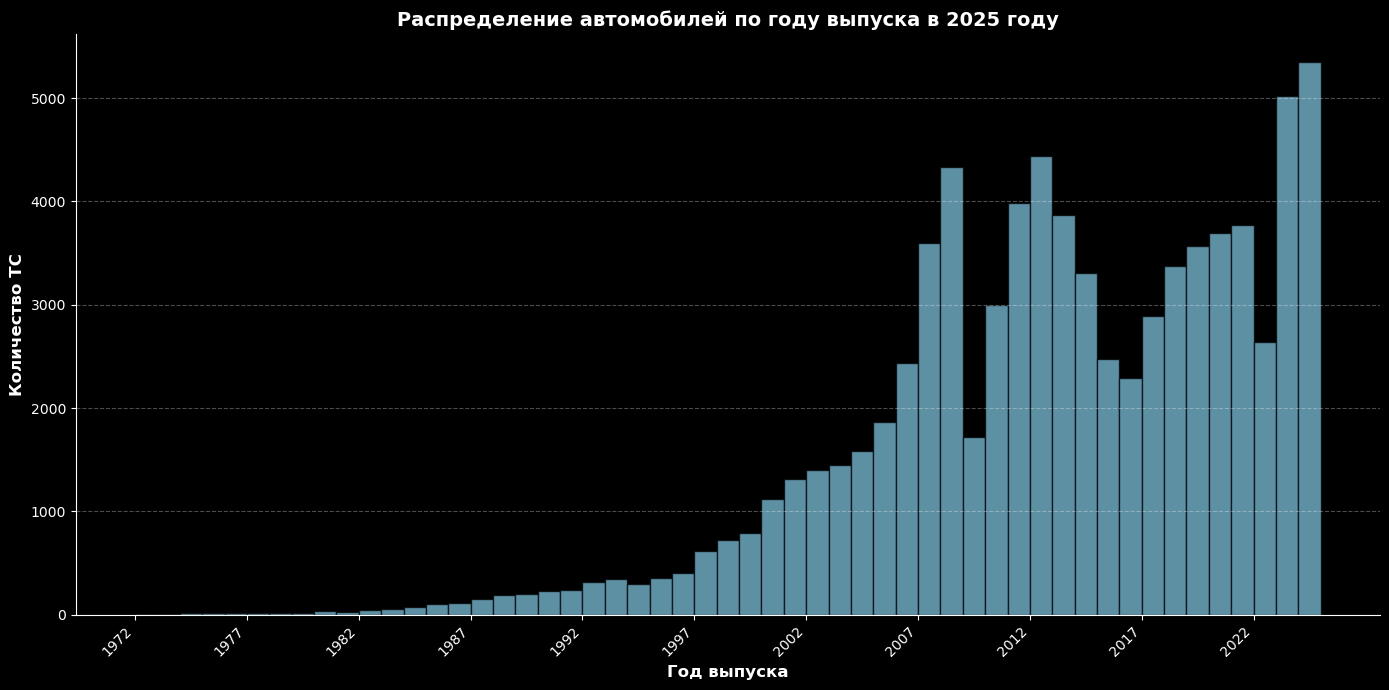

In [384]:
plt.figure(figsize=(14, 7))

# Гистограмма
ax = vehicles_df[vehicles_df['year_accident'] == 2025]['year'].dropna().hist(
    bins=range(1972, 2026), 
    edgecolor='black', 
    alpha=0.7,
    color='skyblue',
    grid=False
)

# Настройки внешнего вида
plt.xticks(range(1972, 2026, 5), rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.xlabel("Год выпуска", fontsize=12, fontweight='bold')
plt.ylabel("Количество ТС", fontsize=12, fontweight='bold')
plt.title("Распределение автомобилей по году выпуска в 2025 году", fontsize=14, fontweight='bold')

# Сетка
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Убираем рамку
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

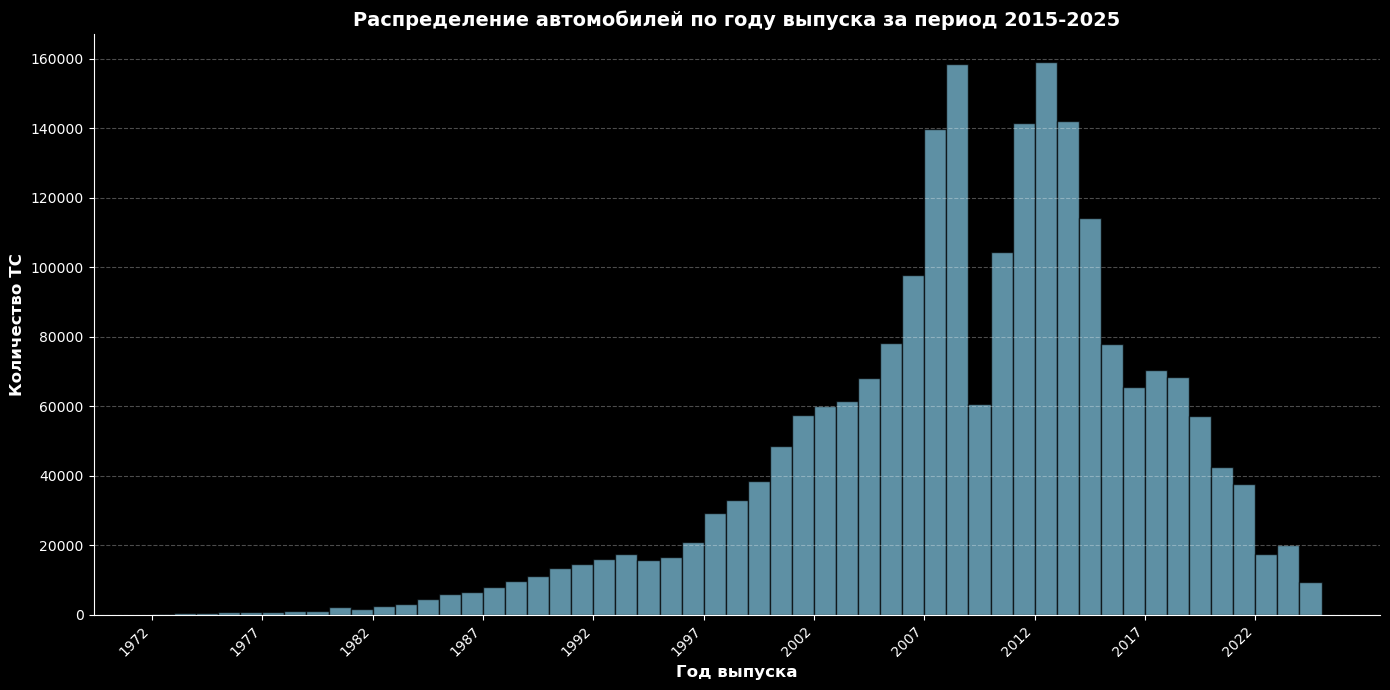

In [385]:
plt.figure(figsize=(14, 7))

# Гистограмма
ax = vehicles_df['year'].dropna().hist(
    bins=range(1972, 2026), 
    edgecolor='black', 
    alpha=0.7,
    color='skyblue',
    grid=False
)

# Настройки внешнего вида
plt.xticks(range(1972, 2026, 5), rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.xlabel("Год выпуска", fontsize=12, fontweight='bold')
plt.ylabel("Количество ТС", fontsize=12, fontweight='bold')
plt.title("Распределение автомобилей по году выпуска за период 2015-2025", fontsize=14, fontweight='bold')

# Сетка
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Убираем рамку
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

Создадим столбцы с возрастом тс `car_age` и  столбец `age_group`, поделив на группы возраст тс

In [387]:
current_year = 2025

vehicles_df['car_age'] = current_year - vehicles_df['year']

bins = [-1, 3, 10, 20, 200]  
labels = ["0–3 года (новые)", "4–10 лет (средние)", "11–20 лет (старые)", "20+ лет (очень старые)"]

vehicles_df['age_group'] = pd.cut(vehicles_df['car_age'], bins=bins, labels=labels)

In [388]:
vehicles_df[vehicles_df['year_accident'] == 2025]['age_group'].value_counts()

age_group
11–20 лет (старые)        32557
4–10 лет (средние)        22049
0–3 года (новые)          13011
20+ лет (очень старые)    12283
Name: count, dtype: int64

In [389]:
vehicles_df[vehicles_df['year_accident'] == 2025]['age_group'].value_counts(normalize=True)

age_group
11–20 лет (старые)       0.41
4–10 лет (средние)       0.28
0–3 года (новые)         0.16
20+ лет (очень старые)   0.15
Name: proportion, dtype: float64

Посмотрим распределение за период 2015-2025

In [391]:
vehicles_df['age_group'].value_counts(normalize=True)

age_group
11–20 лет (старые)       0.54
20+ лет (очень старые)   0.26
4–10 лет (средние)       0.19
0–3 года (новые)         0.02
Name: proportion, dtype: float64

В 2025 году 41% составляют 11–20 лет (старые) тс, 28% 4–10 лет (средние), 0–3 года (новые) 16%, 20+ лет (очень старые) 15%. ЗА период с 2015-2025 проценты немного другие: 54% составляют 11–20 лет (старые) тс, 26% 20+ лет (очень старые), 4–10 лет (средние) 19%, 0–3 года (новые) 2%.

Посмотрим распределение дтп по возрасту и по участникам, смертельным случаям и раненым

In [394]:
vehicles_sort = vehicles_df.merge(gdf, how='left', on='id')

In [395]:
vehicles_sort[vehicles_sort['year_accident'] == 2025].groupby(
    'age_group', observed=False)[['participants_count','injured_count','dead_count']].sum().sort_values(by='dead_count', ascending=False)

participants_count  injured_count  dead_count
age_group                                                            
11–20 лет (старые)                   90791          44014        3762
4–10 лет (средние)                   61454          29208        2182
20+ лет (очень старые)               32968          16423        1554
0–3 года (новые)                     33687          16350        1219

Посмотрим за период 2015-2025

In [397]:
(vehicles_sort.groupby('age_group', observed=False)
    [['participants_count','injured_count','dead_count']].sum().sort_values(by='dead_count', ascending=False))

participants_count  injured_count  dead_count
age_group                                                            
11–20 лет (старые)                 3360366        1651060      135827
20+ лет (очень старые)             1556466         782341       76627
4–10 лет (средние)                 1185696         564846       42645
0–3 года (новые)                    123196          59314        4934

In [398]:
result = (vehicles_sort.groupby('age_group', observed=False)
    [['participants_count','injured_count','dead_count']].sum()
    .sort_values(by='dead_count', ascending=False))

result['death_rate'] = (result['dead_count'] / result['participants_count'] * 100).round(2)
result['injured_rate'] = (result['injured_count'] / result['participants_count'] * 100).round(2)
result.sort_values(by='death_rate', ascending=False)

participants_count  injured_count  dead_count  \
age_group                                                               
20+ лет (очень старые)             1556466         782341       76627   
11–20 лет (старые)                 3360366        1651060      135827   
0–3 года (новые)                    123196          59314        4934   
4–10 лет (средние)                 1185696         564846       42645   

                        death_rate  injured_rate  
age_group                                         
20+ лет (очень старые)        4.92         50.26  
11–20 лет (старые)            4.04         49.13  
0–3 года (новые)              4.01         48.15  
4–10 лет (средние)            3.60         47.64

По количеству 11–20 лет (старые) тоже на первом месте. Вероятность погибнуть в аварии больше у 20+ лет (очень старые) 4.92%, меньше всего у 4–10 лет (средние) 3.60%, это же касается доля пострадавших в аварии.

## Распределение дтп по категориям дтп

Посмотрим распределение по количеству дтп за 2025 год

In [402]:
gdf[gdf['year'] == 2025].groupby('category')[['participants_count','injured_count','dead_count']].sum().sort_values(by='dead_count', ascending=False)

participants_count  \
category                                                                 
Столкновение                                                     68261   
Наезд на пешехода                                                26962   
Съезд с дороги                                                   10539   
Наезд на препятствие                                              4716   
Наезд на стоящее ТС                                               4297   
Опрокидывание                                                     2551   
Наезд на велосипедиста                                            3936   
Наезд на животное                                                  541   
Иной вид ДТП                                                       472   
Падение пассажира                                                 3950   
Наезд на лицо, не являющееся участником дорожно...                  59   
Наезд на лицо, не являющееся участником дорожно...                  35   
Отбрасывание предмета                                              107   
Возгорание вследствие технической неисправности...                  11   
Наезд на внезапно возникшее препятствие                             27   
Наезд на лицо, не являющееся участником дорожно...                  48   
Падение груза                                                       13   

                                                    injured_count  dead_count  
category                                                                       
Столкновение                                                32940        2459  
Наезд на пешехода                                           12384        1166  
Съезд с дороги                                               7190         893  
Наезд на препятствие                                         3246         331  
Наезд на стоящее ТС                                          2068         215  
Опрокидывание                                                1973         123  
Наезд на велосипедиста                                       1867          97  
Наезд на животное                                             338          42  
Иной вид ДТП                                                  254          17  
Падение пассажира                                            1877          12  
Наезд на лицо, не являющееся участником дорожно...             26           6  
Наезд на лицо, не являющееся участником дорожно...             13           4  
Отбрасывание предмета                                          51           2  
Возгорание вследствие технической неисправности...              9           1  
Наезд на внезапно возникшее препятствие                        12           0  
Наезд на лицо, не являющееся участником дорожно...             25           0  
Падение груза                                                   7           0

Посмотрим на распределение с относительными значениями по показателям: участники, с травмами, смертельные случаи

In [404]:
category_stats = gdf[gdf['year'] == 2025].groupby('category')[['participants_count','injured_count','dead_count']].sum()

category_stats['injured_rate'] = (category_stats['injured_count'] / category_stats['participants_count'] * 100).round(1)
category_stats['dead_rate'] = (category_stats['dead_count'] / category_stats['participants_count'] * 100).round(1)
category_stats['unharmed_rate'] = (100 - category_stats['injured_rate'] - category_stats['dead_rate']).round(1)

category_stats.sort_values('dead_rate', ascending=False)

participants_count  \
category                                                                 
Наезд на лицо, не являющееся участником дорожно...                  35   
Наезд на лицо, не являющееся участником дорожно...                  59   
Возгорание вследствие технической неисправности...                  11   
Съезд с дороги                                                   10539   
Наезд на животное                                                  541   
Наезд на препятствие                                              4716   
Наезд на стоящее ТС                                               4297   
Опрокидывание                                                     2551   
Наезд на пешехода                                                26962   
Иной вид ДТП                                                       472   
Столкновение                                                     68261   
Наезд на велосипедиста                                            3936   
Отбрасывание предмета                                              107   
Падение пассажира                                                 3950   
Наезд на внезапно возникшее препятствие                             27   
Наезд на лицо, не являющееся участником дорожно...                  48   
Падение груза                                                       13   

                                                    injured_count  dead_count  \
category                                                                        
Наезд на лицо, не являющееся участником дорожно...             13           4   
Наезд на лицо, не являющееся участником дорожно...             26           6   
Возгорание вследствие технической неисправности...              9           1   
Съезд с дороги                                               7190         893   
Наезд на животное                                             338          42   
Наезд на препятствие                                         3246         331   
Наезд на стоящее ТС                                          2068         215   
Опрокидывание                                                1973         123   
Наезд на пешехода                                           12384        1166   
Иной вид ДТП                                                  254          17   
Столкновение                                                32940        2459   
Наезд на велосипедиста                                       1867          97   
Отбрасывание предмета                                          51           2   
Падение пассажира                                            1877          12   
Наезд на внезапно возникшее препятствие                        12           0   
Наезд на лицо, не являющееся участником дорожно...             25           0   
Падение груза                                                   7           0   

                                                    injured_rate  dead_rate  \
category                                                                      
Наезд на лицо, не являющееся участником дорожно...         37.10      11.40   
Наезд на лицо, не являющееся участником дорожно...         44.10      10.20   
Возгорание вследствие технической неисправности...         81.80       9.10   
Съезд с дороги                                             68.20       8.50   
Наезд на животное                                          62.50       7.80   
Наезд на препятствие                                       68.80       7.00   
Наезд на стоящее ТС                                        48.10       5.00   
Опрокидывание                                              77.30       4.80   
Наезд на пешехода                                          45.90       4.30   
Иной вид ДТП                                               53.80       3.60   
Столкновение                                               48.30       3.60   
Наезд на велосипедиста                                     47.40       2.50   

В 2025 году наиболее частые виды дтп: `столкновение` - 68261 участников, `наезд на пешехода` - 26962 участников, `съезд с дороги` - 10539. Доля пострадавших больше всего при `опрокидывании` 77.3%, `наезд на препятствие` 68.8%, `съезд с дороги` 68.2%. Доля смертельны случаев больше всего у `дорожных рабочих` 11.4%, других людей, осуществляющих деятельность на дороге 10.2%, а также при `возгорании` 9.1%. При `столкновении` доля смертельных случаев 3.6%, `наезд на пешехода` 4.3%

Посмотрим за период 2015-2025

In [407]:
category_stats = gdf.groupby('category')[['participants_count','injured_count','dead_count']].sum()

category_stats['injured_rate'] = (category_stats['injured_count'] / category_stats['participants_count'] * 100).round(1)
category_stats['dead_rate'] = (category_stats['dead_count'] / category_stats['participants_count'] * 100).round(1)
category_stats['unharmed_rate'] = (100 - category_stats['injured_rate'] - category_stats['dead_rate']).round(1)

category_stats.sort_values('dead_rate', ascending=False)

participants_count  \
category                                                                 
Наезд на лицо, не являющееся участником дорожно...                2319   
Наезд на лицо, не являющееся участником дорожно...                1220   
Возгорание вследствие технической неисправности...                 162   
Опрокидывание                                                   151210   
Съезд с дороги                                                  177334   
Наезд на препятствие                                            156745   
Наезд на гужевой транспорт                                         612   
Наезд на животное                                                11357   
Иной вид ДТП                                                     12830   
Наезд на пешехода                                               861708   
Падение груза                                                      760   
Наезд на стоящее ТС                                             126470   
Столкновение                                                   1922483   
Наезд на велосипедиста                                          100888   
Наезд на внезапно возникшее препятствие                            683   
Наезд на лицо, не являющееся участником дорожно...                1445   
Отбрасывание предмета                                             2564   
Падение пассажира                                                95409   

                                                    injured_count  dead_count  \
category                                                                        
Наезд на лицо, не являющееся участником дорожно...            953         272   
Наезд на лицо, не являющееся участником дорожно...            513         137   
Возгорание вследствие технической неисправности...            132          14   
Опрокидывание                                              108405       12630   
Съезд с дороги                                             122930       13995   
Наезд на препятствие                                       111324       11613   
Наезд на гужевой транспорт                                    304          40   
Наезд на животное                                            7586         682   
Иной вид ДТП                                                 6966         721   
Наезд на пешехода                                          390375       44574   
Падение груза                                                 327          35   
Наезд на стоящее ТС                                         59094        5479   
Столкновение                                               949929       71216   
Наезд на велосипедиста                                      47151        3363   
Наезд на внезапно возникшее препятствие                       396          16   
Наезд на лицо, не являющееся участником дорожно...            698          30   
Отбрасывание предмета                                        1168          47   
Падение пассажира                                           46224         387   

                                                    injured_rate  dead_rate  \
category                                                                      
Наезд на лицо, не являющееся участником дорожно...         41.10      11.70   
Наезд на лицо, не являющееся участником дорожно...         42.00      11.20   
Возгорание вследствие технической неисправности...         81.50       8.60   
Опрокидывание                                              71.70       8.40   
Съезд с дороги                                             69.30       7.90   
Наезд на препятствие                                       71.00       7.40   
Наезд на гужевой транспорт                                 49.70       6.50   
Наезд на животное                                          66.80       6.00   
Иной вид ДТП                                               54.30       5.60   
Наезд на пешехода                                          45.30       5.20   
Па

За период 2015-2025 наиболее распространнеными типами являются `столкновении` - 1 922 483 человек, `Наезд на пешехода` - 861 708. Но наиболее опасным по ранениям является `опрокидывание` и `наезд на препятствие`, 71.7% и 71% пострадавших соотвественно. Дорожные рабочие имееют все также высокий риск смертельного исхода, он выше остальных категорий 11.7%. Далее идут люди, осуществляющие другую деятельность оже у дороги, смертельные случаи 11.2%. Высокий риск смертельного исхода при `возгарании` 8.6%. Вероятность смертельного исхода при `столкновение` 3.7%. Также наиболее распространенным типом несчастных случаев являются случаи `наезда на пешеходов` (861 708861708 случаев), причем каждый пятый пострадавший погибает 5.2% смертельных исходов.

## Матрица корреляции

Построим матрицу корреляции для основного датафрейма gdf

In [411]:
analysis_columns = [
    'light', 'weather', 'category', 'severity',
    'injured_count', 'parent_region', 'road_conditions',
    'participants_count', 'month', 'day_of_week',
    'day_type', 'has_dead', 'hour'
]

df_for_corr = gdf[analysis_columns].copy()

phik_matrix = df_for_corr.phik_matrix()

interval columns not set, guessing: ['injured_count', 'participants_count', 'month', 'hour']


C:\Users\kozno\anaconda3\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable road_conditions is large: 7482. Are you sure this is not an interval variable? Analysis for pairs of variables including road_conditions can be slow.
  warnings.warn(


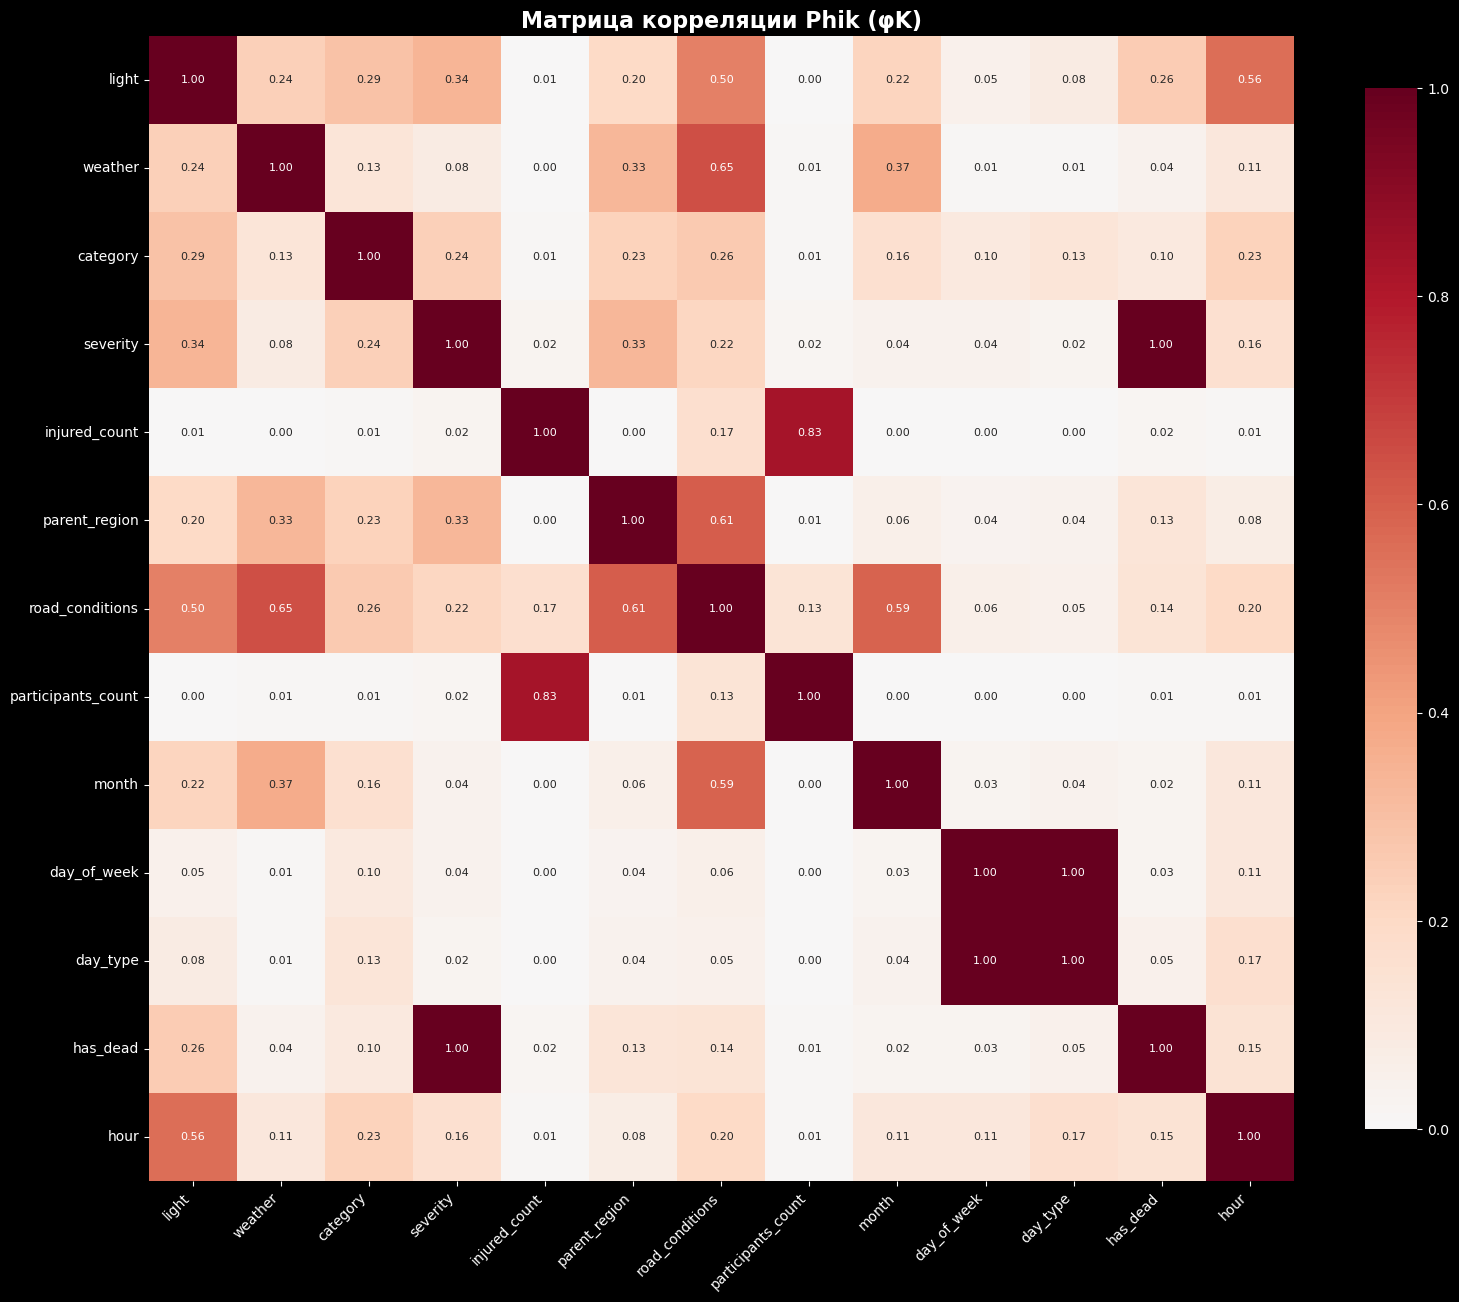

In [412]:
plt.figure(figsize=(16, 14))
sns.heatmap(phik_matrix, 
            annot=True,          
            cmap='RdBu_r', 
            center=0,
            square=True, 
            cbar_kws={"shrink": .8},
            fmt='.2f',          
            annot_kws={'size': 8})  

plt.xticks(rotation=45, ha='right') 
plt.title('Матрица корреляции Phik (φK)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Отфильтруем только сильные корреляции

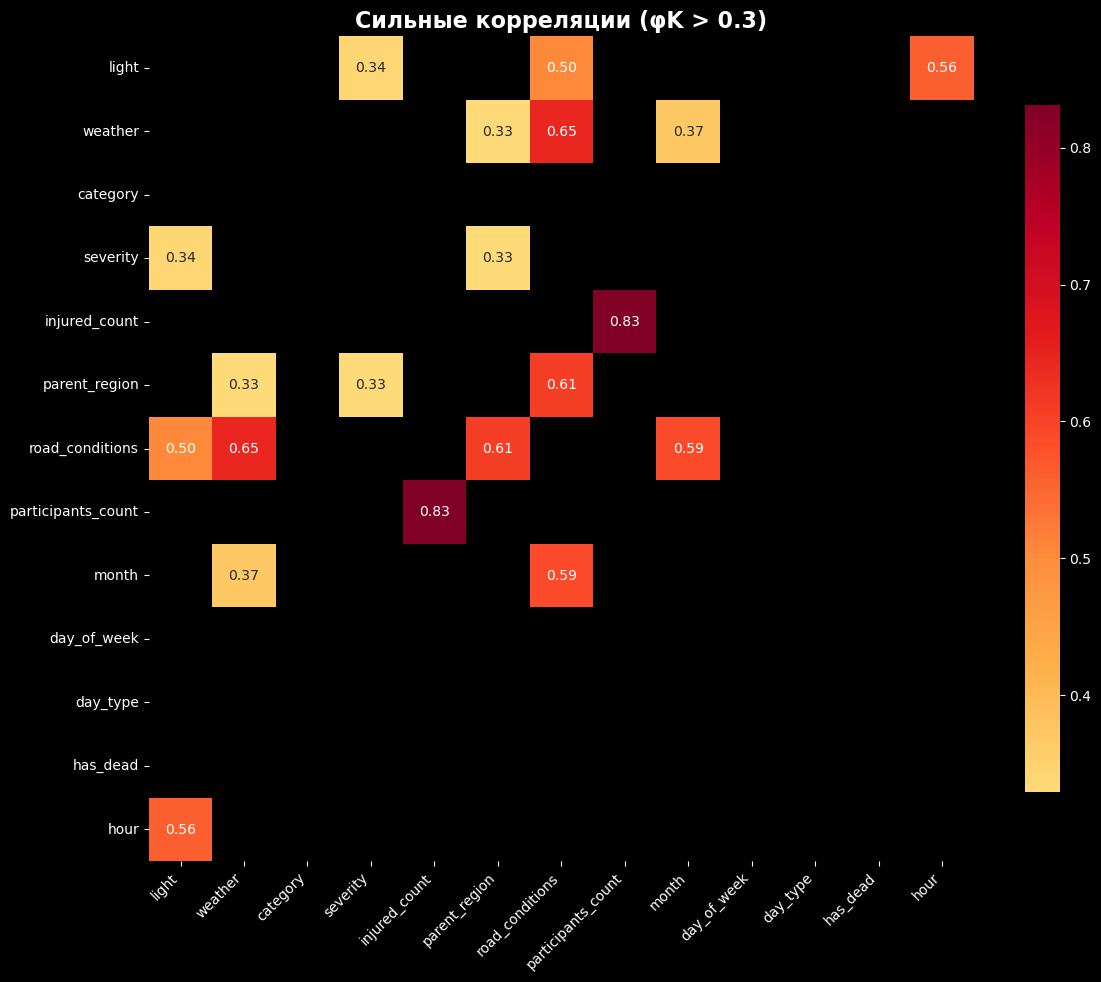

In [414]:
strong_corr = phik_matrix[phik_matrix > 0.3]
strong_corr = strong_corr[strong_corr < 0.999]  # Убираем диагональ

plt.figure(figsize=(12, 10))
sns.heatmap(strong_corr, annot=True, cmap='YlOrRd', center=0.5,
            square=True, cbar_kws={"shrink": .8}, fmt='.2f')
plt.xticks(rotation=45, ha='right') 
plt.title('Сильные корреляции (φK > 0.3)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

- Есть логичные корреляции injured_count - participants_count (количество пострадавших коррелирует с количеством участников), hour - light (час и время дня), weather - road_conditions (погодные условия и дорожное покрытие, заснеженное и пр. например) и другие.
- Есть сильная коррелция между регионом и состоянием дорожного покрытия, возможно это опять связано с погодой, т.к. в road_condions более 7000 тысяч вариантов покрытия. А также между регионом и тяжестью дтп
- Есть корреляция между категорией аварии и степенью тяжести

## Основные выводы по анализу

- Масштаб проблемы: за 10 лет зафиксировано 1 465 882 ДТП, из них 51 734 - в 2025 году
- Лидер по количеству: Центральный ФО (14 017 ДТП в 2025). На 100к населения лидер Сибирский ФО (126 на 100к), минимальное количество в целом и на 100к населения: Северо-Кавказский ФО (2 703 ДТП всего и 52 на 100К населения)
- По регионам. По количеству лидирует Москва 3 679 ДТП и Краснодарский край - 2467 дтп в 2025, Краснодарский край также лидирует и по количеству дтп на 100К населения (129 ДТП на 100к)
- За период 2015-2025 виден тренд снижения как общего количества ДТП так и конкретно смертельных случаев и случаев, где получили ранения
- Пик аварийности: летние месяцы (апрель-октябрь)
- Будни: 71-72% всех ДТП, выходные: 27-29% (каждая третья смертельная авария), пик смертности: суббота (рост с четверга)
- Дневные аварии: 68%, вечерние: 21% (освещение включено), ночные: 9% (освещение отсутствует). Ночные ДТП без освещения: 25% летальности (vs 7% днем), неизменная ситуация за 10 лет
- Распределение ролей (стабильное 2015-2025): водители: 66%, пассажиры: 21%, пешеходы: 11%, велосипедисты: 1.5%
- Статус здоровья: невредимы: 42%, ранены: 48.1%, погибли: 3%
- Группы риска (вероятность гибели): дорожные рабочие: 22-23%, пешеходы, вышедшие из ТС: 16%, пешеходы: 8-10%, велосипедисты: 5-7%, пассажиры: 5-6%, водители: 3%
- Стаж водителей (2025): опытные (10-40 лет): 63% ДТП, новички (0-1 год): 4%
- Гендерные различия: мужчины: 70.1% ДТП (выше смертность), женщины: 29.9% ДТП (чаще травмы, реже смерть)
- Внешние условия. Погода: ясная погода: 67% ДТП (4.5% смертности), пасмурно: 28%, опасные условия: ураган, туман, метель (11-15% смертности)
- Дорожное покрытие: сухое: 44-47% ДТП, мокрое: 12-13%, отсутствие покрытия: 8-10%
- Транспортные средства. Классы автомобилей (2025): B-класс: 37.8%, C-класс: 14%, прочие легковые: 9.7%
- Возраст ТС: Старые (11-20 лет): 41-54%, очень старые (20+ лет): 15-26%, новые (0-3 года): 2-16%
- Типы ДТП и риски. Распространенность (2025): столкновения: 68 261 участник, наезды на пешеходов: 26 962, съезды с дороги: 10 539
- Высокий травматизм (>68%): опрокидывания: 77.3%, наезды на препятствия: 68.8%, съезды с дороги: 68.2%
- Высокая летальность (>8%): дорожные рабочие: 11.4-11.7%, прочие участники около дорог: 10.2-11.2%, возгорания ТС: 8.6-9.1%

# 4 Проверка гипотез

У нас есть несколько предложенных гипотез:
- Всему виной пьяные водители, надо усилить наказание
- Безопасность на дорогах растет для каждого из участников
- В личном автомобиле ехать безопаснее чем в автобусе
- Если пешеходы не будут нарушать, то не будут гибнуть
- Низкая скорость не влияет на тяжесть ДТП

А также несколько гипотез, которые возникли в процессе анализа:
 - Ехать в дорогой машине безопаснее
 - Дорожное покрытие влияет на тяжесть дтп

## Первая гипотеза - Всему виной пьяные водители, надо усилить наказание

Создадим несколько дополнительных столбцов в датафрейме `participants_df_2025`. 

- Столбец `is_alcohol`, где будет 1 если в столбце `violations` встречаются слова "алког", "опьян", "пьян", "этил", "спирт" и 0 если не встречаются
- Столбец `is_driver`, где будет 1 если в столбце `role` встречается слово "водитель"
- Столбец  `drunk_driver`, где будет 1 если в столбцах `is_alcohol` и `is_driver` стоят 1

In [423]:
alcohol_keywords = ["алког", "опьян", "пьян", "этил", "спирт"]
alc_pat = re.compile("|".join(alcohol_keywords), flags=re.IGNORECASE)

participants_df['is_alcohol'] = participants_df['violations'].astype(str).str.contains(alc_pat, na=False)

participants_df['is_driver'] = participants_df['role'].str.contains("Водитель", case=False, na=False)

participants_df['drunk_driver'] = participants_df['is_alcohol'] & participants_df['is_driver']

Проверим

In [425]:
participants_df.sample(2)

id vehicle_id                              vehicle_category  \
1033842  1295122  1295122_1                                 Рефрижераторы   
997708   1436551  1436551_1  С-класс (малый средний, компактный) до 4,3 м   

             role   gender                     violations  \
1033842  Водитель  Мужской                                  
997708   Водитель  Мужской  Несоблюдение требований ОСАГО   

                                             health_status  \
1033842  Раненый, находящийся (находившийся) на стацион...   
997708   Раненый, находящийся (находившийся)  на амбула...   

         years_of_driving_experience  year  dead  injured  unharmed  \
1033842                           13  2020     0        1         0   
997708                             5  2015     0        1         0   

         exp_group  is_alcohol  is_driver  drunk_driver  
1033842  10–20 лет       False       True         False  
997708    3–10 лет       False       True         False

Сгруппируем данные по id аварии, т.к. один id на несколько участников и укажем, что водитель был пьян если хотя бы один из участников одной аварии был пьян

In [427]:
drunk_dtp = participants_df.groupby('id')['drunk_driver'].max().reset_index()
drunk_dtp.rename(columns={'drunk_driver': 'has_drunk_driver'}, inplace=True)

Объединим с основным датафреймом, а пропуски заполним False, т.к. по этим строчках нет пьяных водителей 

In [429]:
gdf_drunk = gdf.merge(drunk_dtp, on='id', how='left')

gdf_drunk['has_drunk_driver'] = gdf_drunk['has_drunk_driver'].fillna(False)
gdf_drunk.sample(2)

geometry      id                light  \
1286132  POINT (83.94005 56.74291)  174704  Светлое время суток   
137429   POINT (38.69668 56.65059)  682783  Светлое время суток   

                                                    nearby  \
1286132                                                      
137429   Жилые дома индивидуальной застройки, Автостоян...   

                     region scheme  \
1286132           Шегарский    200   
137429   Переславский район    910   

                                                   address   weather  \
1286132                 Томск - Каргала - Колпашево, 87 км  Снегопад   
137429   М-8 Холмогоры Москва - Ярославль - Вологда – А...  Пасмурно   

                    category            datetime severity  dead_count  \
1286132         Столкновение 2025-03-21 19:10:00  Тяжёлый           0   
137429   Наезд на стоящее ТС 2022-01-29 08:40:00   Легкий           0   

         injured_count        parent_region  \
1286132              2      Томская область   
137429               1  Ярославская область   

                                           road_conditions  \
1286132  Отсутствие, плохая различимость горизонтальной...   
137429         Обработанное противогололедными материалами   

         participants_count participant_categories   lat  long  year  month  \
1286132                   7          Все участники 56.74 83.94  2025      3   
137429                    2          Все участники 56.65 38.70  2022      1   

        day_of_week federal_district  hour  day_type  has_dead    time_period  \
1286132      Friday        Сибирский    19     Будни     False  Вечер (18-24)   
137429     Saturday      Центральный     8  Выходной     False    Утро (6-12)   

        has_drunk_driver  
1286132            False  
137429             False

In [430]:
gdf_drunk['has_drunk_driver'].value_counts()

has_drunk_driver
False    1286458
True      179424
Name: count, dtype: int64

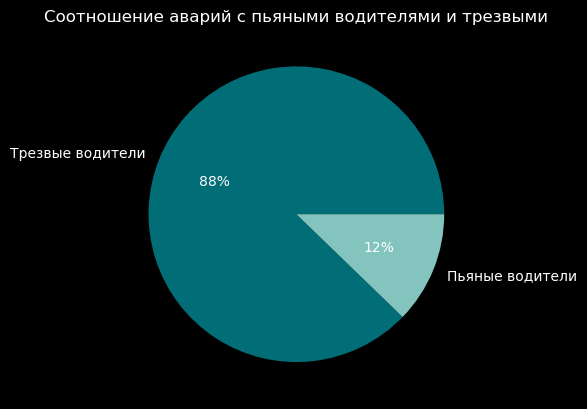

In [431]:
labels = ['Трезвые водители', 'Пьяные водители']

gdf_drunk['has_drunk_driver'].value_counts().plot(
    kind= 'pie',
    title='Соотношение аварий с пьяными водителями и трезвыми',
    autopct= '%.0f%%',
    ylabel= '',
    colors= ['#006d77', '#83c5be'],
    labels = labels
)

plt.show()

Аварий с трезвыми водителями кратно больше, 88%, пьяных аварий 12%

Посмотрим распределение аварий по степени тяжести

In [434]:
pivot = pd.pivot_table(gdf_drunk, index='has_drunk_driver', columns='severity', values='id', aggfunc='count')
pivot

severity          Легкий  С погибшими  Тяжёлый
has_drunk_driver                              
False             757207       106459   422792
True               72548        33893    72983

Посмотрим в относительных значениях

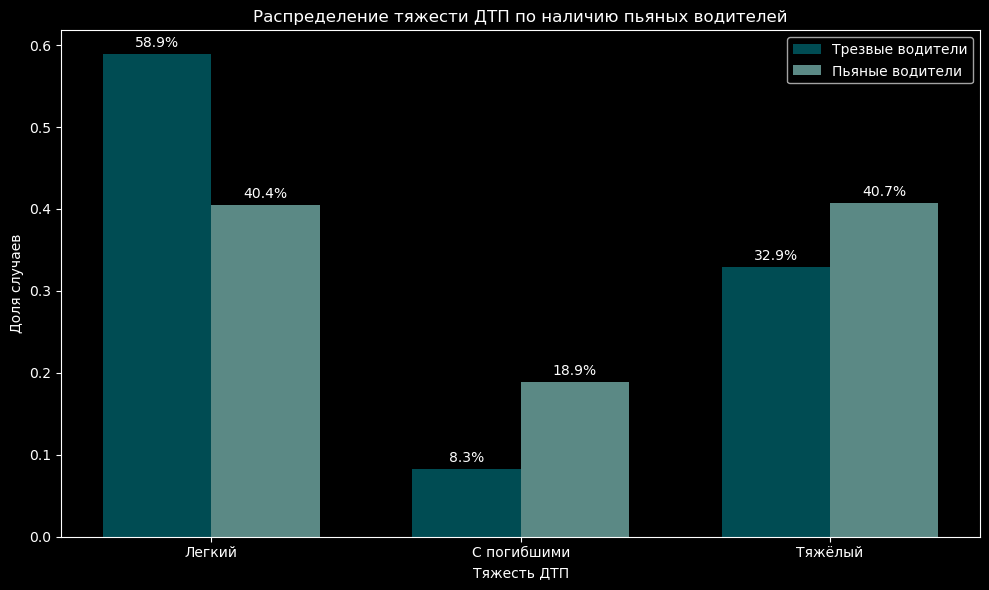

In [436]:
severity_data = gdf_drunk.groupby('has_drunk_driver')['severity'].value_counts(normalize=True).unstack()

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(severity_data.columns))  # позиции по оси X
width = 0.35  # ширина столбцов
bars1 = ax.bar(x - width/2, severity_data.loc[False], width, 
               label='Трезвые водители', color='#006d77', alpha=0.7)

bars2 = ax.bar(x + width/2, severity_data.loc[True], width, 
               label='Пьяные водители', color='#83c5be', alpha=0.7)

ax.set_xlabel('Тяжесть ДТП')
ax.set_ylabel('Доля случаев')
ax.set_title('Распределение тяжести ДТП по наличию пьяных водителей')
ax.set_xticks(x)
ax.set_xticklabels(severity_data.columns)
ax.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1%}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

Если водитель пьян, то вероятность погибнуть или получить тяжелый урон выше. 8.3% погибнуть при трезвом водителе и 18.9% при пьяном водителе, 32.9% получить тяжелый урон при трезвом водителе и 40.7% при пьяном

Посмотрим среднее колчиство погибших и пострадавших на одно дтп

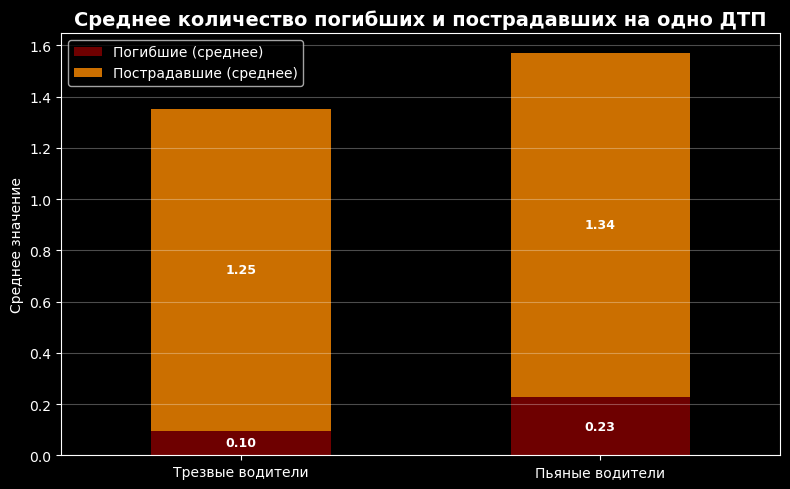

In [439]:
agg_data = gdf_drunk.groupby('has_drunk_driver')[['dead_count', 'injured_count']].agg(['sum', 'mean']) 

agg_data.columns = ['dead_sum', 'dead_mean', 'injured_sum', 'injured_mean'] 

ax = agg_data[['dead_mean', 'injured_mean']].plot(
    kind='bar',
    stacked=True,
    figsize=(8,5),
    color=['darkred','darkorange'],
    alpha=0.8
)

ax.set_title('Среднее количество погибших и пострадавших на одно ДТП', fontsize=14, fontweight='bold')
ax.set_ylabel('Среднее значение')
ax.set_xticks([0,1])
ax.set_xticklabels(['Трезвые водители','Пьяные водители'], rotation=0)
ax.grid(alpha=0.3, axis='y')

ax.legend(['Погибшие (среднее)', 'Пострадавшие (среднее)'])


for p in ax.patches:
    height = p.get_height()
    if height > 0:  # только для ненулевых значений
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2, p.get_y() + height/2),
                    ha='center', va='center',
                    color='white', fontweight='bold', fontsize=9)
ax.set_xlabel("")
plt.tight_layout()
plt.show()

В среднем пострадавших и погибших в дтп больше если водитель был пьян, проведем статистические тесты для проверки гипотезы 

Гипотеза звучит так: всему виной пьяные водители, надо усилить наказание. Перефразируем, наличие пьяного водителя в ДТП существенно повышает вероятность гибели участников. Проверим это, используя z тест пропорций:

- Нулевая гипотеза H₀: вероятность ДТП с погибшими одинакова в группах с пьяными и трезвыми водителями.

- Альтернативная гипотеза H₁: вероятность ДТП с погибшими выше в группе с пьяными водителями.

In [442]:
drunk = gdf_drunk[gdf_drunk['has_drunk_driver'] == True]
sober = gdf_drunk[gdf_drunk['has_drunk_driver'] == False]

count = [ (drunk['dead_count'] > 0).sum(),
          (sober['dead_count'] > 0).sum() ]

nobs = [ len(drunk), len(sober) ]

stat, pval = proportions_ztest(count, nobs, alternative='larger')

print("Количество ДТП с погибшими [пьяные, трезвые]:", count)
print("Размер выборки [пьяные, трезвые]:", nobs)
print(f"Z-статистика = {stat:.3f}, p-value = {pval:.5f}")

Количество ДТП с погибшими [пьяные, трезвые]: [33893, 106459]
Размер выборки [пьяные, трезвые]: [179424, 1286458]
Z-статистика = 143.148, p-value = 0.00000


Отвергаем нулевую гипотезу, т.к. разница в вероятности ДТП с погибшими между группами статистически значима. В группе с пьяными водителями вероятность гибели участников заметно выше (более чем в 2 раза)

Наличие пьяного водителя существенно увеличивает риск смертельного исхода в ДТП. Возможно более серьезный контроль за пьяными водителями или увеличение наказания действительно не лишняя мера.

Посмотрим на количество пострадавших от пьяных и трезвых водителей

Построим гистограмму и график QQ-plot чтобы определиться с статистическим тестом

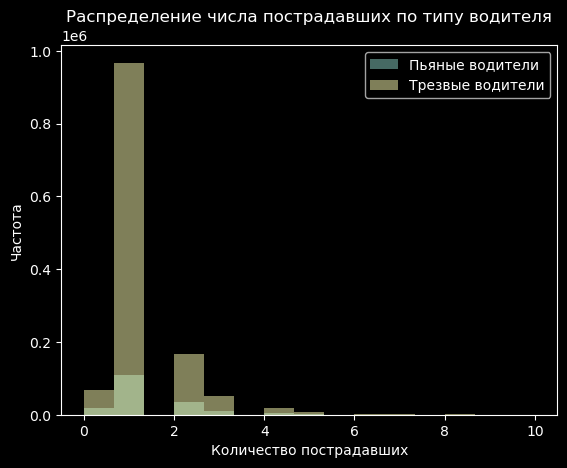

In [446]:
plt.hist(
    gdf_drunk[gdf_drunk['has_drunk_driver'] == True]['injured_count'].dropna(), 
    bins=15, alpha=0.5, label='Пьяные водители', range=(0, 10)
)
plt.hist(
    gdf_drunk[gdf_drunk['has_drunk_driver'] == False]['injured_count'].dropna(), 
    bins=15, alpha=0.5, label='Трезвые водители', range=(0, 10)
)
plt.legend()
plt.title('Распределение числа пострадавших по типу водителя')
plt.xlabel('Количество пострадавших')
plt.ylabel('Частота')
plt.show()

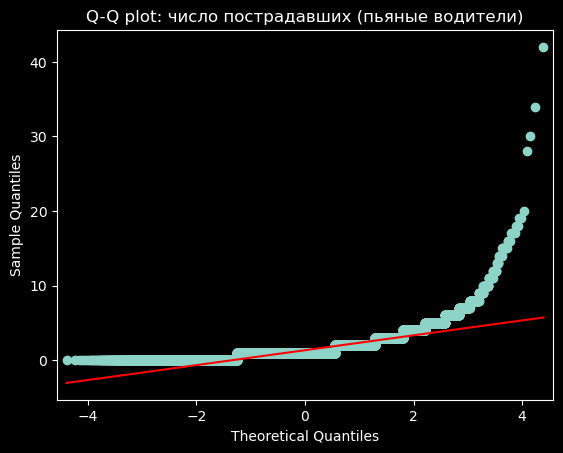

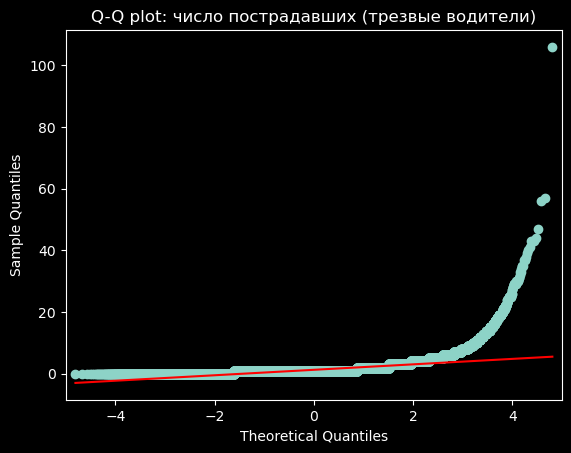

In [447]:
drunk = gdf_drunk[gdf_drunk['has_drunk_driver'] == True]['injured_count'].dropna()
sober = gdf_drunk[gdf_drunk['has_drunk_driver'] == False]['injured_count'].dropna()

# Q-Q plot для пьяных
sm.qqplot(drunk, line='s')
plt.title("Q-Q plot: число пострадавших (пьяные водители)")
plt.show()

# Q-Q plot для трезвых
sm.qqplot(sober, line='s')
plt.title("Q-Q plot: число пострадавших (трезвые водители)")
plt.show()

In [448]:
levene_test = levene(
    gdf_drunk[gdf_drunk['has_drunk_driver'] == True]['injured_count'].dropna(),
    gdf_drunk[gdf_drunk['has_drunk_driver'] == False]['injured_count'].dropna()
)

print(f"Статистика теста Левена: {levene_test.statistic:.4f}")
print(f"P-value: {levene_test.pvalue:.8f}") 


# Интерпретация:
if levene_test.pvalue < 0.05:
    print("\nДисперсии статистически значимо различаются")
else:
    print("\nНет оснований отвергать гипотезу о равенстве дисперсий")

Статистика теста Левена: 7745.4312
P-value: 0.00000000

Дисперсии статистически значимо различаются


Данные распределены не нормально, будем использваоть тест Манна — Уитни:

Гипотеза: Увеличивает ли наличие пьяного водителя СРЕДНЕЕ ЧИСЛО пострадавших в ДТП. 
- Нулевая гипотеза H₀: Распределение количества пострадавших в ДТП одинаково для групп с пьяными и трезвыми водителями

- Альтернативная гипотеза H₁: В ДТП с пьяными водителями количество пострадавших выше чем в ДТП с трезвыми водителями.

In [451]:
drunk = gdf_drunk.loc[gdf_drunk['has_drunk_driver'] == True, 'injured_count'].dropna()
sober = gdf_drunk.loc[gdf_drunk['has_drunk_driver'] == False, 'injured_count'].dropna()

u_stat, p_val = mannwhitneyu(drunk, sober, alternative='greater')
print(f"Mann–Whitney U: U={u_stat:.0f}, p-value={p_val:.5f}")

# Эффект-размеры
n1, n2 = len(drunk), len(sober)
mean_U = n1*n2/2
sd_U = math.sqrt(n1*n2*(n1+n2+1)/12)
z = (u_stat - mean_U)/sd_U
r = z / math.sqrt(n1+n2)                
cliffs_delta = (2*u_stat)/(n1*n2) - 1  

print(f"Z≈{z:.3f}, r≈{r:.3f}, Cliff’s δ≈{cliffs_delta:.3f}")

# Для наглядности — медианы
print("Медианы injured_count:",
      f"drunk={drunk.median()}, sober={sober.median()}")

Mann–Whitney U: U=120922104742, p-value=0.00000
Z≈32.822, r≈0.027, Cliff’s δ≈0.048
Медианы injured_count: drunk=1.0, sober=1.0


Гипотеза подтверждается частично: наличие пьяного водителя действительно увеличивает тяжесть ДТП, но только для относительно редких случаев крупных аварий. Величина эффекта крайне мала (r ≈ 0.03, Cliff’s δ ≈ 0.06), а медианы совпадают (1 пострадавший).
Практически же, в большинстве ДТП число пострадавших остаётся одинаковым для обеих групп.

Общий вывод
Гипотеза «наличие пьяного водителя значительно повышает опасность ДТП» подтверждается.

Влияние выражается в двух аспектах:
- Смертельный исход наступает существенно чаще (результат z-теста).
- Распределение числа пострадавших сдвинуто в сторону более тяжёлых случаев у пьяных (результат Манна–Уитни).

Однако «типичное» ДТП (с 1 пострадавшим) одинаково как у трезвых, так и у пьяных. Ключевое различие именно в повышенной вероятности катастрофических последствий.

## Вторая гипотеза - безопасность на дорогах растет для каждого из участников.

- Нулевая гипотеза H₀: Уровень безопасности на дорогах не изменился за период 2015-2025 годов для всех категорий участников дорожного движения

- Альтернативная гипотеза H₁: Уровень безопасности на дорогах повысился за период 2015-2025 годов для всех категорий участников дорожного движения.

Сгруппируем данные по годам и посчитаем необходимые показатели

In [457]:
year_agg = gdf.groupby('year').agg(
    accidents = ('id', 'count'),
    fatal_accidents = ('has_dead', 'sum'),
    dead_sum = ('dead_count', 'sum'),
    injured_sum = ('injured_count', 'sum')).reset_index()

year_agg

year  accidents  fatal_accidents  dead_sum  injured_sum
0   2015     169905            18315     21597       213290
1   2016     160252            15956     18882       204264
2   2017     156452            14983     17791       198969
3   2018     154490            14353     16975       197696
4   2019     151713            13475     15853       194779
5   2020     135519            13020     15103       171170
6   2021     124215            11778     13819       156359
7   2022     117582            11224     13158       148130
8   2023     122803            11371     13436       154285
9   2024     121217            11285     13269       151253
10  2025      51734             4592      5368        64280

Возьмем "длинный" датафрейм о населении, который мы сделали ранее и сгруппируем по годам и просуммируем население

In [459]:
pop_russia = population_long.groupby('year')['population'].sum().reset_index()
pop_russia

year  population
0  2015   138561.00
1  2016   138878.00
2  2017   139189.00
3  2018   139312.00
4  2019   139278.00
5  2020   139291.00
6  2021   139962.00
7  2022   138290.00
8  2023   139352.00
9  2024   139190.00

In [460]:
merged = year_agg.merge(pop_russia, on='year', how='left')
merged

year  accidents  fatal_accidents  dead_sum  injured_sum  population
0   2015     169905            18315     21597       213290   138561.00
1   2016     160252            15956     18882       204264   138878.00
2   2017     156452            14983     17791       198969   139189.00
3   2018     154490            14353     16975       197696   139312.00
4   2019     151713            13475     15853       194779   139278.00
5   2020     135519            13020     15103       171170   139291.00
6   2021     124215            11778     13819       156359   139962.00
7   2022     117582            11224     13158       148130   138290.00
8   2023     122803            11371     13436       154285   139352.00
9   2024     121217            11285     13269       151253   139190.00
10  2025      51734             4592      5368        64280         NaN

Добавим столбцы со смертельными дтп, количеством пострадавших и погибших в пересчете на 100к населения

In [462]:
merged['fatal_accidents_per100k'] = merged['fatal_accidents'] / merged['population'] * 100
merged['dead_per100k'] = merged['dead_sum'] / merged['population'] * 100
merged['accidents_per100k'] = merged['accidents'] / merged['population'] * 100
merged['injured_per100k'] = merged['injured_sum'] / merged['population'] * 100

Построим график, исключив 2025 год

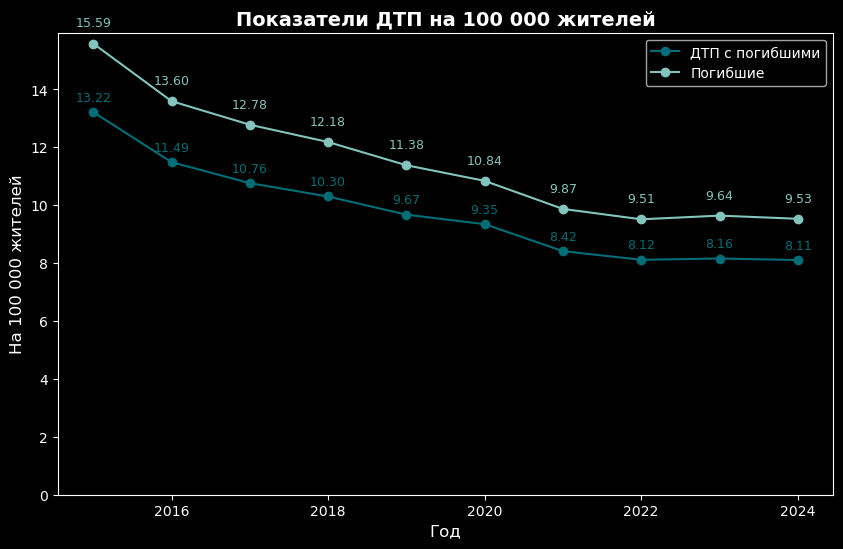

In [464]:
merged_plot = merged[merged['year'] < 2025]

plt.figure(figsize=(10,6))

plt.plot(merged_plot['year'], merged_plot['fatal_accidents_per100k'], 
         marker='o', label='ДТП с погибшими', color='#006d77')
plt.plot(merged_plot['year'], merged_plot['dead_per100k'], 
         marker='o', label='Погибшие', color='#83c5be')

for x, y in zip(merged_plot['year'], merged_plot['fatal_accidents_per100k']):
    plt.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0,8), ha='center', fontsize=9, color='#006d77')

for x, y in zip(merged_plot['year'], merged_plot['dead_per100k']):
    plt.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0,12), ha='center', fontsize=9, color='#83c5be')

plt.title("Показатели ДТП на 100 000 жителей", fontsize=14, fontweight="bold")
plt.xlabel("Год", fontsize=12)
plt.ylabel("На 100 000 жителей", fontsize=12)
plt.legend()
plt.ylim(0, None)

plt.show()

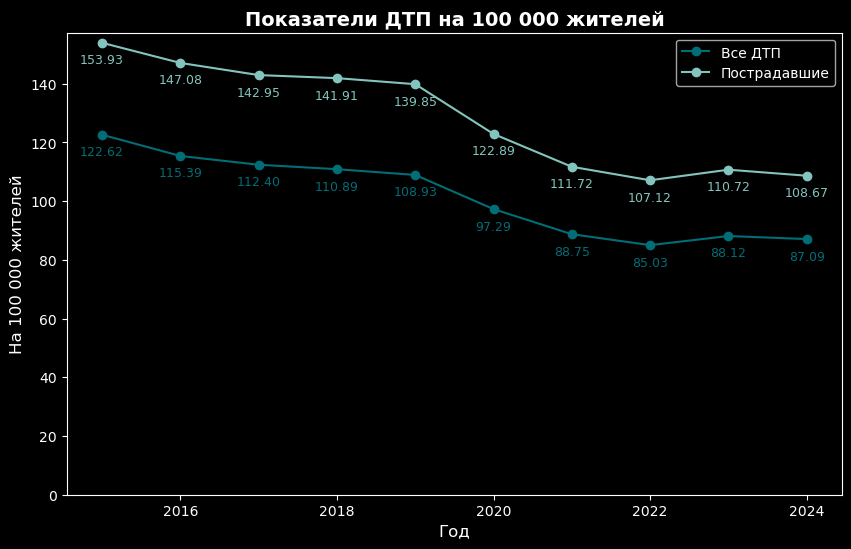

In [465]:
plt.figure(figsize=(10,6))

plt.plot(merged_plot['year'], merged_plot['accidents_per100k'], 
         marker='o', label='Все ДТП', color='#006d77')
plt.plot(merged_plot['year'], merged_plot['injured_per100k'], 
         marker='o', label='Пострадавшие', color='#83c5be')

for x, y in zip(merged_plot['year'], merged_plot['accidents_per100k']):
    plt.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=9, color='#006d77')

for x, y in zip(merged_plot['year'], merged_plot['injured_per100k']):
    plt.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=9, color='#83c5be')

plt.title("Показатели ДТП на 100 000 жителей", fontsize=14, fontweight="bold")
plt.xlabel("Год", fontsize=12)
plt.ylabel("На 100 000 жителей", fontsize=12)
plt.legend()
plt.ylim(0, None)

plt.show()

Т.к. категорий много, то мы посмотрим на основные: пассажир, водитель, пешеход, велосепедист

In [467]:
roles = ['Водитель', 'Пассажир', 'Велосипедист', 'Пешеход']
participants_df_role = participants_df[(participants_df['role'].isin(roles)) & (participants_df['year'] != 2025)]

In [468]:
participants_agg = participants_df_role.groupby(['year', 'role']).agg(
    dead_sum=('dead', 'sum'),
    injured_sum=('injured', 'sum'),
    unharmed_sum=('unharmed', 'sum'),
    participants=('id', 'count')  
).reset_index()

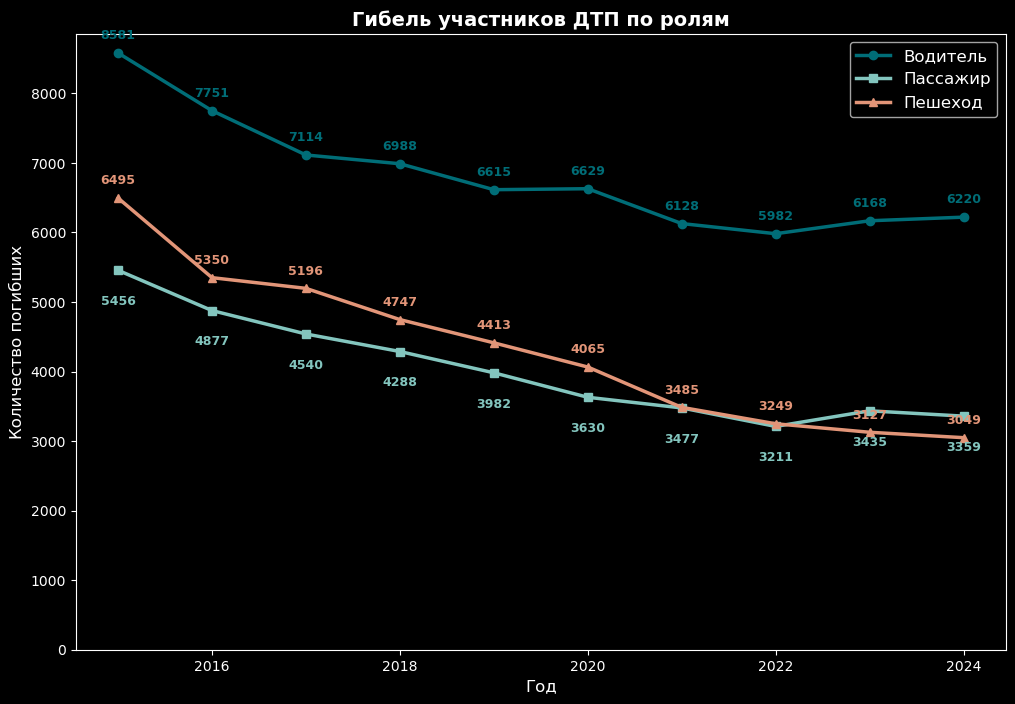

In [469]:
plt.figure(figsize=(12, 8))

driver_data = participants_agg[participants_agg['role'] == 'Водитель']
passenger_data = participants_agg[participants_agg['role'] == 'Пассажир']
pedestrian_data = participants_agg[participants_agg['role'] == 'Пешеход']

plt.plot(driver_data['year'], driver_data['dead_sum'], 
         marker='o', label='Водитель', color='#006d77', linewidth=2.5)

plt.plot(passenger_data['year'], passenger_data['dead_sum'], 
         marker='s', label='Пассажир', color='#83c5be', linewidth=2.5)

plt.plot(pedestrian_data['year'], pedestrian_data['dead_sum'], 
         marker='^', label='Пешеход', color='#e29578', linewidth=2.5)

plt.title('Гибель участников ДТП по ролям', fontweight='bold', fontsize=14)
plt.xlabel('Год', fontsize=12)
plt.ylabel('Количество погибших', fontsize=12)
plt.legend(fontsize=12)


for _, row in driver_data.iterrows():
    plt.annotate(int(row['dead_sum']), 
                 (row['year'], row['dead_sum']), textcoords="offset points", xytext=(0, 10), 
                 ha='center', fontsize=9, fontweight='bold', color='#006d77')

for _, row in passenger_data.iterrows():
    plt.annotate(int(row['dead_sum']), 
                 (row['year'], row['dead_sum']), textcoords="offset points", xytext=(0, -25), 
                 ha='center', fontsize=9, fontweight='bold', color='#83c5be')

for _, row in pedestrian_data.iterrows():
    plt.annotate(int(row['dead_sum']), (row['year'], row['dead_sum']), textcoords="offset points", 
                 xytext=(0, 10), ha='center', fontsize=9, fontweight='bold', color='#e29578')

plt.ylim(0, None)
plt.show()

Посмотрим на велосипедистов отдельно, т.к. количество меньше и на графике будет плохо виден тренд, если он есть

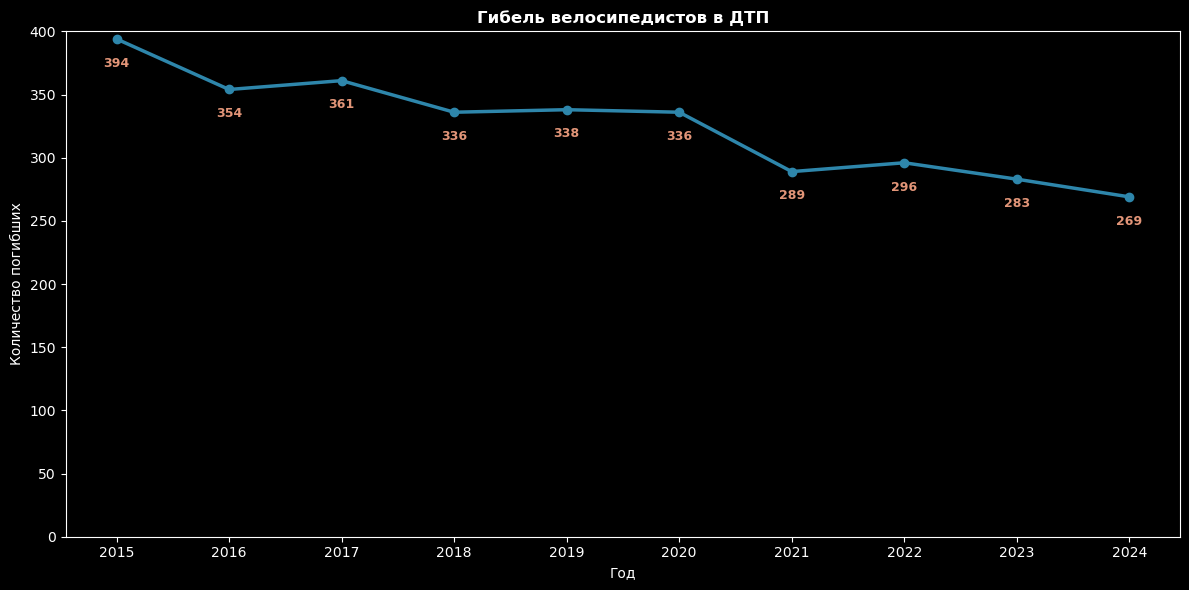

In [471]:
plt.figure(figsize=(12,6))

bicyclist_data = participants_agg[participants_agg['role'] == 'Велосипедист']

plt.plot(bicyclist_data['year'], bicyclist_data['dead_sum'], marker='o', 
         label='Велосипедист', color='#2E86AB', linewidth=2.5)

plt.title('Гибель велосипедистов в ДТП', fontweight='bold')
plt.ylabel('Количество погибших')
plt.xlabel('Год')
plt.ylim(0, None)

for _, row in bicyclist_data.iterrows():
    plt.annotate(int(row['dead_sum']), (row['year'], row['dead_sum']), textcoords="offset points", 
                 xytext=(0, -20), ha='center', fontsize=9, fontweight='bold', color='#e29578')

plt.xticks(bicyclist_data['year'].unique())
plt.tight_layout()
plt.show()

Проведем линейный регрессионный анализ для оценки статистической значимости трендов смертности по категориям участников ДТП

In [473]:
def test_trend(years, values, category):
    """Проверка статистической значимости тренда"""
    slope, intercept, r_value, p_value, std_err = stats.linregress(years, values)
    
    print(f"{category}:")
    print(f"  Наклон: {slope:.4f} (отрицательный = улучшение)")
    print(f"  R²: {r_value**2:.4f}")
    print(f"  p-value: {p_value:.5f}")
    print(f"  Стат. значимость: {'ДА' if p_value < 0.05 else 'НЕТ'}")
    print(f"  Направление: {'СНИЖЕНИЕ' if slope < 0 else 'РОСТ'}")
    return p_value < 0.05

categories = participants_agg[participants_agg['year'] != 2025]['role'].unique()
significant_improvements = []

for category in categories:
    data = participants_agg[participants_agg['role'] == category]
    is_significant = test_trend(data['year'], data['dead_sum'], category)
    if is_significant:
        significant_improvements.append(category)
    print("---")

print(f"\nСтатистически значимые улучшения: {significant_improvements}")

Велосипедист:
  Наклон: -12.6667 (отрицательный = улучшение)
  R²: 0.9229
  p-value: 0.00001
  Стат. значимость: ДА
  Направление: СНИЖЕНИЕ
---
Водитель:
  Наклон: -245.7939 (отрицательный = улучшение)
  R²: 0.8135
  p-value: 0.00036
  Стат. значимость: ДА
  Направление: СНИЖЕНИЕ
---
Пассажир:
  Наклон: -232.7091 (отрицательный = улучшение)
  R²: 0.8899
  p-value: 0.00004
  Стат. значимость: ДА
  Направление: СНИЖЕНИЕ
---
Пешеход:
  Наклон: -366.3273 (отрицательный = улучшение)
  R²: 0.9464
  p-value: 0.00000
  Стат. значимость: ДА
  Направление: СНИЖЕНИЕ
---

Статистически значимые улучшения: ['Велосипедист', 'Водитель', 'Пассажир', 'Пешеход']


Основные категории участников показывают снижение смертности и снижение статичтиески значимо. 

In [475]:
def calculate_reduction(data, category):
    """Расчет процентного изменения смертности за весь период"""
    subset = data[data['role'] == category]
    first_value = subset['dead_sum'].iloc[0]  
    last_value = subset['dead_sum'].iloc[-1]  
    reduction = ((first_value - last_value) / first_value * 100)
    return reduction

reductions = {}
for category in categories:
    reductions[category] = calculate_reduction(participants_agg, category)

print("Снижение смертности за период:")
for category, reduction in sorted(reductions.items(), key=lambda x: x[1], reverse=True):
    trend_icon = "▼" if reduction > 0 else "▲" if reduction < 0 else "●"
    print(f"{trend_icon} {category}: {reduction:+.1f}%")

Снижение смертности за период:
▼ Пешеход: +53.1%
▼ Пассажир: +38.4%
▼ Велосипедист: +31.7%
▼ Водитель: +27.5%


За период 2015-2025 происходит явное снижение смертоности участников.

In [477]:
df = merged.dropna(subset=['dead_per100k'])

tau, pval = kendalltau(df['year'], df['dead_per100k'])
print(f"Kendall τ={tau:.3f}, p-value={pval:.5f}")

Kendall τ=-0.911, p-value=0.00003


Наблюдается очень сильная отрицательная монотонная связь (τ = -0.911). Тренд снижения смертности статистически значим (p < 0.00003), высокая вероятность, что снижение смертности не является случайным. Тенденция снижения последовательна и устойчива во времени

In [479]:
metrics = ['accidents_per100k', 'fatal_accidents_per100k', 'injured_per100k']
results = []

for m in metrics:
    df = merged.dropna(subset=[m])
    tau, pval = kendalltau(df['year'], df[m])
    results.append((m, tau, pval))

results_df = pd.DataFrame(results, columns=['метрика', 'τ', 'p-value'])
results_df

метрика     τ  p-value
0        accidents_per100k -0.91     0.00
1  fatal_accidents_per100k -0.96     0.00
2          injured_per100k -0.91     0.00

Остальные показатели: количество дтп, количество пострадавших также показывают снижение.

Общий вывод
Гипотеза «безопасность на дорогах растет для каждого из участников» подтверждается:
- По всем категориям участников (водители, пассажиры, пешеходы, велосипедисты) наблюдается статистически значимое снижение смертности за период 2015–2024 г.
- У пешеходов максимальное снижение смертоности за период - 53.1%
- Меньше всего снижение смертности у водителей - 27.5% 
- Безопасность на дорогах системно улучшается.

## Третья гипотеза - В личном автомобиле ехать безопаснее чем в автобусе

Перефразируем гипотезу, Участники ДТП в личных автомобилях имеют более низкую вероятность гибели или травмирования по сравнению с участниками ДТП в автобусах. Проверим это, используя z тест пропорций:

- Нулевая гипотеза H₀: Вероятность гибели или травмирования участников ДТП одинакова для личных автомобилей и автобусов

- Альтернативная гипотеза H₁: Вероятность гибели или травмирования участников ДТП ниже в личных автомобилях по сравнению с автобусами

Выпишем все классы легковых автомобилей и автобусов

In [485]:
CAR_LABELS = {
    'А-класс (особо малый) до 3,5 м',
    'В-класс (малый) до 3,9 м',
    'С-класс (малый средний, компактный) до 4,3 м',
    'D-класс (средний) до 4,6 м',
    'Е-класс (высший средний, бизнес-класс) до 4,9 м',
    'S-класс (высший, представительский класс) более 4,9 м',
    'Минивэны и универсалы повышенной вместимости',
    'Прочие легковые автомобили',
    'Легковые автомобили (без типа)'
}

BUS_LABELS = {
    'Автобусы (без типа)',
    'Одноэтажные длиной не более 5 м',
    'Одноэтажные длиной от 5 до 8 м',
    'Одноэтажные длиной от 8 до 12 м',
    'Одноэтажные, сочлененные длиной более 12 м',
    'Двухярусные',
    'Школьные автобусы'
}

Создадим датафрейм с участниками, которые водители и пассажиры, затем присоединим датафрейм с тс, чтобы оставить только автобусы и автомобили

In [487]:
df_roles = participants_df[
    participants_df['role'].isin(['Водитель', 'Пассажир'])
].copy()

df_roles = df_roles.merge(
    vehicles_df[['vehicle_id', 'category']],
    on='vehicle_id', how='left'
)

df_roles = df_roles[df_roles['category'].isin(CAR_LABELS.union(BUS_LABELS))].copy()

df_roles['veh_type'] = df_roles['category'].apply(
    lambda x: 'car' if x in CAR_LABELS else 'bus'
)

Посчитаем доли и количество в каждой категории

In [489]:
df_roles.groupby('veh_type')[['dead','injured']].sum()

dead  injured
veh_type                
bus         801    52101
car       92515  1109841

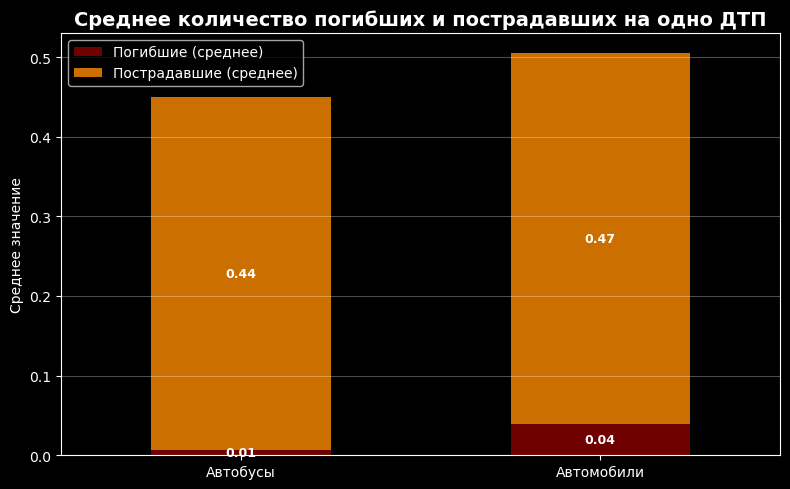

In [490]:
summary = df_roles.groupby('veh_type')[['dead','injured']].mean()

ax = summary[['dead', 'injured']].plot(
    kind='bar',
    stacked=True,
    figsize=(8,5),
    color=['darkred','darkorange'],
    alpha=0.8
)

ax.set_title('Среднее количество погибших и пострадавших на одно ДТП', fontsize=14, fontweight='bold')
ax.set_ylabel('Среднее значение')
ax.set_xticks([0,1])
ax.set_xticklabels(['Автобусы','Автомобили'], rotation=0)
ax.grid(alpha=0.3, axis='y')

ax.legend(['Погибшие (среднее)', 'Пострадавшие (среднее)'])


for p in ax.patches:
    height = p.get_height()
    if height > 0:  # только для ненулевых значений
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2, p.get_y() + height/2),
                    ha='center', va='center',
                    color='white', fontweight='bold', fontsize=9)
ax.set_xlabel("")
plt.tight_layout()
plt.show()

In [491]:
car_data = df_roles[df_roles['veh_type'] == 'car']
bus_data = df_roles[df_roles['veh_type'] == 'bus']

count = [ ((car_data['dead'] == 1) | (car_data['injured'] == 1)).sum(),
          ((bus_data['dead'] == 1) | (bus_data['injured'] == 1)).sum() ]

nobs = [ len(car_data), len(bus_data) ]

stat, pval = proportions_ztest(count, nobs, alternative='smaller')

print("Количество ДТП с погибшими [автомобиль, автобус]:", count)
print("Размер выборки [автомобиль, автобус]:", nobs)
print(f"Z-статистика = {stat:.3f}, p-value = {pval:.5f}")

Количество ДТП с погибшими [автомобиль, автобус]: [1202356, 52902]
Размер выборки [автомобиль, автобус]: [2379835, 117468]
Z-статистика = 36.720, p-value = 1.00000


Вывод: Нет оснований отвергнуть нулевую гипотезу H₀. Вероятность гибели или травмирования участников ДТП одинакова для личных автомобилей и автобусов

Проверим с помощью z теста доли пострадавших, но проверим безопаснее ли ехать в автобусе, чем в автомобиле

In [494]:
count = [ (bus_data['injured'] == 1).sum(),
         (car_data['injured'] == 1).sum()]

nobs = [ len(bus_data), len(car_data) ]

stat, pval = proportions_ztest(count, nobs, alternative='smaller')

print("Количество ДТП с погибшими [автомобиль, автобус]:", count)
print("Размер выборки [автомобиль, автобус]:", nobs)
print(f"Z-статистика = {stat:.3f}, p-value = {pval:.5f}")

Количество ДТП с погибшими [автомобиль, автобус]: [52101, 1109841]
Размер выборки [автомобиль, автобус]: [117468, 2379835]
Z-статистика = -15.306, p-value = 0.00000


На автобусе ехать безопаснее, доля пострадавших меньше, чем в автомобиле.
Возможные объяснения:
- Автобусы лучше защищают при ДТП
- Разная скорость движения
- Разный характер ДТП

Общий вывод
Гипотеза «В личном автомобиле ехать безопаснее чем в автобусе» не подтверждается:
- Вероятность гибели или травмирования участников ДТП одинакова для личных автомобилей и автобусов (результат z-теста)
- Вероятность пострадать в автобусе меньше, чем в автомобиле (результат z-теста)

## Четвертая гипотеза - Если пешеходы не будут нарушать, то не будут гибнуть

Сформулируем нулевую и альтернативную гипотезы:
- Нулевая гипотеза (Н0): Вероятность смерти пешеходов которые нарушают пдд и не нарушают одинаковая
- Альтернативная гипотеза (Н1): Вероятность смерти пешеходов которые нарушают пдд выше, чем у тех, кто не нарушают

Отфильтруем только пешеходов из датафрейма с участниками

In [500]:
peds = participants_df[participants_df['role'] == 'Пешеход'].copy()

Напишем функцию, которая будет добавлять 1 если в столбце violations есть какой-то текст и 0 если пропуск или пустая строка

In [502]:
def has_violations(x):
    if pd.isna(x):
        return 0
    elif isinstance(x, str) and x.strip() == '':
        return 0
    else:
        return 1

Применим функцию и создадим новый столбец

In [504]:
peds['has_violation'] = peds['violations'].apply(has_violations)

Посмотрим долю погибших среди тех кто нарушил и тех кто не нарушал правила

In [506]:
pedestrians_with_violations = peds[peds['has_violation'] == 1]
pedestrians_without_violations = peds[peds['has_violation'] == 0]

fatalities_with_violations = (pedestrians_with_violations['dead'] > 0).sum()
fatalities_without_violations = (pedestrians_without_violations['dead'] > 0).sum()

In [507]:
fatality_rate_with_violations = fatalities_with_violations / len(pedestrians_with_violations)
fatality_rate_without_violations = fatalities_without_violations / len(pedestrians_without_violations)

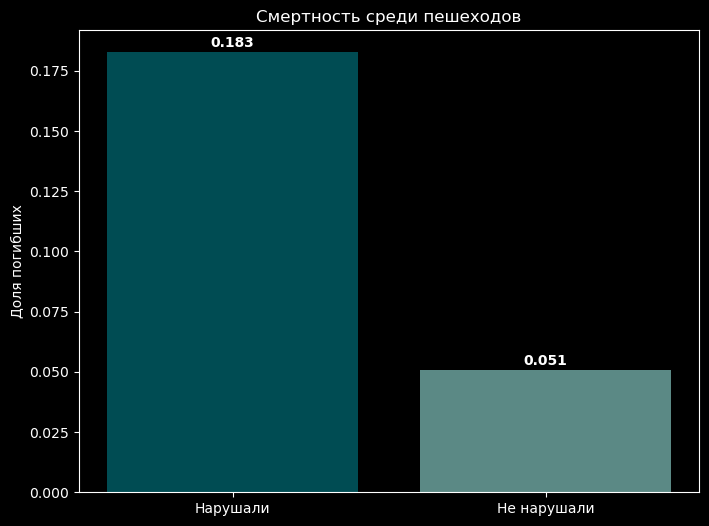

In [508]:
rates = [fatality_rate_with_violations, fatality_rate_without_violations]
labels = ["Нарушали", "Не нарушали"]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, rates, color=["#006d77", "#83c5be"], alpha=0.7)

# Добавляем подписи значений
for bar, rate in zip(bars, rates):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{rate:.3f}', ha='center', va='bottom', fontweight='bold')

plt.ylabel("Доля погибших")
plt.title("Смертность среди пешеходов")
plt.show()

Доля погибших среди тех кто нарушал составляет 18.3%, доля погибших среди тех кто не нарушал правила составляет чуть болье 5.1%

Проверим гипотезу с помощью критерия χ² Пирсона.

In [511]:
contingency = [
    [fatalities_with_violations, len(pedestrians_with_violations)-fatalities_with_violations],
    [fatalities_without_violations, len(pedestrians_without_violations)-fatalities_without_violations]
]
chi2, p_chi2, _, _ = chi2_contingency(contingency)
print(f"Chi² = {chi2:.2f}, p = {p_chi2:.5e}")

Chi² = 19637.60, p = 0.00000e+00


Результаты критерия χ² Пирсона показывают, что существует статистически значимая зависимость между нарушением правил пешеходом и вероятностью его гибели.
Мы отвергаем нулевую гипотезу H₀ и принимаем альтернативную гипотезу H₁: вероятность гибели у пешеходов, нарушающих правила дорожного движения, значительно выше, чем у тех, кто их не нарушает.

Посмотрим вероятность погибнуть у пешехода , который нарушает правила

In [514]:
a = fatalities_with_violations
b = len(pedestrians_with_violations) - a
c = fatalities_without_violations  
d = len(pedestrians_without_violations) - c

(a/b) / (c/d)

4.188387839918156

Шансы погибнуть у пешеходов, нарушающих парввила, почти в 4 раза выше

- Нарушения ПДД пешеходами статистически значимо увеличивают вероятность гибели в ДТП.
- Пешеходы с нарушениями имеют в 4.19 раза выше шанс погибнуть

Посмотрим какие нарушения чаще приводят к смерти, составим топ 10

In [518]:
total_fatal = (
    peds[(peds['dead'] == 1) & (peds['violations'] != '')]['id'].count()
)

fatal_violations = (
    peds[(peds['dead'] == 1) & (peds['violations'] != '')]
    .groupby('violations')['id']
    .count()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={'violations': 'Нарушение', 'id': 'Смертельные случаи'})
)

fatal_violations['Доля, %'] = (fatal_violations['Смертельные случаи'] / total_fatal * 100).round(1)

display(
    fatal_violations
    .style.background_gradient(cmap='Reds', subset=['Смертельные случаи'])
    .format({'Смертельные случаи': "{:.0f}", 'Доля, %': "{:.1f}"})
    .set_caption("Топ-10 нарушений по смертельным случаям (в абсолютных значениях и % от всех)")
)


Наиболее частое нарушение, приводящее к смерти, это переход через проезжую часть вне пешеходного перехода, но рядом с ним более 6000 случаев и почти 20%. На втором месте переход через проезжую часть в неустановленном месте и нахождение на проезжей части, почти по 3000 случаев

Общий вывод
Гипотеза «Если пешеходы не будут нарушать, то не будут гибнуть» подтверждается.

Влияние выражается в нескольких аспектах:
- Доля погибших среди тех кто нарушал составляет 18.3%, доля погибших среди тех кто не нарушал правила составляет чуть болье 5.1%
- Результаты критерия χ² Пирсона показывают, что существует статистически значимая зависимость между нарушением правил пешеходом и вероятностью его гибели. 
- Шансы погибнуть у пешеходов, нарушающих парввила, почти в 4 раза выше

## Пятая гипотеза - Низкая скорость не влияет на тяжесть ДТП

У нас нет данных о скорости, но есть категория аварий где есть упоминание скорости, оно касается превышения, поэтому перефразируем гипотезу: Наличие превышения скорости увеличивает долю смертельных ДТП

- Нулевая гипотеза H₀: Вероятность ДТП с погибшими одинакова для водителей, соблюдающих и нарушающих скоростной режим.

- Альтернативная гипотеза H₁: Вероятность ДТП с погибшими выше для водителей, нарушающих скоростной режим.

Создадим столбец с булевым значением было нарушение скорости или нет

In [524]:
participants_df['has_viol_speed'] = participants_df['violations'].str.contains("скорост", case=False, na=False)

Сгруппируем данные по id аварии, т.к. один id на несколько участников и укажем, что водитель нарушил скоростной режим если хотя бы один из участников одной аварии нарушил

In [526]:
speed_dtp = participants_df.groupby('id')['has_viol_speed'].max().reset_index()

Объединим с основным датафреймом, а пропуски заполним False (в этих строчках значит нет нарушений, касающихся скорости)

In [528]:
speed_dtp = gdf.merge(speed_dtp, on='id', how='left')

speed_dtp['has_viol_speed'] = speed_dtp['has_viol_speed'].fillna(False)

In [529]:
speed_dtp['has_viol_speed'].value_counts()

has_viol_speed
False    1258613
True      207269
Name: count, dtype: int64

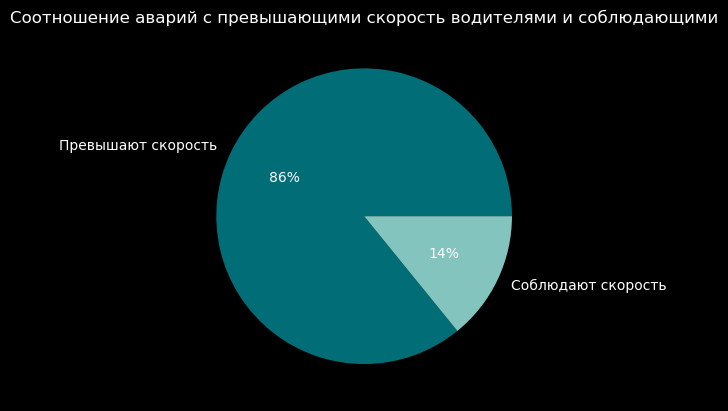

In [530]:
labels = ['Превышают скорость', 'Соблюдают скорость']

speed_dtp['has_viol_speed'].value_counts().plot(
    kind='pie',
    title='Соотношение аварий с превышающими скорость водителями и соблюдающими',
    autopct= '%.0f%%',
    ylabel='',
    colors= ['#006d77', '#83c5be'],
    labels = labels
)

plt.show()

Аварий с водителями, которые соблюдают скорость кратно больше

Посмотрим распределение аварий по степени тяжести

In [533]:
pd.pivot_table(speed_dtp, index='has_viol_speed', columns='severity', values='id', aggfunc='count')

severity        Легкий  С погибшими  Тяжёлый
has_viol_speed                              
False           730957       112552   415104
True             98798        27800    80671

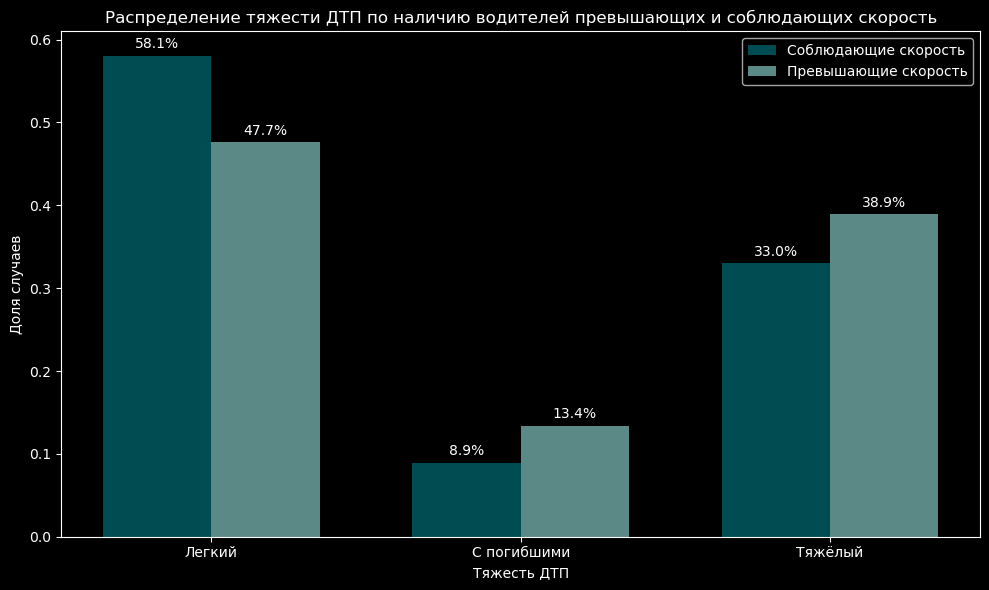

In [534]:
severity_data = speed_dtp.groupby('has_viol_speed')['severity'].value_counts(normalize=True).unstack()

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(severity_data.columns))  # позиции по оси X
width = 0.35  # ширина столбцов
bars1 = ax.bar(x - width/2, severity_data.loc[False], width, 
               label='Соблюдающие скорость', color='#006d77', alpha=0.7)

bars2 = ax.bar(x + width/2, severity_data.loc[True], width, 
               label='Превышающие скорость', color='#83c5be', alpha=0.7)

ax.set_xlabel('Тяжесть ДТП')
ax.set_ylabel('Доля случаев')
ax.set_title('Распределение тяжести ДТП по наличию водителей превышающих и соблюдающих скорость')
ax.set_xticks(x)
ax.set_xticklabels(severity_data.columns)
ax.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1%}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

Если водитель превысил скорость, то вероятность погибнуть или получить тяжелый урон выше. 8.9% погибнуть при соблюдающем водителе и 13.4% при преввышающим скорость водителе, 33% получить тяжелый урон при соблюдающем водителе и 38.9% при превышающем

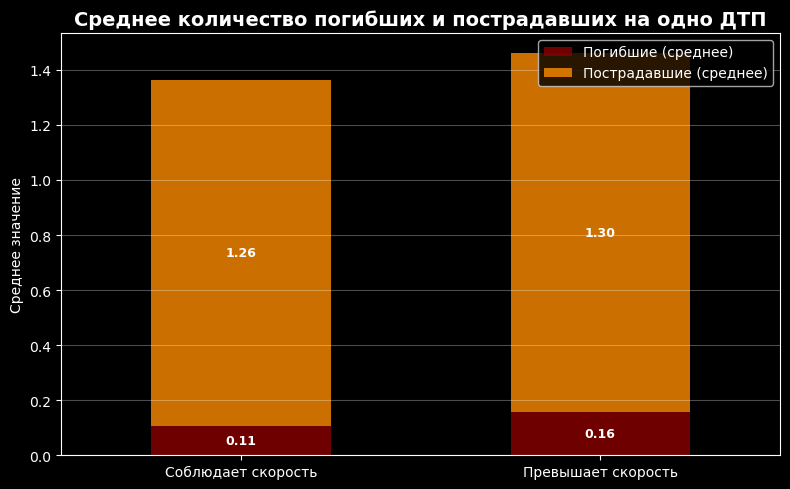

In [536]:
agg_data = speed_dtp.groupby('has_viol_speed')[['dead_count', 'injured_count']].agg(['sum', 'mean']) 

agg_data.columns = ['dead_sum', 'dead_mean', 'injured_sum', 'injured_mean'] 

ax = agg_data[['dead_mean', 'injured_mean']].plot(
    kind='bar',
    stacked=True,
    figsize=(8,5),
    color=['darkred','darkorange'],
    alpha=0.8
)

ax.set_title('Среднее количество погибших и пострадавших на одно ДТП', fontsize=14, fontweight='bold')
ax.set_ylabel('Среднее значение')
ax.set_xticks([0,1])
ax.set_xticklabels(['Соблюдает скорость','Превышает скорость'], rotation=0)
ax.grid(alpha=0.3, axis='y')

ax.legend(['Погибшие (среднее)', 'Пострадавшие (среднее)'])


for p in ax.patches:
    height = p.get_height()
    if height > 0:  # только для ненулевых значений
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2, p.get_y() + height/2),
                    ha='center', va='center',
                    color='white', fontweight='bold', fontsize=9)
ax.set_xlabel("")
plt.tight_layout()
plt.show()

В среднем пострадавших и погибших в дтп больше если водитель был пьян, проведем статистические тесты для проверки гипотезы, вот так выглядт наши нулевая и альтернативная гипотезы:
- Нулевая гипотеза H₀: Вероятность ДТП с погибшими одинакова для водителей, соблюдающих и нарушающих скоростной режим.

- Альтернативная гипотеза H₁: Вероятность ДТП с погибшими выше для водителей, нарушающих скоростной режим.

Проверим гипотезу с z тестом по доле погибших и по доле с тяжелым уроном

In [539]:
speed_fast = speed_dtp[speed_dtp['has_viol_speed'] == True]
speed_normal = speed_dtp[speed_dtp['has_viol_speed'] == False]

count = [(speed_fast['dead_count'] > 0).sum(),
         (speed_normal['dead_count'] > 0).sum()]

nobs = [len(speed_fast), len(speed_normal)]

stat, pval = proportions_ztest(count, nobs, alternative='larger')

print("Количество ДТП с погибшими [превышающие, соблюдающие]:", count)
print("Размер выборки [превышающие, соблюдающие]:", nobs)
print(f"Z-статистика = {stat:.3f}, p-value = {pval:.10f}")

Количество ДТП с погибшими [превышающие, соблюдающие]: [27800, 112552]
Размер выборки [превышающие, соблюдающие]: [207269, 1258613]
Z-статистика = 64.086, p-value = 0.0000000000


In [540]:
count_fast = (speed_fast['severity'] == 'Тяжёлый').sum()
count_normal = (speed_normal['severity'] == 'Тяжёлый').sum()

count = [count_fast, count_normal]
nobs = [len(speed_fast), len(speed_normal)]

print("Количество тяжелых ДТП [превышающие, соблюдающие]:", count)
print("Размер выборки [превышающие, соблюдающие]:", nobs)

# Z-тест пропорций
stat, pval = proportions_ztest(count, nobs, alternative='larger')
print(f"Z-статистика = {stat:.3f}, p-value = {pval:.10f}")

Количество тяжелых ДТП [превышающие, соблюдающие]: [80671, 415104]
Размер выборки [превышающие, соблюдающие]: [207269, 1258613]
Z-статистика = 52.965, p-value = 0.0000000000


Отвергаем нулевую гипотезу, т.к. разница в вероятности ДТП с погибшими между группами статистически значима. В группе с превышающими скорость водителями вероятность гибели участников выше 

Превышение скорости увеличивает риск смертельного исхода в ДТП. Возможно создание условий для невозможности разогнаться или придерживаться скоростного лимита помогут исправить ситуацию.

Посмотрим на количество пострадавших от превышающих скорость и соблюдающих скорость водителей
Построим график QQ-plot чтобы определить с статистическим тестом

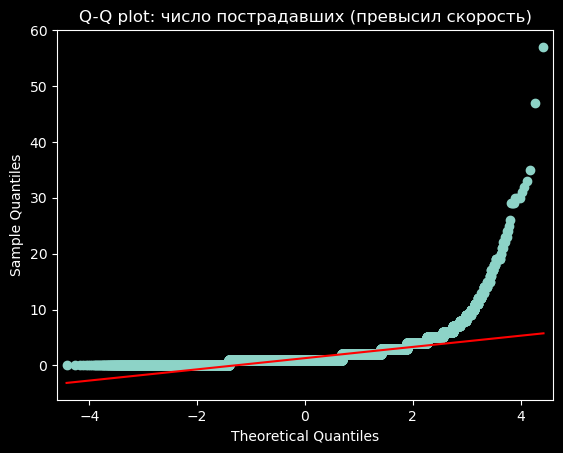

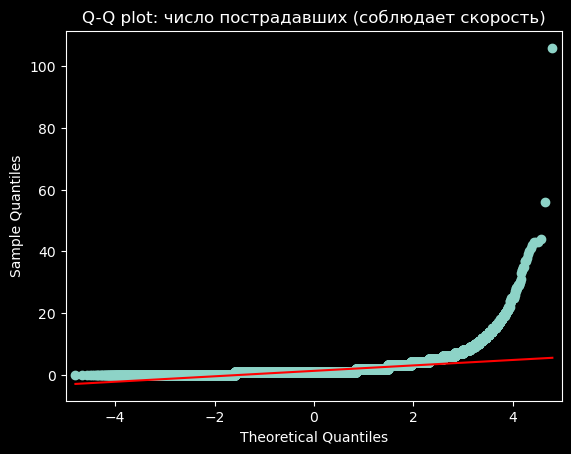

In [543]:
speed_fast = speed_dtp[speed_dtp['has_viol_speed'] == True]['injured_count'].dropna()
speed_normal = speed_dtp[speed_dtp['has_viol_speed'] == False]['injured_count'].dropna()

# Q-Q plot для пьяных
sm.qqplot(speed_fast, line='s')
plt.title("Q-Q plot: число пострадавших (превысил скорость)")
plt.show()

# Q-Q plot для трезвых
sm.qqplot(speed_normal, line='s')
plt.title("Q-Q plot: число пострадавших (соблюдает скорость)")
plt.show()

In [544]:
levene_test = levene(
    speed_dtp[speed_dtp['has_viol_speed'] == True]['injured_count'].dropna(),
    speed_dtp[speed_dtp['has_viol_speed'] == False]['injured_count'].dropna()

)

print(f"Статистика теста Левена: {levene_test.statistic:.4f}")
print(f"P-value: {levene_test.pvalue:.8f}") 


# Интерпретация:
if levene_test.pvalue < 0.05:
    print("\nДисперсии статистически значимо различаются")
else:
    print("\nНет оснований отвергать гипотезу о равенстве дисперсий")

Статистика теста Левена: 1988.8219
P-value: 0.00000000

Дисперсии статистически значимо различаются


Данные распределены не нормально, будем использваоть тест Манна — Уитни:

Гипотеза: Увеличивает ли превышение скорости СРЕДНЕЕ ЧИСЛО пострадавших в ДТП. 
- Нулевая гипотеза H₀: Распределение количества пострадавших в ДТП одинаково для групп с превышающими скорость и соблюдающими водителями

- Альтернативная гипотеза H₁: В ДТП с превышающими скорость водителями количество пострадавших выше чем в ДТП с соблюдающими скорость водителями.

In [546]:
speed_fast = speed_dtp.loc[speed_dtp['has_viol_speed'] == True, 'injured_count'].dropna()
speed_normal = speed_dtp.loc[speed_dtp['has_viol_speed'] == False, 'injured_count'].dropna()

u_stat, p_val = mannwhitneyu(speed_fast, speed_normal, alternative='greater')
print(f"Mann–Whitney U: U={u_stat:.0f}, p-value={p_val:.5f}")

# Эффект-размеры
n1, n2 = len(speed_fast), len(speed_normal)
mean_U = n1*n2/2
sd_U = math.sqrt(n1*n2*(n1+n2+1)/12)
z = (u_stat - mean_U)/sd_U
r = z / math.sqrt(n1+n2)                
cliffs_delta = (2*u_stat)/(n1*n2) - 1  

print(f"Z≈{z:.3f}, r≈{r:.3f}, Cliff’s δ≈{cliffs_delta:.3f}")

# Для наглядности — медианы
print("Медианы injured_count:",
      f"drunk={drunk.median()}, sober={sober.median()}")

Mann–Whitney U: U=133409551822, p-value=0.00000
Z≈16.659, r≈0.014, Cliff’s δ≈0.023
Медианы injured_count: drunk=1.0, sober=1.0


Гипотеза подтверждается частично: превышая скорость действительно увеличивает количество пострадавших в ДТП, но только для относительно редких случаев крупных аварий. Величина эффекта крайне мала (r≈0.014, Cliff’s δ≈0.023), а медианы совпадают (1 пострадавший).
Практически же, в большинстве ДТП число пострадавших остаётся одинаковым для обеих групп.

Общий вывод
Гипотеза «превышение скорости значительно повышает опасность ДТП» подтверждается.

Влияние выражается в двух аспектах:
- Смертельный исход наступает существенно чаще (результат z-теста).
- Распределение числа пострадавших сдвинуто в сторону более тяжёлых случаев у превышающих скорость (результат Манна–Уитни).

Однако «типичное» ДТП (с 1 пострадавшим) одинаково как у соблюдающих, так и у превышающих скорость. Ключевое различие именно в повышенной вероятности катастрофических последствий.

## Шестая гипотеза - ехать в дорогой машине безопаснее 

Будем использовать слова базовый и премиальный, чтобы разделять автомобили. Конечно это не совсем верно, но так проще различать

Перефразируем гипотезу, Участники ДТП в более премиальных автомобилях имеют более низкую вероятность гибели или травмирования по сравнению с участниками ДТП в автомобилях базового класса. Проверим это, используя z тест пропорций:

- Нулевая гипотеза H₀: Вероятность гибели или травмирования участников ДТП одинакова для премиальных и базовых автомобилей

- Альтернативная гипотеза H₁: Вероятность гибели или травмирования участников ДТП ниже в премиальных автомобилях по сравнению с базовыми

Выделим нужные категории

In [553]:
expensive_labels = {
    'Е-класс (высший средний, бизнес-класс) до 4,9 м',
    'S-класс (высший, представительский класс) более 4,9 м'
}
cheap_labels = {
    'А-класс (особо малый) до 3,5 м',
    'В-класс (малый) до 3,9 м',
    'С-класс (малый средний, компактный) до 4,3 м',
    'D-класс (средний) до 4,6 м'
}

Отфильтруем участников этих тс

In [555]:
df_cars = participants_df[participants_df['vehicle_category'].isin(expensive_labels.union(cheap_labels))].copy()

Добавим столбец с признаком expensive/cheap

In [557]:
df_cars['class_group'] = df_cars['vehicle_category'].apply(
    lambda x: 'expensive' if x in expensive_labels else 'cheap'
)

In [558]:
df_cars.sample()

id vehicle_id          vehicle_category      role   gender  \
1570789  1165112  1165112_0  В-класс (малый) до 3,9 м  Водитель  Мужской   

                             violations health_status  \
1570789  Другие нарушения ПДД водителем  Не пострадал   

         years_of_driving_experience  year  dead  injured  unharmed  \
1570789                           11  2020     0        0         1   

         exp_group  is_alcohol  is_driver  drunk_driver  has_viol_speed  \
1570789  10–20 лет       False       True         False           False   

        class_group  
1570789       cheap

In [559]:
df_cars.groupby('class_group')[['dead','injured']].sum()

dead  injured
class_group                
cheap        78215   944343
expensive     1450    16658

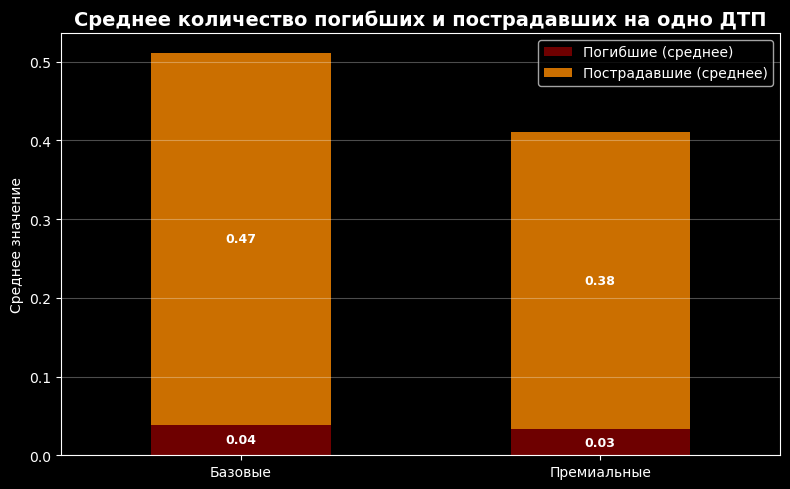

In [560]:
summary = df_cars.groupby('class_group')[['dead','injured']].mean()

ax = summary[['dead', 'injured']].plot(
    kind='bar',
    stacked=True,
    figsize=(8,5),
    color=['darkred','darkorange'],
    alpha=0.8
)

ax.set_title('Среднее количество погибших и пострадавших на одно ДТП', fontsize=14, fontweight='bold')
ax.set_ylabel('Среднее значение')
ax.set_xticks([0,1])
ax.set_xticklabels(['Базовые','Премиальные'], rotation=0)
ax.grid(alpha=0.3, axis='y')

ax.legend(['Погибшие (среднее)', 'Пострадавшие (среднее)'])


for p in ax.patches:
    height = p.get_height()
    if height > 0:  # только для ненулевых значений
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2, p.get_y() + height/2),
                    ha='center', va='center',
                    color='white', fontweight='bold', fontsize=9)
ax.set_xlabel("")
plt.tight_layout()
plt.show()

In [561]:
expensive_data = df_cars[df_cars['class_group'] == 'expensive']
cheap_data = df_cars[df_cars['class_group'] == 'cheap']

count = [ (expensive_data['dead'] > 0).sum(),
          (cheap_data['dead'] > 0).sum() ]

nobs = [ len(expensive_data), len(cheap_data) ]

stat, pval = proportions_ztest(count, nobs, alternative='smaller')

print("Количество ДТП с погибшими [пьяные, трезвые]:", count)
print("Размер выборки [пьяные, трезвые]:", nobs)
print(f"Z-статистика = {stat:.3f}, p-value = {pval:.5f}")

Количество ДТП с погибшими [пьяные, трезвые]: [1450, 78215]
Размер выборки [пьяные, трезвые]: [44138, 2000428]
Z-статистика = -6.709, p-value = 0.00000


In [562]:
expensive_data = df_cars[df_cars['class_group'] == 'expensive']
cheap_data = df_cars[df_cars['class_group'] == 'cheap']

count = [ (expensive_data['injured'] > 0).sum(),
          (cheap_data['injured'] > 0).sum() ]

nobs = [ len(expensive_data), len(cheap_data) ]

stat, pval = proportions_ztest(count, nobs, alternative='smaller')

print("Количество ДТП с погибшими [пьяные, трезвые]:", count)
print("Размер выборки [пьяные, трезвые]:", nobs)
print(f"Z-статистика = {stat:.3f}, p-value = {pval:.5f}")

Количество ДТП с погибшими [пьяные, трезвые]: [16658, 944343]
Размер выборки [пьяные, трезвые]: [44138, 2000428]
Z-статистика = -39.415, p-value = 0.00000


Гипотеза подтверждается: участники ДТП в премиальных автомобилях имеют статистически значимо более низкую вероятность погибнуть или получить травмы по сравнению с участниками в базовых авто. Эффект не только значим статистически, но и практически заметен:15% снижение смертельных исходов (3.9% → 3.3%), 20% снижение вероятности травм (47.2% → 37.7%).

## Седьмая гипотеза - Дорожное покрытие влияет на тяжесть дтп

В столбце `road_conditions` более 5 тысяч различных вариантов дорожного покрытия, возьмем самые популярные 

In [566]:
gdf['road_conditions'].value_counts().sort_values(ascending=False).head(3)

road_conditions
Сухое                                                                            645794
Мокрое                                                                           184511
Отсутствие, плохая различимость горизонтальной разметки проезжей части, Сухое    117393
Name: count, dtype: int64

Отсутствие дорожного покрытия в ДТП существенно повышает вероятность гибели участников. Проверим это, используя z тест пропорций:

- Нулевая гипотеза H₀: вероятность ДТП с погибшими одинакова в группах дтп с дорожным покрытием и без дорожного покрытия.

- Альтернативная гипотеза H₁: вероятность ДТП с погибшими выше в группе с отсутствием дорожного покрытия.

Выделим эти категории в отдельный даатфрейм

In [569]:
target_values = [
    'Сухое',
    'Отсутствие, плохая различимость горизонтальной разметки проезжей части, Сухое'
]

road_df = gdf[gdf['road_conditions'].isin(target_values)].copy()

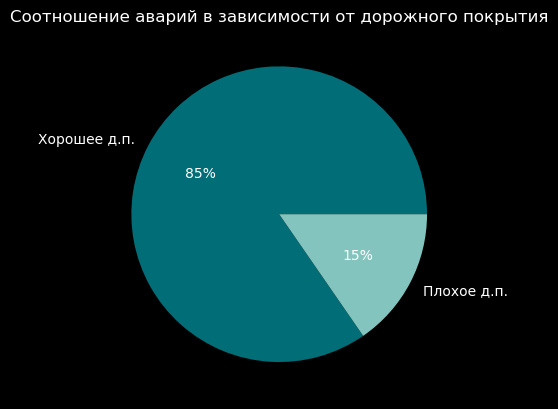

In [570]:
labels = ['Хорошее д.п.', 'Плохое д.п.']

road_df['road_conditions'].value_counts().plot(
    kind= 'pie',
    title='Соотношение аварий в зависимости от дорожного покрытия',
    autopct= '%.0f%%',
    ylabel= '',
    colors= ['#006d77', '#83c5be'],
    labels = labels
)

plt.show()

Посмотрим распределение аварий по степени тяжести

In [572]:
pivot = pd.pivot_table(road_df, index='road_conditions', columns='severity', values='id', aggfunc='count')
pivot

severity                                            Легкий  С погибшими  \
road_conditions                                                           
Отсутствие, плохая различимость горизонтальной ...   66157         9293   
Сухое                                               367378        64457   

severity                                            Тяжёлый  
road_conditions                                              
Отсутствие, плохая различимость горизонтальной ...    41943  
Сухое                                                213959

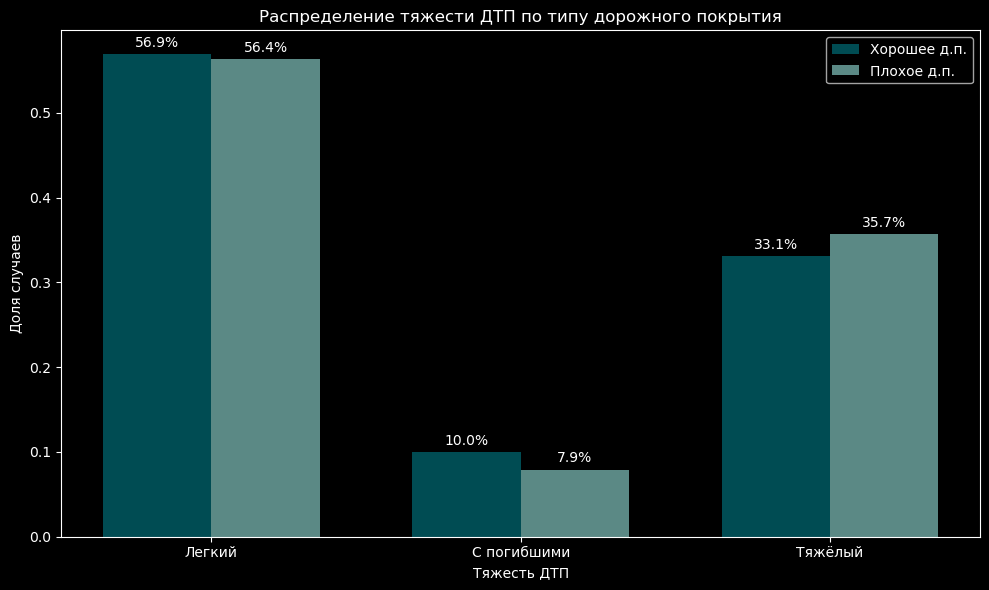

In [573]:
severity_data = road_df.groupby('road_conditions')['severity'].value_counts(normalize=True).unstack()

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(severity_data.columns))  
width = 0.35  
bars1 = ax.bar(x - width/2, severity_data.loc['Сухое'], width, 
               label='Хорошее д.п.', color='#006d77', alpha=0.7)

bars2 = ax.bar(x + width/2, severity_data.loc['Отсутствие, плохая различимость горизонтальной разметки проезжей части, Сухое'], width, 
               label='Плохое д.п.', color='#83c5be', alpha=0.7)

ax.set_xlabel('Тяжесть ДТП')
ax.set_ylabel('Доля случаев')
ax.set_title('Распределение тяжести ДТП по типу дорожного покрытия')
ax.set_xticks(x)
ax.set_xticklabels(severity_data.columns)
ax.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1%}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

Проведем z-тест пропорций

In [575]:
good_road = road_df[road_df['road_conditions'] == 'Сухое']
bad_road = road_df[road_df['road_conditions'] == 'Отсутствие, плохая различимость горизонтальной разметки проезжей части, Сухое']

count = [ (bad_road['dead_count'] > 0).sum(),
          (good_road['dead_count'] > 0).sum() ]

nobs = [ len(bad_road), len(good_road) ]

stat, pval = proportions_ztest(count, nobs, alternative='larger')

print("Количество ДТП с погибшими [Плохое д.п., Хорошее д.п.]:", count)
print("Размер выборки [Плохое д.п., Хорошее д.п.]:", nobs)
print(f"Z-статистика = {stat:.3f}, p-value = {pval:.5f}")

Количество ДТП с погибшими [Плохое д.п., Хорошее д.п.]: [9293, 64457]
Размер выборки [Плохое д.п., Хорошее д.п.]: [117393, 645794]
Z-статистика = -22.027, p-value = 1.00000


Нет оснований отклонить нулевую гипотезу. Отсутствие д.п. не увеличивает вероятность гибели участников.

Гипотеза: Увеличивает ли наличие плохого д.п. СРЕДНЕЕ ЧИСЛО пострадавших в ДТП. 
- Нулевая гипотеза H₀: Распределение количества пострадавших в ДТП одинаково для групп с плохим и хорошим д.п.

- Альтернативная гипотеза H₁: В ДТП с плохим д.п. количество пострадавших выше чем в ДТП с хорошим д.п.

In [578]:
conditions_map = {
    'Сухое': True,
    'Отсутствие, плохая различимость горизонтальной разметки проезжей части, Сухое': False
}

road_df['is_good_road'] = road_df['road_conditions'].map(conditions_map).fillna(False)

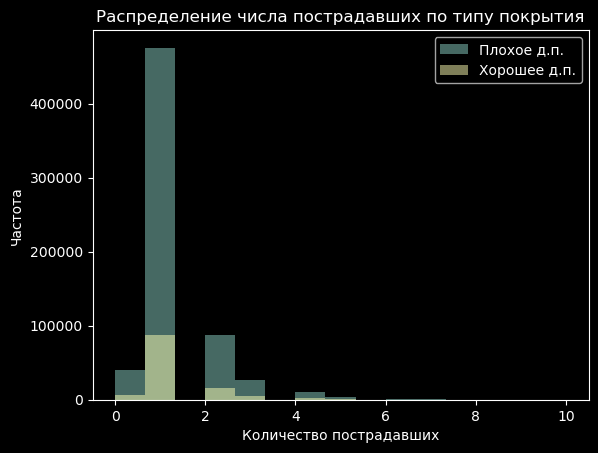

In [579]:
plt.hist(
    road_df[road_df['is_good_road'] == True]['injured_count'].dropna(), 
    bins=15, alpha=0.5, label='Плохое д.п.', range=(0, 10)
)
plt.hist(
    road_df[road_df['is_good_road'] == False]['injured_count'].dropna(), 
    bins=15, alpha=0.5, label='Хорошее д.п.', range=(0, 10)
)
plt.legend()
plt.title('Распределение числа пострадавших по типу покрытия')
plt.xlabel('Количество пострадавших')
plt.ylabel('Частота')
plt.show()

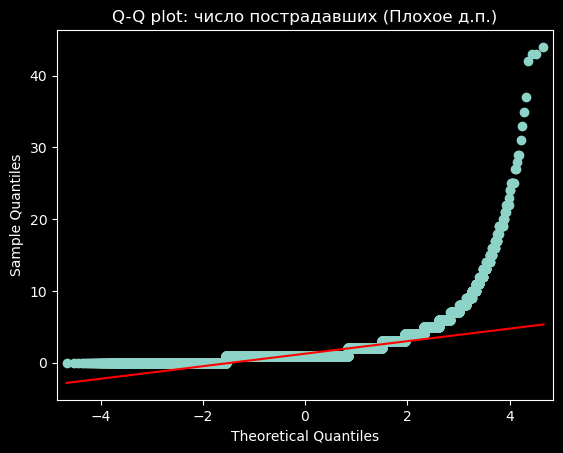

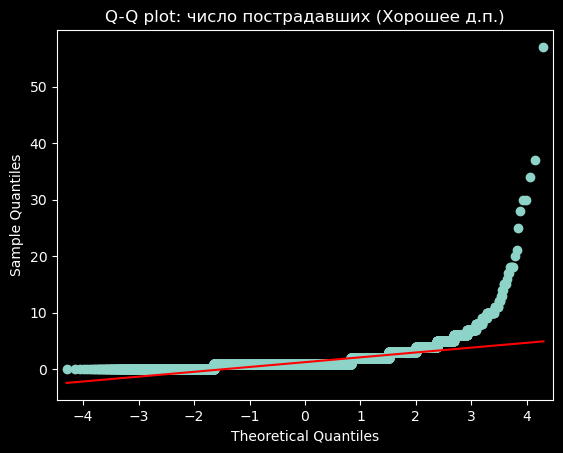

In [580]:
bad_road = road_df[road_df['is_good_road'] == True]['injured_count'].dropna()
good_road = road_df[road_df['is_good_road'] == False]['injured_count'].dropna()

# Q-Q plot для пьяных
sm.qqplot(bad_road, line='s')
plt.title("Q-Q plot: число пострадавших (Плохое д.п.)")
plt.show()

# Q-Q plot для трезвых
sm.qqplot(good_road, line='s')
plt.title("Q-Q plot: число пострадавших (Хорошее д.п.)")
plt.show()

In [581]:
bad_road = road_df[~road_df['is_good_road']]['injured_count'].dropna()
good_road = road_df[road_df['is_good_road']]['injured_count'].dropna()

u_stat, p_val = mannwhitneyu(bad_road, good_road, alternative='greater')
print(f"Mann–Whitney U: U={u_stat:.0f}, p-value={p_val:.5f}")

# Эффект-размеры
n1, n2 = len(bad_road), len(good_road)
mean_U = n1*n2/2
sd_U = math.sqrt(n1*n2*(n1+n2+1)/12)
z = (u_stat - mean_U)/sd_U
r = z / math.sqrt(n1+n2)                
cliffs_delta = (2*u_stat)/(n1*n2) - 1  

print(f"Z≈{z:.3f}, r≈{r:.3f}, Cliff’s δ≈{cliffs_delta:.3f}")

# Для наглядности — медианы
print("Медианы injured_count:",
      f"drunk={bad_road.median()}, sober={good_road.median()}")

Mann–Whitney U: U=38211396268, p-value=0.00000
Z≈4.400, r≈0.005, Cliff’s δ≈0.008
Медианы injured_count: drunk=1.0, sober=1.0


Количество пострадавших в ДТП на плохих дорогах статистически значимо превышает показатель на хороших дорогах. Но малый размер эффекта (δ = 0.008) указывает на ограниченную практическую значимость выявленных различий. Размер эффекта слишком мал для практических выводов. 

Общий вывод
Гипотеза «Дорожное покрытие влияет на тяжесть дтп» подтверждается лишь частично.

- Вероятность погибнуть на плохом д.п. такая же как на хорошем д.п. (результат z-теста).
- Распределение числа пострадавших сдвинуто в сторону более тяжёлых случаев на плохом д.п. (результат Манна–Уитни).

# 5 Выводы и рекомендации

Итоговые выводы:
- За десятилетие отмечается устойчивая тенденция снижения числа ДТП и смертельных исходов.
- Увеличение количества ДТП в летние месяцы и в пятницу-субботу.
- Больше всего гибнут водители в абсолютных цифрах, но самый высокий риск смерти у дорожных рабочих (22–23%) и у пешеходов вне транспорта (до 16%), у пассажиров и велосипедистов (5%), водителей (3%).
- Опытные водители (10-20 лет стажа) - наиболее частые участники ДТП (31%)
- Влияние алкоголя: значительно повышает риск смертельного исхода.
- Нарушения пешеходов: повышают риск гибели в 4 раза.
- Превышение скорости: увеличивает вероятность тяжелых последствий.

Рекомендации:
- Усиление контроля:
   - За соблюдением скоростного режима
   - За управлением в состоянии опьянения
   - За соблюдением ПДД пешеходами, особенно переход вне зебр
   - За соблюдением техники безопасности дорожных рабочих
   - За соблюдением ПДД в выходные дни, а также в летние месяцы
- Улучшение инфраструктуры:
   - Уличное освещение (критически важно, вероятность летальных исходов достигает 25%)
   - Организация специальных переходов и ограждений для предотвращения выхода пешеходов на проезжую часть
   - Улучшенная организация зон дорожны работ
- Образовательные компании
   - Образовательные программы о последствиях нарушений пешеходами ПДД, объяснять, что даже 10–20 метров "сэкономленного пути" могут стоить жизни, устанавливать где чаще всего фиксируется переход "вне перехода".
   - Ввести образовательные программы для детей и подростков
   - Борьба с алкоголем как для водителей  так и для пешеходов
- Фокус внимания:
   - Округа с высокой аварийностью: Сибирский и Северо-Западный ФО
   - Регионы с высокой аварийностью: Краснодарский край
- Бесплатная раздача светоотражателей детям и пожилым в регионах с высокой смертностью.
- Цифровой контроль пешеходов